In [1]:
#imports
!pip install ultralytics -q
from ultralytics import YOLO
import os
import pandas as pd
from glob import glob
import cv2
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
import shutil
import yaml
from IPython.display import Image
from datetime import datetime

In [2]:
#configure wandb
WANDB_API_KEY = "6531b5cf314ee49900e4d0224339640ea50ebb84"
wandb.login(key=WANDB_API_KEY)
wandb.init(project="Animal Type Detection")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ahuderrick1 (ahuderrick1-makerere-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/soprano/.netrc


In [3]:
#download dataset
os.makedirs('animal_type_dataset', exist_ok=True)
!git clone -b animal_type_detection_dataset https://github.com/MVet-Platform/M-Vet_Hackathon24.git ./animal_type_dataset 

fatal: destination path './animal_type_dataset' already exists and is not an empty directory.


In [4]:
#load label data
df = pd.read_csv('./animal_type_dataset/label_train.csv')
df.head()

filename class  xmin  ymin  xmax  \
0  cb3854ef-2abc-4d44-bd1f-807a38660c616894251975...   cow     1    54   641   
1  4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e804977089514...   cow   168   128   532   
2  cb279fc1-67a3-413c-b3f8-c0594bf0507a1407359993...   cow   584   310   586   
3  97e0bf2d-4548-4c25-9bd7-5a867b8654153628120299...   cow     7    62   641   
4  747cef5f-e7dc-4657-b0e4-225450446a631015105642...   cow   120    48   530   

   ymax  
0   562  
1   360  
2   312  
3   469  
4   336

In [5]:
df['class'].value_counts(normalize=True)

cow     0.704333
pig     0.165376
goat    0.130291
Name: class, dtype: float64

In [6]:
df['filename'].duplicated().any()

True

In [7]:
def drawBoundingBoxAroundImage(image_path, bbox, class_):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,0), 2)
    cv2.putText(img, class_, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [8]:
#get file path for image files
df['filepath'] = df.apply(lambda row: glob(f'animal_type_dataset/**/{row.filename}')[0], axis=1)

In [9]:
len(df.filename.unique()), len(df.filepath.unique())

(9808, 9808)

In [10]:
df.head()

filename class  xmin  ymin  xmax  \
0  cb3854ef-2abc-4d44-bd1f-807a38660c616894251975...   cow     1    54   641   
1  4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e804977089514...   cow   168   128   532   
2  cb279fc1-67a3-413c-b3f8-c0594bf0507a1407359993...   cow   584   310   586   
3  97e0bf2d-4548-4c25-9bd7-5a867b8654153628120299...   cow     7    62   641   
4  747cef5f-e7dc-4657-b0e4-225450446a631015105642...   cow   120    48   530   

   ymax                                           filepath  
0   562  animal_type_dataset/0006/cb3854ef-2abc-4d44-bd...  
1   360  animal_type_dataset/0003/4f3cbf08-13cc-4ae9-ba...  
2   312  animal_type_dataset/0006/cb279fc1-67a3-413c-b3...  
3   469  animal_type_dataset/0005/97e0bf2d-4548-4c25-9b...  
4   336  animal_type_dataset/0004/747cef5f-e7dc-4657-b0...

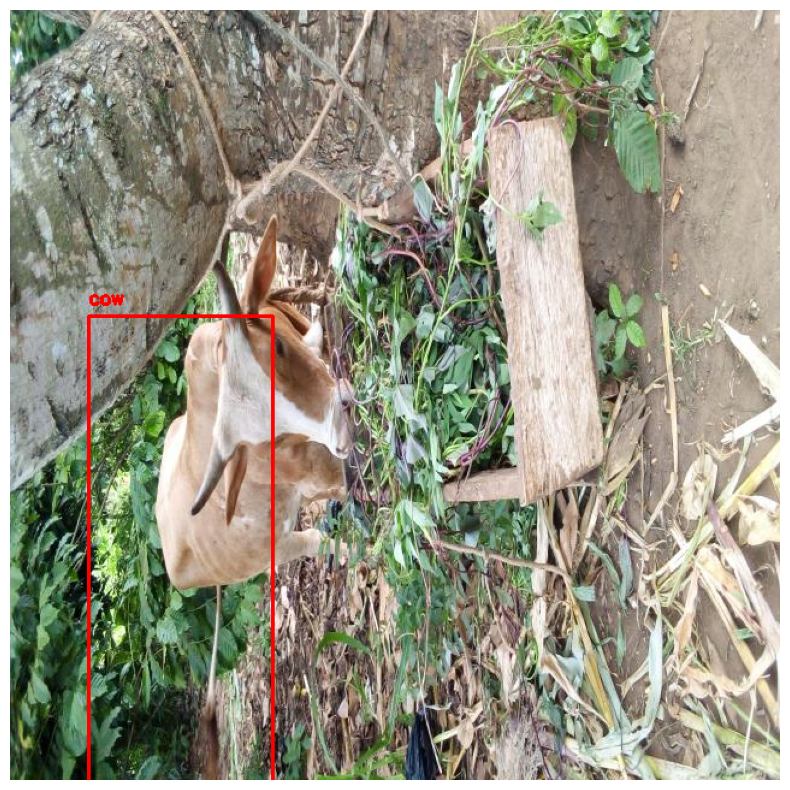

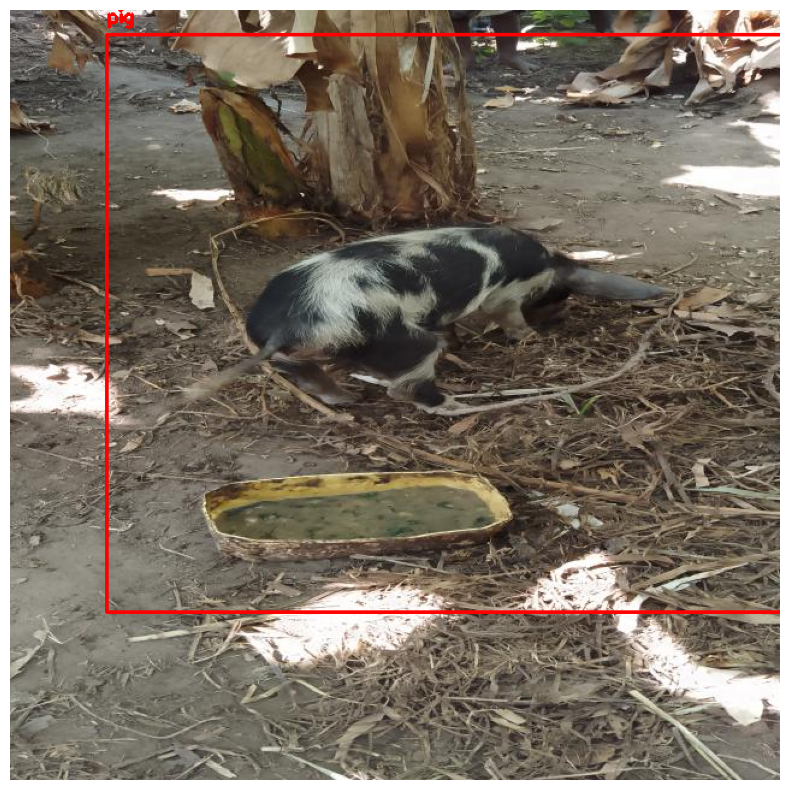

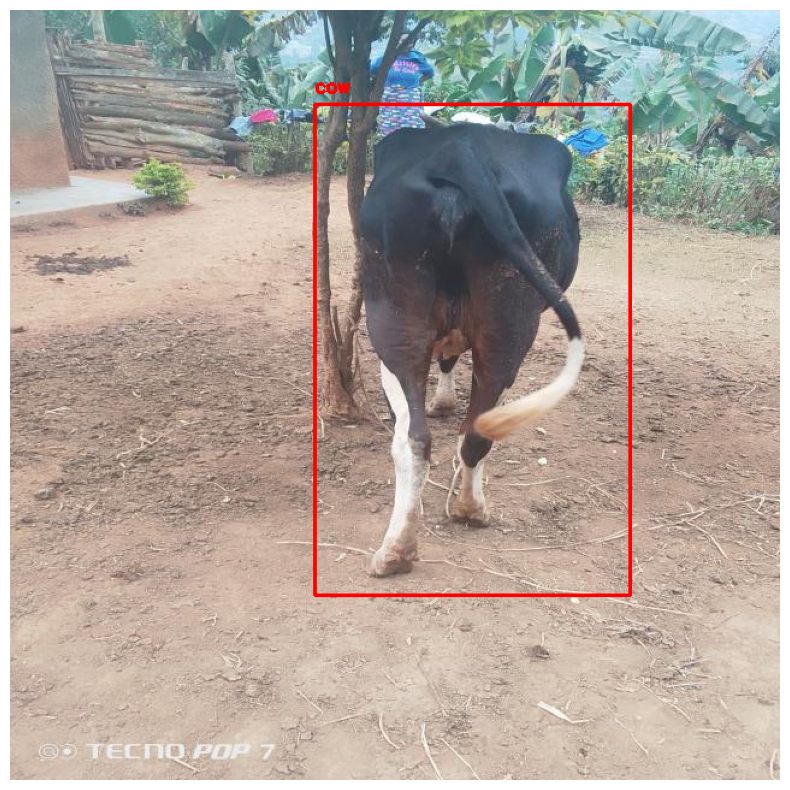

5508    None
3063    None
9082    None
dtype: object

In [11]:
df.sample(3).apply(lambda row: drawBoundingBoxAroundImage(row.filepath, [row.xmin, row.ymin, row.xmax, row.ymax], row['class']), axis=1)

In [12]:
def convert_voc_to_yolo(xmin, ymin, xmax, ymax, img_width=640, img_height=640):
    # Calculate the center of the bounding box
    center_x = (xmin + xmax) / 2.0
    center_y = (ymin + ymax) / 2.0

    # Calculate the width and height of the bounding box
    width = xmax - xmin
    height = ymax - ymin

    # Normalize the values by the dimensions of the image
    center_x /= img_width
    center_y /= img_height
    width /= img_width
    height /= img_height

    return [center_x, center_y, width, height]

In [13]:
df_train, df_valid = train_test_split(df, test_size=0.3, random_state=32)

In [14]:
labels = ['cow', 'goat', 'pig']

In [15]:
os.makedirs('yolo_dataset/train/labels', exist_ok=True)
os.makedirs('yolo_dataset/train/images', exist_ok=True)
train_grouping = df_train.groupby('filepath')
for index, group in enumerate(train_grouping):
    bboxes = group[1].apply(lambda row: [row.xmin, row.ymin, row.xmax, row.ymax] , axis=1).to_list()   
    classes = group[1].apply(lambda row: labels.index(row['class']) , axis=1).to_list() 
    file_path = group[0]
    filename = os.path.basename(file_path)
    with open(f'yolo_dataset/train/labels/{os.path.splitext(filename)[0]}.txt', 'w') as file:
        for class_, bbox in zip(classes, bboxes):
            center_x, center_y, width, height = convert_voc_to_yolo(*bbox)
            file.write(f'{class_} {center_x} {center_y} {width} {height}\n')
    shutil.copy(file_path, 'yolo_dataset/train/images')

In [16]:
os.makedirs('yolo_dataset/valid/labels', exist_ok=True)
os.makedirs('yolo_dataset/valid/images', exist_ok=True)
valid_grouping = df_valid.groupby('filepath')
for index, group in enumerate(valid_grouping):
    bboxes = group[1].apply(lambda row: [row.xmin, row.ymin, row.xmax, row.ymax] , axis=1).to_list()   
    classes = group[1].apply(lambda row: labels.index(row['class']) , axis=1).to_list() 
    file_path = group[0]
    filename = os.path.basename(file_path)
    with open(f'yolo_dataset/valid/labels/{os.path.splitext(filename)[0]}.txt', 'w') as file:
        for class_, bbox in zip(classes, bboxes):
            center_x, center_y, width, height = convert_voc_to_yolo(*bbox)
            file.write(f'{class_} {center_x} {center_y} {width} {height}\n')
    shutil.copy(file_path, 'yolo_dataset/valid/images')

In [17]:
df_sample_submission = pd.read_csv('./animal_type_dataset/sample_submission.csv')
df_sample_submission.head()

filename class  confidence  xmin  \
0  dc3bf168-1589-486d-8152-438d0e4a56f24141622663...   cow        0.75     0   
1  0691e0da-6b49-414e-a0d9-e6caa2fbe3fa2720742594...   cow        0.75     0   
2  68072e08-d602-4daa-9b2e-b53e3075d45d7996898967...   cow        0.75     0   
3  57f59f63-9ec6-4d0b-b837-808a089f3d876691836245...   cow        0.75     0   
4  7091ebde-40ba-478c-b119-2c558dfe133a8689373316...   cow        0.75     0   

   ymin  xmax  ymax  
0     0     0     0  
1     0     0     0  
2     0     0     0  
3     0     0     0  
4     0     0     0

In [18]:
#get file path for test image files
df_sample_submission['filepath'] = df_sample_submission.apply(lambda row: glob(f'animal_type_dataset/**/{row.filename}')[0], axis=1)
df_sample_submission.head()

filename class  confidence  xmin  \
0  dc3bf168-1589-486d-8152-438d0e4a56f24141622663...   cow        0.75     0   
1  0691e0da-6b49-414e-a0d9-e6caa2fbe3fa2720742594...   cow        0.75     0   
2  68072e08-d602-4daa-9b2e-b53e3075d45d7996898967...   cow        0.75     0   
3  57f59f63-9ec6-4d0b-b837-808a089f3d876691836245...   cow        0.75     0   
4  7091ebde-40ba-478c-b119-2c558dfe133a8689373316...   cow        0.75     0   

   ymin  xmax  ymax                                           filepath  
0     0     0     0  animal_type_dataset/0006/dc3bf168-1589-486d-81...  
1     0     0     0  animal_type_dataset/0001/0691e0da-6b49-414e-a0...  
2     0     0     0  animal_type_dataset/0003/68072e08-d602-4daa-9b...  
3     0     0     0  animal_type_dataset/0003/57f59f63-9ec6-4d0b-b8...  
4     0     0     0  animal_type_dataset/0004/7091ebde-40ba-478c-b1...

In [19]:
test_file_paths = df_sample_submission.filepath.unique()

In [20]:
#create test directory
os.makedirs('yolo_dataset/test/images')
for file_path in test_file_paths:
    shutil.copy(file_path, 'yolo_dataset/test/images')

FileExistsError: [Errno 17] File exists: 'yolo_dataset/test/images'

In [21]:
data = {
'names': labels,
'nc': len(labels),
'test': './test/images',
'train': './train/images',
'val': './valid/images'
}
with open('yolo_dataset/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

In [22]:
#train model
model = YOLO("yolov8s.pt")
model.train(data="/home/soprano/Downloads/yolo_dataset/data.yaml", epochs=210, imgsz=640, plots=True)

New https://pypi.org/project/ultralytics/8.2.82 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.145 🚀 Python-3.7.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16064MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/home/soprano/Downloads/yolo_dataset/data.yaml, epochs=210, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /home/soprano/Downloads/yolo_dataset/valid/labels.cache... 5136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5136/5136 [00:00<?, ?it/s]
val: WARNING ⚠️ /home/soprano/Downloads/yolo_dataset/valid/images/0078deec-5c72-48be-b058-e849498ba03c8089119554761334082_jpg.rf.e1070d74f98eb996836e2667796f25cd.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /home/soprano/Downloads/yolo_dataset/valid/images/008e9448-b6fa-49c9-8f25-c5cb44c05ae26726831712261589822_jpg.rf.893256a011106fa847ecf3589e2322cb.jpg: 4 duplicate labels removed
val: WARNING ⚠️ /home/soprano/Downloads/yolo_dataset/valid/images/01b61a0e-2760-47b5-92e4-8fc2b9d407fe3685802179793363922_jpg.rf.8f8e4332be363a6c62219cd7bdf8f6b5.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /home/soprano/Downloads/yolo_dataset/valid/images/01dda9d4-d247-47a6-9127-668fcfc3a7

Plotting labels to runs/detect/train60/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train60
Starting training for 210 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      1/210      5.21G      1.346      1.928      1.712         20        640: 100%|██████████| 540/540 [01:04<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.14it/s]
                   all       5136       5157      0.571      0.546      0.533      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      2/210      5.32G      1.276      1.482      1.639         22        640: 100%|██████████| 540/540 [01:04<00:00,  8.43it/s]
                 Class     Images  Instanc


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     19/210      5.27G      1.206      1.353      1.591         24        640: 100%|██████████| 540/540 [01:01<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.25it/s]
                   all       5136       5157      0.737      0.725      0.757      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     20/210      5.27G      1.208      1.357      1.589         23        640: 100%|██████████| 540/540 [01:01<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.32it/s]
                   all       5136       5157      0.774      0.737      0.767      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     21/210      5.27G        1.2      1.328   

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.22it/s]
                   all       5136       5157      0.798       0.78      0.808      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     38/210      5.27G      1.152      1.243      1.549         26        640: 100%|██████████| 540/540 [01:01<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.32it/s]
                   all       5136       5157      0.803      0.783      0.818      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     39/210      5.27G      1.135      1.243      1.536         29        640: 100%|██████████| 540/540 [01:01<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:0

     56/210      5.27G      1.098      1.176      1.513         24        640: 100%|██████████| 540/540 [01:01<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.31it/s]
                   all       5136       5157       0.83      0.822      0.851      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     57/210      5.27G      1.096      1.161      1.506         26        640: 100%|██████████| 540/540 [01:01<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.33it/s]
                   all       5136       5157      0.828      0.821       0.85      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     58/210      5.27G      1.108       1.18      1.515         23        640: 100%|██████████| 540/540 [01:01<00:00,  8.78it/


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     75/210      5.27G      1.066      1.115       1.48         24        640: 100%|██████████| 540/540 [01:01<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.24it/s]
                   all       5136       5157      0.862      0.843      0.884      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     76/210      5.27G      1.074      1.111       1.49         26        640: 100%|██████████| 540/540 [01:01<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.29it/s]
                   all       5136       5157      0.858      0.841      0.883      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     77/210      5.27G      1.065      1.104   

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.35it/s]
                   all       5136       5157       0.87       0.86      0.895       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     94/210      5.27G       1.03      1.036      1.452         22        640: 100%|██████████| 540/540 [01:01<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.34it/s]
                   all       5136       5157      0.871      0.861      0.896      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     95/210      5.27G      1.029       1.04      1.455         26        640: 100%|██████████| 540/540 [01:01<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:0

    112/210      5.27G     0.9809     0.9634      1.413         29        640: 100%|██████████| 540/540 [01:01<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.30it/s]
                   all       5136       5157      0.881      0.872      0.912      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    113/210      5.27G     0.9878     0.9563      1.424         24        640: 100%|██████████| 540/540 [01:01<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.36it/s]
                   all       5136       5157      0.882      0.872      0.912      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    114/210      5.27G     0.9847     0.9558      1.419         23        640: 100%|██████████| 540/540 [01:01<00:00,  8.79it/


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    131/210      5.27G     0.9308     0.8878      1.383         25        640: 100%|██████████| 540/540 [01:01<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.31it/s]
                   all       5136       5157      0.886      0.881       0.92      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    132/210      5.27G     0.9304     0.8789      1.381         19        640: 100%|██████████| 540/540 [01:01<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.37it/s]
                   all       5136       5157      0.886      0.882       0.92      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    133/210      5.27G     0.9372     0.8835   

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.32it/s]
                   all       5136       5157      0.896      0.886      0.926      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    150/210      5.27G     0.8809     0.8176      1.341         31        640: 100%|██████████| 540/540 [01:01<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.35it/s]
                   all       5136       5157      0.897      0.886      0.926      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    151/210      5.27G     0.8777      0.812      1.343         27        640: 100%|██████████| 540/540 [01:01<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:0

    168/210      5.27G     0.8204     0.7463      1.293         19        640: 100%|██████████| 540/540 [01:01<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.01it/s]
                   all       5136       5157      0.902      0.896      0.933      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    169/210      5.27G     0.8274     0.7358      1.296         27        640: 100%|██████████| 540/540 [01:01<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.02it/s]
                   all       5136       5157      0.903      0.897      0.933      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    170/210      5.27G     0.8259     0.7372      1.295         23        640: 100%|██████████| 540/540 [01:01<00:00,  8.71it/


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    187/210      5.27G     0.7609      0.676      1.255         22        640: 100%|██████████| 540/540 [01:01<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.06it/s]
                   all       5136       5157      0.911      0.901      0.938       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    188/210      5.27G     0.7615     0.6728       1.25         21        640: 100%|██████████| 540/540 [01:01<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 11.03it/s]
                   all       5136       5157      0.912        0.9      0.939      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    189/210      5.27G     0.7599     0.6776   

    205/210      5.27G     0.5871     0.3532      1.186         10        640: 100%|██████████| 540/540 [01:01<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 10.93it/s]
                   all       5136       5157      0.916      0.912      0.944      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    206/210      5.27G     0.5776      0.347      1.179         10        640: 100%|██████████| 540/540 [01:02<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:14<00:00, 10.99it/s]
                   all       5136       5157      0.916      0.914      0.944      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    207/210      5.27G     0.5795     0.3386      1.183         10        640: 100%|██████████| 540/540 [01:01<00:00,  8.71it/

In [23]:
#list yolo generated training files
os.listdir("runs/detect/train/")

['args.yaml', 'weights']

In [24]:
#Image(filename='runs/detect/train/results.png', width=600)

In [25]:
#Image(filename='runs/detect/train/val_batch0_pred.jpg', width=600)

In [26]:
#make predictions
results = model.predict(source='yolo_dataset/test/images', conf=0.25, save=True, project=f"runs/detect", name="predict", exist_ok=True)



    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

image 1/9811 /home/soprano/Downloads/yolo_dataset/test/images/000c4dcc-1dfb-4ba9-b82a-8084b839e02b8229627971783132002_jpg.rf.66f747b7977a2f874959f17a1e0a93a2.jpg: 640x640 1 cow, 4.3ms
image 2/9811 /home/soprano/Downloads/yolo_dataset/test/images/00133b56-3901-4a85-a862-004daf4869f7393130629613491919_jpg.rf.63636470b2d9a0e2862cc9fd461f78de.jpg: 640x640 1 cow, 4.7ms
image 3/9811 /home/soprano/Downloads/yolo_dataset/test/images/0016844c-8421-4e81-896c-71d6d8

image 43/9811 /home/soprano/Downloads/yolo_dataset/test/images/00c2a3ab-199d-48cf-bdd5-332f96e690b34630424399007622368_jpg.rf.ad6552add714c8fa6cfac7281f3ae33b.jpg: 640x640 1 cow, 4.8ms
image 44/9811 /home/soprano/Downloads/yolo_dataset/test/images/00c34e76-b23d-4b2e-8e79-94c0ae93aaba3868216885007668196_jpg.rf.c1a7c54f6c9b83621f4279c093999c2e.jpg: 640x640 1 cow, 8.3ms
image 45/9811 /home/soprano/Downloads/yolo_dataset/test/images/00cbe9e6-4bb0-40bd-b09f-276527cd22c84638632166952212403_jpg.rf.886e9203e0af98b6b0bdf78c045c3c6f.jpg: 640x640 1 pig, 4.9ms
image 46/9811 /home/soprano/Downloads/yolo_dataset/test/images/00d34079-c56c-4e54-b05a-4c10c1beb0534241922145564984109_jpg.rf.1b0fbc5b116ccc926fc63750162bf3b1.jpg: 640x640 1 cow, 4.8ms
image 47/9811 /home/soprano/Downloads/yolo_dataset/test/images/00d5a5cf-e7fe-445a-813b-9737a2a10e5b3271973405330830038_jpg.rf.c5eb8c124a12274c29ec61039b16d8d7.jpg: 640x640 2 cows, 4.5ms
image 48/9811 /home/soprano/Downloads/yolo_dataset/test/images/00d819f7-1b

image 88/9811 /home/soprano/Downloads/yolo_dataset/test/images/0206ff4b-9d10-45a0-bb8b-0081dec9cd602952999882267307355_jpg.rf.e33e3d520204f809946aecd74c1f9ee6.jpg: 640x640 1 cow, 4.5ms
image 89/9811 /home/soprano/Downloads/yolo_dataset/test/images/02079c1e-3ca4-4c8a-997f-820d173c126c8079635632737970805_jpg.rf.0cdbb16c4a6ead2c2f6cdc5ef28e7047.jpg: 640x640 2 cows, 10.2ms
image 90/9811 /home/soprano/Downloads/yolo_dataset/test/images/020b3785-51f2-45c9-8d53-064efb12420c4709167241806937746_jpg.rf.6071fc0b548a9869b5ee6fb23e73c63d.jpg: 640x640 1 cow, 4.7ms
image 91/9811 /home/soprano/Downloads/yolo_dataset/test/images/0213ff8f-3407-48d0-9195-7088bc04ff827462538785390738138_jpg.rf.c1af0aafae7ec7f9c6951f2c2a492106.jpg: 640x640 1 cow, 4.9ms
image 92/9811 /home/soprano/Downloads/yolo_dataset/test/images/0224ca5c-5324-492d-9c3c-ca984ab9f608820587481992403425_jpg.rf.1de3e6c046d74073299d357d9cda4072.jpg: 640x640 1 cow, 4.5ms
image 93/9811 /home/soprano/Downloads/yolo_dataset/test/images/02287086-a8

image 133/9811 /home/soprano/Downloads/yolo_dataset/test/images/034413c7-4b8b-4aea-b19f-8425dd2a520e6838574514046017494_jpg.rf.d2524953ce8d6e81289dde0f57fc4b0b.jpg: 640x640 1 cow, 5.5ms
image 134/9811 /home/soprano/Downloads/yolo_dataset/test/images/034fd1fc-73f3-4d91-81f7-742ff421751f3508788461423545450_jpg.rf.d99984e956c04ba4ce89e8806d515634.jpg: 640x640 1 cow, 5.3ms
image 135/9811 /home/soprano/Downloads/yolo_dataset/test/images/0351f53c-412e-4427-8c9d-e86418e115a3516242280464463974_jpg.rf.70ab66886ac080d23cc867b5162a3fec.jpg: 640x640 1 goat, 4.7ms
image 136/9811 /home/soprano/Downloads/yolo_dataset/test/images/035a8477-54ec-454c-959b-3388a68afd477402878653118182599_jpg.rf.a846542a5acc3fdf3d7e7c8cecaadbd1.jpg: 640x640 1 goat, 5.0ms
image 137/9811 /home/soprano/Downloads/yolo_dataset/test/images/0368a518-4f4a-45f2-8986-31a74843cbee3290417255139891991_jpg.rf.f509e02e5588c966af4c5624dc0e35ac.jpg: 640x640 1 goat, 4.6ms
image 138/9811 /home/soprano/Downloads/yolo_dataset/test/images/0369

image 177/9811 /home/soprano/Downloads/yolo_dataset/test/images/0471aa95-928a-40dc-88b3-47e6a2b2eac03826422983138083027_jpg.rf.20e615dd256e3a009eed8e28459b0e9c.jpg: 640x640 1 cow, 4.9ms
image 178/9811 /home/soprano/Downloads/yolo_dataset/test/images/04760846-734d-4308-aa92-c11497de28257278313321548430602_jpg.rf.945ee631efe4b0763b1ba9db218ffb34.jpg: 640x640 1 cow, 4.7ms
image 179/9811 /home/soprano/Downloads/yolo_dataset/test/images/048027c5-ef73-4054-b685-376d7c8670835568652533868533161_jpg.rf.a3e756187c162526149dc42af0550cf7.jpg: 640x640 1 cow, 5.0ms
image 180/9811 /home/soprano/Downloads/yolo_dataset/test/images/048fea23-6fe4-43b5-867f-58a20e314a864048256530077288329_jpg.rf.0276ac183cd59eff706cb2663a12e4ce.jpg: 640x640 1 pig, 5.1ms
image 181/9811 /home/soprano/Downloads/yolo_dataset/test/images/0495eff5-3336-4496-b875-a872a43771ec3179076537897807998_jpg.rf.630fdc06a48cba919e24de8951622b8f.jpg: 640x640 1 pig, 4.6ms
image 182/9811 /home/soprano/Downloads/yolo_dataset/test/images/049911

image 221/9811 /home/soprano/Downloads/yolo_dataset/test/images/05d1b500-8976-4286-86ae-d74ec743b4556203201678870240988_jpg.rf.6cb49fe227035fe91780eea255cb34c9.jpg: 640x640 1 pig, 5.9ms
image 222/9811 /home/soprano/Downloads/yolo_dataset/test/images/05d6cd08-511f-4ec8-a296-4360aadb00084304156037369309267_jpg.rf.903dcdeb1b3170d0e09fee46da0872b6.jpg: 640x640 1 pig, 5.2ms
image 223/9811 /home/soprano/Downloads/yolo_dataset/test/images/05d7f8c4-eb74-48ea-8425-67b5dad038722298296109944247887_jpg.rf.0b86bd949c08f66ebab7f3d6c033a960.jpg: 640x640 1 cow, 5.0ms
image 224/9811 /home/soprano/Downloads/yolo_dataset/test/images/05e05d6f-6e3a-44c9-a82f-141395a2c5cc7383104323842771663_jpg.rf.0076d2cfbbb9c3ac1aa85ef92aa07b1f.jpg: 640x640 1 cow, 4.9ms
image 225/9811 /home/soprano/Downloads/yolo_dataset/test/images/05e4c6d7-376c-4002-8ead-48ac1f52736f4170891172202216522_jpg.rf.fd97d0b36d59ddaab443d9dffd1cf17c.jpg: 640x640 1 cow, 4.8ms
image 226/9811 /home/soprano/Downloads/yolo_dataset/test/images/05fcf1

image 265/9811 /home/soprano/Downloads/yolo_dataset/test/images/06ce08c4-5310-4dfe-a202-3d015c86f339122531914276793302_jpg.rf.48c22e17faa3b6e658dc55db2a7fad57.jpg: 640x640 1 goat, 4.6ms
image 266/9811 /home/soprano/Downloads/yolo_dataset/test/images/06d012d9-8f60-4460-8598-67c966487d0610690552871092239_jpg.rf.b7db78a898ce9952b477441b9435663e.jpg: 640x640 1 pig, 4.5ms
image 267/9811 /home/soprano/Downloads/yolo_dataset/test/images/06d1a0d8-22f0-44bc-801f-cedd22fb12044653873799880158812_jpg.rf.2e8a4ec6e8ba6f5942c6873a3358ed80.jpg: 640x640 1 cow, 4.7ms
image 268/9811 /home/soprano/Downloads/yolo_dataset/test/images/06d7ef4e-6194-4289-b31e-ffcda83b0b657682687017295750949_jpg.rf.289cc07ff40c349adfa17f0fb7469283.jpg: 640x640 1 pig, 5.6ms
image 269/9811 /home/soprano/Downloads/yolo_dataset/test/images/06d94ca8-49ad-4009-98a6-0d8eb77ae54e624265067636498239_jpg.rf.f1aeed456e68f0a25a754f315dff247d.jpg: 640x640 1 cow, 5.1ms
image 270/9811 /home/soprano/Downloads/yolo_dataset/test/images/06df4414-

image 309/9811 /home/soprano/Downloads/yolo_dataset/test/images/07e81666-0a11-479b-b088-b83093fb50732347090318347917101_jpg.rf.3d67bb66177dfbd01aa8e7d4b455bd62.jpg: 640x640 1 pig, 4.6ms
image 310/9811 /home/soprano/Downloads/yolo_dataset/test/images/07e9e45d-2672-4877-8523-efd44ee95a054499633578469493714_jpg.rf.5bdeb2fddac125833ebbd2d82e15c9ed.jpg: 640x640 1 cow, 4.6ms
image 311/9811 /home/soprano/Downloads/yolo_dataset/test/images/07eacf48-fc9d-44c9-a620-03d67b1cdd5e3882787287197233980_jpg.rf.0b5477253b54e004d75724a9ff9aec94.jpg: 640x640 1 cow, 4.6ms
image 312/9811 /home/soprano/Downloads/yolo_dataset/test/images/07f0f5c8-62ae-4aae-b25b-3d119107863b5378047902585223388_jpg.rf.020b41c1ca7550c24d5268adda646190.jpg: 640x640 1 pig, 4.6ms
image 313/9811 /home/soprano/Downloads/yolo_dataset/test/images/08068adb-19a6-43aa-983a-0ccfe0e1a1da9049260396574880111_jpg.rf.3b6988e198db4ff1f4026f49ee29ac58.jpg: 640x640 1 cow, 4.4ms
image 314/9811 /home/soprano/Downloads/yolo_dataset/test/images/08181c

image 354/9811 /home/soprano/Downloads/yolo_dataset/test/images/09001f28-4438-40aa-9a07-9b25ff6d77ea341340180389006959_jpg.rf.03cb0faf38b85b6efc6140b730f324a4.jpg: 640x640 1 cow, 4.9ms
image 355/9811 /home/soprano/Downloads/yolo_dataset/test/images/0906b95c-32cc-413e-b149-c41f9e9580774933739507303337732_jpg.rf.70a10594bab3ec142216573afe9806f3.jpg: 640x640 1 cow, 4.5ms
image 356/9811 /home/soprano/Downloads/yolo_dataset/test/images/090b51ef-e88f-48cf-bb8c-55d16e93e0c06523630461352823595_jpg.rf.733c4dc75664f8cd14cd1a3d83c15a0e.jpg: 640x640 2 cows, 4.8ms
image 357/9811 /home/soprano/Downloads/yolo_dataset/test/images/091970ec-1902-474f-9eae-770793d920966544383956524451071_jpg.rf.e453bb6df17934d41bf6a920e9751d1f.jpg: 640x640 3 pigs, 4.9ms
image 358/9811 /home/soprano/Downloads/yolo_dataset/test/images/091dd936-4c5a-436e-8dcc-b93626ad69e23695341751083182397_jpg.rf.3bd8147cf5b50207ca9d2c03cc02c21a.jpg: 640x640 1 cow, 4.7ms
image 359/9811 /home/soprano/Downloads/yolo_dataset/test/images/091df

image 398/9811 /home/soprano/Downloads/yolo_dataset/test/images/0a364937-accf-4625-8fa5-88e97bcc1b384703083328873713545_jpg.rf.d333c45ff8c6fb8db8fec22fecb3b2d3.jpg: 640x640 2 cows, 4.6ms
image 399/9811 /home/soprano/Downloads/yolo_dataset/test/images/0a37cc2c-03ee-4f06-b27d-69952d0d66141916656570193854936_jpg.rf.db3642df18ab4c0a2886cc0e23518a93.jpg: 640x640 2 cows, 4.7ms
image 400/9811 /home/soprano/Downloads/yolo_dataset/test/images/0a3a9ec0-e278-4ae8-a59e-4fccfcfc3c211090720915323951459_jpg.rf.550268e94a4d5cba93af1a57ec3f9432.jpg: 640x640 1 pig, 6.7ms
image 401/9811 /home/soprano/Downloads/yolo_dataset/test/images/0a3c3d8a-c545-46c6-8a8b-54f976da5c316348269858771435343_jpg.rf.7150b6f23a0c7548310d6fcb01a4e61f.jpg: 640x640 1 cow, 4.5ms
image 402/9811 /home/soprano/Downloads/yolo_dataset/test/images/0a44400c-4bdb-48d8-b872-644eba9fd47a1434113991363636894_jpg.rf.6cc4621eaa5cb2b5324d6612298c9cfc.jpg: 640x640 1 cow, 4.7ms
image 403/9811 /home/soprano/Downloads/yolo_dataset/test/images/0a57

image 442/9811 /home/soprano/Downloads/yolo_dataset/test/images/0b16b899-6264-4d87-8dd0-8fd0856241fb1589041972105001340_jpg.rf.c82bc02da29077b2a5750ed9d00d2d5d.jpg: 640x640 2 cows, 6.6ms
image 443/9811 /home/soprano/Downloads/yolo_dataset/test/images/0b1dcb4b-8c9f-46bd-9408-837ab05afc4a3440736502662976329_jpg.rf.f171d6f6332fa2972d3cb0073b52982e.jpg: 640x640 1 cow, 4.6ms
image 444/9811 /home/soprano/Downloads/yolo_dataset/test/images/0b2619bd-c5f0-448e-bc8a-9e4378784d0142659778054334732_jpg.rf.c21349b6d186f671e676d0543bae2b01.jpg: 640x640 1 pig, 4.8ms
image 445/9811 /home/soprano/Downloads/yolo_dataset/test/images/0b2a75d8-aba4-4fb7-b73d-40208aeb0e825311868857132552475_jpg.rf.216b6ff6d1cb5df27352292738eea0b3.jpg: 640x640 2 cows, 5.2ms
image 446/9811 /home/soprano/Downloads/yolo_dataset/test/images/0b2b15a3-a7f0-4fc7-8ec3-c5e139ae1ed72289341793866125931_jpg.rf.6c3fd680aca403000a13782ed7d653dd.jpg: 640x640 2 cows, 5.1ms
image 447/9811 /home/soprano/Downloads/yolo_dataset/test/images/0b2fd

image 486/9811 /home/soprano/Downloads/yolo_dataset/test/images/0c1f6751-f288-4d8b-b773-d92dcf71f5827975277430668397797_jpg.rf.cdd61362fd5ae037e87bae5a4a005381.jpg: 640x640 1 cow, 4.4ms
image 487/9811 /home/soprano/Downloads/yolo_dataset/test/images/0c21c7a9-d995-42b7-8e8a-522eca29d1bf3048614360539061425_jpg.rf.302ec72bc9e118d8b5517456b7c1aa69.jpg: 640x640 1 cow, 4.4ms
image 488/9811 /home/soprano/Downloads/yolo_dataset/test/images/0c2c0d1a-34da-4702-a44c-42544c6a042c7314495239505389638_jpg.rf.4137448346e94163fbe4c15ffd85deea.jpg: 640x640 1 cow, 4.7ms
image 489/9811 /home/soprano/Downloads/yolo_dataset/test/images/0c375e32-415a-46fe-b0d6-0fa5465858101606755948177890396_jpg.rf.b3151ab69bfd02e6cbe3ec8f28f15b3e.jpg: 640x640 1 pig, 4.7ms
image 490/9811 /home/soprano/Downloads/yolo_dataset/test/images/0c418546-c674-428e-824c-aaf940041d573016013131765423975_jpg.rf.3c2c3134a7b9098cafce11b172550694.jpg: 640x640 1 pig, 4.3ms
image 491/9811 /home/soprano/Downloads/yolo_dataset/test/images/0c469c

image 530/9811 /home/soprano/Downloads/yolo_dataset/test/images/0cf0cd1f-bf24-463c-9e5e-b76e9a3ec6b49077990191665817473_jpg.rf.f78ef3e373911a070c15446e261c7e2a.jpg: 640x640 1 cow, 4.5ms
image 531/9811 /home/soprano/Downloads/yolo_dataset/test/images/0cf42cda-b16c-4bae-89e1-df31dc949fc17839548373973881520_jpg.rf.042e6f12fb6278e7888ceb4c2000749b.jpg: 640x640 1 cow, 4.6ms
image 532/9811 /home/soprano/Downloads/yolo_dataset/test/images/0cfbbeed-fd0c-4ced-9f76-7b167c6ef4034449239083709115241_jpg.rf.ff386dc959c261ef6963d383b83c9ef3.jpg: 640x640 1 cow, 5.0ms
image 533/9811 /home/soprano/Downloads/yolo_dataset/test/images/0d03c9ab-3441-4236-aa4e-f6ad19b38bc57084957077684006019_jpg.rf.725e91c452117c795d03413e875fce99.jpg: 640x640 1 pig, 4.8ms
image 534/9811 /home/soprano/Downloads/yolo_dataset/test/images/0d06ee7a-71dc-4614-8327-f4b1877714dd3866045465097424545_jpg.rf.cf857fda295de35febd4d93b9ac89343.jpg: 640x640 1 cow, 4.5ms
image 535/9811 /home/soprano/Downloads/yolo_dataset/test/images/0d084a

image 574/9811 /home/soprano/Downloads/yolo_dataset/test/images/0e0585c1-63e5-402b-a4d5-79657b31f2d07252281096438618125_jpg.rf.a8b5cc0f373ce8882b16ba6298044f3b.jpg: 640x640 2 goats, 4.8ms
image 575/9811 /home/soprano/Downloads/yolo_dataset/test/images/0e0a9027-52b7-465b-9457-984b7792c6192128720328109346105_jpg.rf.ec70ec5b78e6afc4078d574567a34228.jpg: 640x640 2 cows, 4.9ms
image 576/9811 /home/soprano/Downloads/yolo_dataset/test/images/0e0e7e5b-53b3-4b71-a6b9-c25d81cb58702235228015369252487_jpg.rf.747320e85afd10742572447e776a2d7d.jpg: 640x640 1 cow, 4.7ms
image 577/9811 /home/soprano/Downloads/yolo_dataset/test/images/0e0f04aa-fb9e-4474-8de7-cbaa9ef0ba2c5352121633390512105_jpg.rf.3e637262e532f768d23e836516752da6.jpg: 640x640 1 cow, 4.7ms
image 578/9811 /home/soprano/Downloads/yolo_dataset/test/images/0e0f04aa-fb9e-4474-8de7-cbaa9ef0ba2c5352121633390512105_jpg.rf.3fa6ff973136952b2739b303e956e355.jpg: 640x640 1 cow, 4.6ms
image 579/9811 /home/soprano/Downloads/yolo_dataset/test/images/0e1

image 619/9811 /home/soprano/Downloads/yolo_dataset/test/images/0eee8e07-553c-481f-8344-79624c8fa8b25517318313299877966_jpg.rf.6a41276ae942e6fe4208822eba7f7f69.jpg: 640x640 1 cow, 4.8ms
image 620/9811 /home/soprano/Downloads/yolo_dataset/test/images/0ef22adf-3417-4d7c-a85e-c1b1dee75c726761794708152361667_jpg.rf.a6cc3de0af02a9754b331c685d53939d.jpg: 640x640 1 cow, 4.8ms
image 621/9811 /home/soprano/Downloads/yolo_dataset/test/images/0efd8f9a-bfbb-483a-bb05-128e1a9abe4b279643820626474889_jpg.rf.70ee3bdf66c1bd3bf1dfc14f27ad6c44.jpg: 640x640 1 cow, 4.6ms
image 622/9811 /home/soprano/Downloads/yolo_dataset/test/images/0f0d04d4-8e1a-45a8-a019-b615faec1b5b5766147447496151053_jpg.rf.a3610fb0eb82ee5158b9d8d221c09a99.jpg: 640x640 2 cows, 4.4ms
image 623/9811 /home/soprano/Downloads/yolo_dataset/test/images/0f112988-76a9-46da-b83f-e8c70e3cd1922035869041396058591_jpg.rf.996799c51b05e76a6c86a78d7e5f57fe.jpg: 640x640 1 cow, 4.5ms
image 624/9811 /home/soprano/Downloads/yolo_dataset/test/images/0f3403

image 663/9811 /home/soprano/Downloads/yolo_dataset/test/images/0fff3a98-b6f1-4be1-b5b8-b35556f7a5575566136074174015876_jpg.rf.fbba0953f2d23c406ce3aaa5d4511959.jpg: 640x640 1 cow, 4.4ms
image 664/9811 /home/soprano/Downloads/yolo_dataset/test/images/10058d08-6e9c-4cc1-8bf5-668a289f051e8432090032890525198_jpg.rf.65cc2a31513ca79c9f0e23687702b777.jpg: 640x640 1 cow, 4.3ms
image 665/9811 /home/soprano/Downloads/yolo_dataset/test/images/100f6077-ca1f-4ccd-a652-28e11faa3528217046672235664146_jpg.rf.7522b6fd9e350eb76446d5a3a4c57803.jpg: 640x640 1 cow, 4.6ms
image 666/9811 /home/soprano/Downloads/yolo_dataset/test/images/10163641-a6c8-4603-ba74-4d49df6305cd2697354157036964971_jpg.rf.1d23de4c5edea6e5a782b6ac97e00ca8.jpg: 640x640 1 cow, 4.7ms
image 667/9811 /home/soprano/Downloads/yolo_dataset/test/images/101d6511-6c9d-4029-8a93-4d3162bbdbb72489578639488750622_jpg.rf.cc3bd2e4ca61e75231e6092c44b49655.jpg: 640x640 1 cow, 4.8ms
image 668/9811 /home/soprano/Downloads/yolo_dataset/test/images/1025490

image 708/9811 /home/soprano/Downloads/yolo_dataset/test/images/1104e76b-b0fc-45ee-82a6-91cce52041968716936750588700657_jpg.rf.8835d9102c7cdc3d177ed33c27313592.jpg: 640x640 2 cows, 4.5ms
image 709/9811 /home/soprano/Downloads/yolo_dataset/test/images/1109347e-428e-45d4-a273-623fc16865d22348207348266698564_jpg.rf.6ee34d472ac6cfeaea42c5507408394a.jpg: 640x640 1 cow, 4.8ms
image 710/9811 /home/soprano/Downloads/yolo_dataset/test/images/1117e0dd-6eea-468b-ac3e-0e7ab2ddda136997507610254861451_jpg.rf.64d437fc4d6e41f54e3562b5a4c2cb29.jpg: 640x640 1 pig, 4.6ms
image 711/9811 /home/soprano/Downloads/yolo_dataset/test/images/1118ccf3-bbe9-475c-b5a0-c887f8f03f0e8811030113663964428_jpg.rf.a111ae9d3b6bce8cdb0e8a22a3165447.jpg: 640x640 1 cow, 4.7ms
image 712/9811 /home/soprano/Downloads/yolo_dataset/test/images/111cc493-37b6-4a29-9f7c-72111574ded23299780463731410978_jpg.rf.f8808725444223c65620026696b295b4.jpg: 640x640 1 cow, 4.6ms
image 713/9811 /home/soprano/Downloads/yolo_dataset/test/images/1122d

image 752/9811 /home/soprano/Downloads/yolo_dataset/test/images/121d94a6-4c4f-4291-9ec8-261ce86281ad8712473150472657580_jpg.rf.b50a16ab6cc1db7a1cbefef5fe5ffacd.jpg: 640x640 1 cow, 4.7ms
image 753/9811 /home/soprano/Downloads/yolo_dataset/test/images/12399963-de69-4e69-94b1-653c3856b69c7559249957173482997_jpg.rf.51cc1d8f43931aacfadb7643b72a3de5.jpg: 640x640 1 cow, 4.6ms
image 754/9811 /home/soprano/Downloads/yolo_dataset/test/images/123afd25-edf5-4200-8448-96a34cc053714326900052846052539_jpg.rf.f7825f3098365a2af410a9900b544185.jpg: 640x640 2 goats, 4.6ms
image 755/9811 /home/soprano/Downloads/yolo_dataset/test/images/124852f1-0706-4714-96e2-a701fe549ffc5751602208719802408_jpg.rf.76dd8685dcfdf1d90e11432c853e7d69.jpg: 640x640 1 goat, 8.2ms
image 756/9811 /home/soprano/Downloads/yolo_dataset/test/images/124a8eae-9791-46d6-b967-5ecef94532a75372017763207821181_jpg.rf.34729346711b83e8252edd34ad56d50c.jpg: 640x640 1 cow, 4.6ms
image 757/9811 /home/soprano/Downloads/yolo_dataset/test/images/124

image 796/9811 /home/soprano/Downloads/yolo_dataset/test/images/132fa7ca-6f50-4e70-8abf-908bc2627cf66000554640510807187_jpg.rf.518c30db583e6eaf9634d40d58430d76.jpg: 640x640 1 goat, 4.4ms
image 797/9811 /home/soprano/Downloads/yolo_dataset/test/images/1332c0ed-9615-456a-9030-ee7ee8bbc3a83866975136825925632_jpg.rf.296495d75ee73c94f112f658afe4aca6.jpg: 640x640 1 cow, 4.7ms
image 798/9811 /home/soprano/Downloads/yolo_dataset/test/images/13367342-65b2-44d2-8ab1-b5f55acfae713487083005874090693_jpg.rf.f0c748337be03579ff20d91d12bfbdcb.jpg: 640x640 2 cows, 6.3ms
image 799/9811 /home/soprano/Downloads/yolo_dataset/test/images/13369556-b241-46f0-bade-8f66495c457b3972188979714333102_jpg.rf.d73220cc013fbc1744eeac200137b4d3.jpg: 640x640 1 goat, 4.6ms
image 800/9811 /home/soprano/Downloads/yolo_dataset/test/images/133c0ad5-56a8-419c-a579-fa057f0d0ee65338616086085497362_jpg.rf.e95fcdf0301b7326f63b7ceedb3f2371.jpg: 640x640 1 goat, 4.7ms
image 801/9811 /home/soprano/Downloads/yolo_dataset/test/images/13

image 841/9811 /home/soprano/Downloads/yolo_dataset/test/images/147e987e-a4cf-4f4a-b2a1-6b2e334c6d181782740944534212614_jpg.rf.ffe62606590726733b0d41c3d61683b2.jpg: 640x640 1 goat, 5.7ms
image 842/9811 /home/soprano/Downloads/yolo_dataset/test/images/14813320-3e2f-4ec9-bea8-0259a367661b2146764133806933522_jpg.rf.3727ac07351c016dc9e7bee20be86284.jpg: 640x640 1 cow, 4.4ms
image 843/9811 /home/soprano/Downloads/yolo_dataset/test/images/1486aa57-b210-43d2-a74a-b3c246fab79b7043597508101143633_jpg.rf.6756932a6e0162166ba565fe85eb8ce6.jpg: 640x640 1 cow, 5.1ms
image 844/9811 /home/soprano/Downloads/yolo_dataset/test/images/1486aa57-b210-43d2-a74a-b3c246fab79b7043597508101143633_jpg.rf.9333059d07aada81730bf55f53156af1.jpg: 640x640 1 cow, 5.0ms
image 845/9811 /home/soprano/Downloads/yolo_dataset/test/images/1488fc3e-886c-4ecd-8c15-63abfc4d41347495101465288262838_jpg.rf.5c58e1e884b3ed3e1275538cc0b28c2a.jpg: 640x640 1 cow, 5.0ms
image 846/9811 /home/soprano/Downloads/yolo_dataset/test/images/14920

image 885/9811 /home/soprano/Downloads/yolo_dataset/test/images/155f5e98-65fc-4c4d-82b3-d8eb4bcdc4af7063242230822849554_jpg.rf.b909e4743665ef5d686e207629ce418d.jpg: 640x640 1 pig, 5.2ms
image 886/9811 /home/soprano/Downloads/yolo_dataset/test/images/15707331-40a2-4dd0-b588-8fb320aef19a4322489149275929896_jpg.rf.88d5a13c19961a8f39fd4b5dc3627c6e.jpg: 640x640 1 goat, 7.4ms
image 887/9811 /home/soprano/Downloads/yolo_dataset/test/images/15738c08-19f5-4df4-bb0a-dd14be8a1e5b4363058524846375307_jpg.rf.200a608d7ea2e6c4fae75bfd858e327c.jpg: 640x640 1 cow, 7.6ms
image 888/9811 /home/soprano/Downloads/yolo_dataset/test/images/1580ea20-e95c-4f62-a381-d400e45c45a35736983604552046202_jpg.rf.7191165285fc4951cea5ad6a58e57a22.jpg: 640x640 1 cow, 7.3ms
image 889/9811 /home/soprano/Downloads/yolo_dataset/test/images/15818e90-53c9-4efb-a1e3-b559a504cd5a3548696352871944666_jpg.rf.aaa55284ec51009cdd8a7164d60a2d13.jpg: 640x640 1 cow, 5.8ms
image 890/9811 /home/soprano/Downloads/yolo_dataset/test/images/158e0

image 929/9811 /home/soprano/Downloads/yolo_dataset/test/images/1658a6dc-e2e3-4fad-8afd-35b76cd6e4011190224946011992845_jpg.rf.e45e0c1afa155de3c91f69df6cd457c4.jpg: 640x640 1 cow, 4.8ms
image 930/9811 /home/soprano/Downloads/yolo_dataset/test/images/1658d817-2d02-4f0b-8adc-82e428058c4f7605639202741490055_jpg.rf.964c3b8a3222c806ae96112844109633.jpg: 640x640 1 cow, 4.8ms
image 931/9811 /home/soprano/Downloads/yolo_dataset/test/images/165a9af8-3915-4e74-a359-81717de8ab09190608885767001474_jpg.rf.899ce466317056f4f3709a2891b5e27f.jpg: 640x640 1 cow, 4.6ms
image 932/9811 /home/soprano/Downloads/yolo_dataset/test/images/1665a4dc-0248-4ec9-893f-e50e75dfc8d37821314284354369755_jpg.rf.97f8da1e865c02b9023e9f94a8a5d29f.jpg: 640x640 1 cow, 4.3ms
image 933/9811 /home/soprano/Downloads/yolo_dataset/test/images/1669211d-9bae-461e-8169-799a5137ce2b1839542942719484855_jpg.rf.e16a895d35a25dcf50cf59c20220a1cc.jpg: 640x640 1 cow, 4.5ms
image 934/9811 /home/soprano/Downloads/yolo_dataset/test/images/16741ed

image 974/9811 /home/soprano/Downloads/yolo_dataset/test/images/179f43b7-46ef-4300-8e0b-be79ad75f6207219126744172729107_jpg.rf.a13f679aa00efa7bc48aa92932e10216.jpg: 640x640 1 goat, 4.5ms
image 975/9811 /home/soprano/Downloads/yolo_dataset/test/images/17a0c5b8-a5ff-4174-a861-8a5401e856bc2959915339657747900_jpg.rf.88f7a5e3ec33f09cb9f4cd2fd0b7b886.jpg: 640x640 1 cow, 4.5ms
image 976/9811 /home/soprano/Downloads/yolo_dataset/test/images/17a2de9f-545b-4b60-94f9-97088b448be03482142860912336619_jpg.rf.506930e52bf41b08a67b6edba5cfc4cb.jpg: 640x640 1 goat, 4.7ms
image 977/9811 /home/soprano/Downloads/yolo_dataset/test/images/17a6003d-e8a1-4099-9b47-3b66aff561771253676314158826478_jpg.rf.78e1bd065edd629004a858d58648ee11.jpg: 640x640 1 goat, 4.6ms
image 978/9811 /home/soprano/Downloads/yolo_dataset/test/images/17aa5d66-c7d8-4b32-9bde-90d2c03fd53f1814353201930006252_jpg.rf.d754604a224259066c5bbbedb39d4f04.jpg: 640x640 1 cow, 4.7ms
image 979/9811 /home/soprano/Downloads/yolo_dataset/test/images/17b

image 1018/9811 /home/soprano/Downloads/yolo_dataset/test/images/18692612-548b-4029-958a-072561e1cca93168866430511546512_jpg.rf.9416094f52dc5a4e892c91f2d0fca50a.jpg: 640x640 1 cow, 4.7ms
image 1019/9811 /home/soprano/Downloads/yolo_dataset/test/images/186a3c58-14bf-4da3-97a4-6a0bf8b260ae5416678733830430764_jpg.rf.a201ef16f88d2df5d1f8e09160fd678c.jpg: 640x640 1 pig, 4.7ms
image 1020/9811 /home/soprano/Downloads/yolo_dataset/test/images/187384f5-cae9-4928-a45a-fba30139b0162120051599478358651_jpg.rf.dd3bca3b5ebcec1f3a13a9432a702e72.jpg: 640x640 1 cow, 4.8ms
image 1021/9811 /home/soprano/Downloads/yolo_dataset/test/images/18769afa-563e-4480-aa22-29b5e338041a5646687670073489444_jpg.rf.13c683cf59fdd77216945e9a680b97cc.jpg: 640x640 1 cow, 4.7ms
image 1022/9811 /home/soprano/Downloads/yolo_dataset/test/images/187c6611-eee4-4d3a-88cd-1d94435abda13475117213200502652_jpg.rf.76dd00ff12b8a12bf8a7117cd9e8465a.jpg: 640x640 1 cow, 4.7ms
image 1023/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 1062/9811 /home/soprano/Downloads/yolo_dataset/test/images/1994e2bd-d11d-4dcd-ae2f-2557061f074b7745343527109177058_jpg.rf.414edd7e48156eed99121de5f5c74b6d.jpg: 640x640 1 cow, 5.2ms
image 1063/9811 /home/soprano/Downloads/yolo_dataset/test/images/1999966b-6260-4c12-ae32-c1cb261198ed3141337587765960644_jpg.rf.0ffeae8b47d534534b5920981094fbd6.jpg: 640x640 1 cow, 4.9ms
image 1064/9811 /home/soprano/Downloads/yolo_dataset/test/images/19a507db-9af0-48de-aa7a-f527611c1a6b8859391349285956783_jpg.rf.d7b8b4d90a1c03613168d46b5fdc2562.jpg: 640x640 2 goats, 4.7ms
image 1065/9811 /home/soprano/Downloads/yolo_dataset/test/images/19ac7328-8cff-47b5-93be-ee9a702523042922401804008921717_jpg.rf.2cd63a0b7ce970d71f9a8c3fca2acb17.jpg: 640x640 1 goat, 4.7ms
image 1066/9811 /home/soprano/Downloads/yolo_dataset/test/images/19b29764-f67b-43cc-8620-4d3447b19edd4555586846827620716_jpg.rf.79973ecc2281948818f8ffbc9c0eecfb.jpg: 640x640 1 cow, 4.7ms
image 1067/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 1106/9811 /home/soprano/Downloads/yolo_dataset/test/images/1ad2f666-a8ca-4650-9b09-810ffe8d96166782810825455422039_jpg.rf.80a20c57dac61968b71a461e5800cf69.jpg: 640x640 1 cow, 5.2ms
image 1107/9811 /home/soprano/Downloads/yolo_dataset/test/images/1ad96d70-feea-433a-aaf6-694e6c084b881551292026635334813_jpg.rf.f2d7ac4c4565b23fd118fced66b8f984.jpg: 640x640 1 cow, 5.3ms
image 1108/9811 /home/soprano/Downloads/yolo_dataset/test/images/1ae44370-3c16-4145-a96e-7d5499780b947909580048680557645_jpg.rf.9df9039e8abbc584b60d44ee20a5afc3.jpg: 640x640 1 cow, 5.2ms
image 1109/9811 /home/soprano/Downloads/yolo_dataset/test/images/1aea77d3-13a9-444e-87e9-6a8d230b9b767523864962546602505_jpg.rf.022c609b14969aa106788097d6f5f909.jpg: 640x640 1 cow, 5.0ms
image 1110/9811 /home/soprano/Downloads/yolo_dataset/test/images/1aecdf50-cfb2-4e5e-bcae-4d6cb3a97cfa2049413360555181023_jpg.rf.96d010c9270f1d94bdabb25136ce773d.jpg: 640x640 1 pig, 5.0ms
image 1111/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 1150/9811 /home/soprano/Downloads/yolo_dataset/test/images/1bf48145-3b66-4c3d-829c-a846f3cfbc305336929259662172341_jpg.rf.4e35eb54bb80e0ed72fa61abc570e86f.jpg: 640x640 1 cow, 4.8ms
image 1151/9811 /home/soprano/Downloads/yolo_dataset/test/images/1bf552d1-923d-46a4-9347-b922482ac7c47542400256479513037_jpg.rf.146b0f80c54e63624d5e93d571148a97.jpg: 640x640 1 cow, 5.0ms
image 1152/9811 /home/soprano/Downloads/yolo_dataset/test/images/1bf5f3f0-6821-4755-9209-755faaf9ec671100369482268764085_jpg.rf.65c7f3cb36e643dbd2bb0d959e65f70b.jpg: 640x640 1 goat, 5.0ms
image 1153/9811 /home/soprano/Downloads/yolo_dataset/test/images/1bf7dcac-bfdc-43e8-8d18-40c303954a46616416033814902859_jpg.rf.9920caf75a8f9bcf2425cc84ccee5e03.jpg: 640x640 1 cow, 4.9ms
image 1154/9811 /home/soprano/Downloads/yolo_dataset/test/images/1bf8eba3-de89-454b-ba13-8189ec1c58b22612762001974535592_jpg.rf.754d4fbd3dc6dc0e4743157effd6302c.jpg: 640x640 1 cow, 4.7ms
image 1155/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 1194/9811 /home/soprano/Downloads/yolo_dataset/test/images/1ccf0592-19ee-4d9c-90d8-8eabcb8efe071179106412611483160_jpg.rf.a8a54841764e28b710d6d78bb08978ba.jpg: 640x640 1 cow, 4.9ms
image 1195/9811 /home/soprano/Downloads/yolo_dataset/test/images/1cf08050-b752-49b4-8e7e-78bf56c0c3cc2629909769405715323_jpg.rf.fed2c9896a42e3f3875cc5b6acaf8740.jpg: 640x640 2 goats, 4.7ms
image 1196/9811 /home/soprano/Downloads/yolo_dataset/test/images/1cf0a0b2-0604-473f-928c-164e6b114e71796512043055132668_jpg.rf.df8bf249ba93d2e4ea9d3864dfc75f79.jpg: 640x640 1 cow, 4.9ms
image 1197/9811 /home/soprano/Downloads/yolo_dataset/test/images/1cf2896f-9aec-40fc-a39b-e026cf887fd94005288354318585018_jpg.rf.b7ecada3272302cbcee4a6ad0f451f23.jpg: 640x640 1 cow, 4.7ms
image 1198/9811 /home/soprano/Downloads/yolo_dataset/test/images/1cfc3524-910f-42cd-9522-62c2370674ee2795085031445273893_jpg.rf.2afbabb9378db7d354fcad33cb141c88.jpg: 640x640 1 cow, 4.7ms
image 1199/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 1238/9811 /home/soprano/Downloads/yolo_dataset/test/images/1dd5252f-9b61-4ce8-83b3-8aae36de16081946237784723010185_jpg.rf.ca8ac257aacea446bc56c56ac73d1d2f.jpg: 640x640 1 cow, 4.4ms
image 1239/9811 /home/soprano/Downloads/yolo_dataset/test/images/1ddb9664-f537-407b-930d-9e8c49295a5a230340614838123863_jpg.rf.82df73c5e88acd9f2f6429988b9e5f75.jpg: 640x640 1 goat, 6.4ms
image 1240/9811 /home/soprano/Downloads/yolo_dataset/test/images/1de02768-2a29-4e84-a049-ca18b44729f79117104083582633437_jpg.rf.2df6dc3756fc4b6c6d2143c214a41d80.jpg: 640x640 1 cow, 6.4ms
image 1241/9811 /home/soprano/Downloads/yolo_dataset/test/images/1de3c6f5-6e3a-4ab5-8abd-496774471d1f5662566775819862529_jpg.rf.730d21a96f8f83c9d65c84f0845c9ad0.jpg: 640x640 1 goat, 5.1ms
image 1242/9811 /home/soprano/Downloads/yolo_dataset/test/images/1df7c66e-ca13-43f2-bbff-924dcdbd23594979111048015271497_jpg.rf.70a8588034339d005f0d7bce2661c47c.jpg: 640x640 1 pig, 4.7ms
image 1243/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 1282/9811 /home/soprano/Downloads/yolo_dataset/test/images/1f3db530-51a5-49e4-8225-5ff64149943089158139560715249_jpg.rf.5859187eb366189d6d1d6c237f38c4fb.jpg: 640x640 1 cow, 4.9ms
image 1283/9811 /home/soprano/Downloads/yolo_dataset/test/images/1f51cccb-f913-439c-aa9a-4384a28d23bc7190424788314016716_jpg.rf.f963ed367e138a9c5ee929ef763dc3a2.jpg: 640x640 1 pig, 5.0ms
image 1284/9811 /home/soprano/Downloads/yolo_dataset/test/images/1f53b3bd-de53-4c98-805c-c1fdfe46aba68018934458288765453_jpg.rf.5696083b5ef0bdff50aa15d22ca82e9b.jpg: 640x640 2 cows, 4.9ms
image 1285/9811 /home/soprano/Downloads/yolo_dataset/test/images/1f55cbb0-3bd7-4ac6-aa1d-c89c703d274c3586541100036053907_jpg.rf.893b7434771bd3c3c32a9ecf38beb5c5.jpg: 640x640 1 pig, 5.8ms
image 1286/9811 /home/soprano/Downloads/yolo_dataset/test/images/1f577cc7-e4ac-4593-a1e4-ad1a97bcf7285511239999442968424_jpg.rf.9ee2dc8cd8b9845ca9713b4299ba2029.jpg: 640x640 1 cow, 4.9ms
image 1287/9811 /home/soprano/Downloads/yolo_dataset/test/images/1

image 1326/9811 /home/soprano/Downloads/yolo_dataset/test/images/20b7c84a-f89a-49c9-a267-e0c113fa5e816187127862425818785_jpg.rf.f56786e5e50e36cc2f779d40deb1d8ef.jpg: 640x640 1 cow, 4.6ms
image 1327/9811 /home/soprano/Downloads/yolo_dataset/test/images/20bbc5cf-046c-4018-b498-776744f2b3a82566784112637391433_jpg.rf.175d58702c66db8df02f45b6dfa37be3.jpg: 640x640 1 cow, 4.6ms
image 1328/9811 /home/soprano/Downloads/yolo_dataset/test/images/20cd67c4-2db3-413c-a01b-b587a564e6373118832328367985017_jpg.rf.31054a099e92d1949c0648d2c04d3907.jpg: 640x640 1 cow, 4.7ms
image 1329/9811 /home/soprano/Downloads/yolo_dataset/test/images/20d5ad40-fde4-4d44-b388-71594efd749b8190591675134319414_jpg.rf.430ed12df07fa4d8c4560ac87050b6f8.jpg: 640x640 1 cow, 4.5ms
image 1330/9811 /home/soprano/Downloads/yolo_dataset/test/images/20dc57be-032c-4163-b733-c26a8f1f73f12855406341546963170_jpg.rf.b283cd16685cd053ce60352797656003.jpg: 640x640 1 goat, 4.4ms
image 1331/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 1370/9811 /home/soprano/Downloads/yolo_dataset/test/images/21828f30-dccf-4ba5-91e1-2753d8e825065741779517369512315_jpg.rf.336cc62b0e7a1654e3fd64f33d2d26e3.jpg: 640x640 1 cow, 4.8ms
image 1371/9811 /home/soprano/Downloads/yolo_dataset/test/images/2183c35d-b7ed-4fb9-b4a5-a0cdc61390d77698232451733229926_jpg.rf.896b68e7b3254523c67476e617d343b4.jpg: 640x640 1 cow, 4.9ms
image 1372/9811 /home/soprano/Downloads/yolo_dataset/test/images/21a231c4-4a61-4dac-8a1e-64c58fdb96854931988292386882857_jpg.rf.9652436cb8537d55f4d7677e797d13e4.jpg: 640x640 1 pig, 4.7ms
image 1373/9811 /home/soprano/Downloads/yolo_dataset/test/images/21a9cc02-a54f-45b3-bfee-fc78aae6cba33518605575207601022_jpg.rf.717f8fab3aba88b606a03eba44ef7909.jpg: 640x640 1 pig, 4.5ms
image 1374/9811 /home/soprano/Downloads/yolo_dataset/test/images/21b76063-64b6-4266-a1bd-8f1919f1c1af624980904486331048_jpg.rf.0420bc8104442ec83d51f4cd48ed86b3.jpg: 640x640 1 goat, 4.5ms
image 1375/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 1414/9811 /home/soprano/Downloads/yolo_dataset/test/images/2293999d-e2ac-498e-8634-249c8c82029c4418274395404938713_jpg.rf.561f6d29df3fdd0aefc80839c4014873.jpg: 640x640 1 cow, 5.2ms
image 1415/9811 /home/soprano/Downloads/yolo_dataset/test/images/22940c71-c2ae-4a84-80e9-cdaa250b2ed68064501201549667297_jpg.rf.c47f5ef8f4d81ba7ab3ca186e7ad486d.jpg: 640x640 2 cows, 4.4ms
image 1416/9811 /home/soprano/Downloads/yolo_dataset/test/images/229fd496-333c-480f-b1c3-9125618b3dfd386846922069805738_jpg.rf.01dc2cc6735f0d9a2e3b2c7362c7d678.jpg: 640x640 1 cow, 4.7ms
image 1417/9811 /home/soprano/Downloads/yolo_dataset/test/images/22b2c17d-dfab-4b4a-8334-1bef095cfea31291525429269901753_jpg.rf.3160c5c8ac5f8bc0f968105de1f72e15.jpg: 640x640 1 pig, 4.7ms
image 1418/9811 /home/soprano/Downloads/yolo_dataset/test/images/22b36ec8-e187-4f85-ac03-7c7da1d9f51f162150754060802780_jpg.rf.d3eb5ff72b23176ab07be663e980f87b.jpg: 640x640 2 cows, 4.8ms
image 1419/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 1458/9811 /home/soprano/Downloads/yolo_dataset/test/images/23b48fe4-907b-480b-95cf-2d9176b88ae14311310013142106584_jpg.rf.4f8a238bd8ffbe57e6fe5b28f580078a.jpg: 640x640 2 cows, 5.2ms
image 1459/9811 /home/soprano/Downloads/yolo_dataset/test/images/23b4f5b1-44fc-4312-b449-632a055f29543600985322787523702_jpg.rf.c2cffbbc445cdf0e81eedf7704ec6491.jpg: 640x640 1 cow, 4.9ms
image 1460/9811 /home/soprano/Downloads/yolo_dataset/test/images/23b609bc-9c69-483b-9bfd-3ebaadfca8a71392036198780998953_jpg.rf.d9cb31d1b3ead96dc56a9ee2a2d50c7b.jpg: 640x640 1 pig, 4.7ms
image 1461/9811 /home/soprano/Downloads/yolo_dataset/test/images/23be2abb-80f7-4633-bb96-7bdc9607877d7728758726080943690_jpg.rf.ddbc1afd78c7628c021855217be747fb.jpg: 640x640 1 cow, 5.0ms
image 1462/9811 /home/soprano/Downloads/yolo_dataset/test/images/23bffd4f-3405-4960-9078-8ec5f8d35d4b1534489788978671347_jpg.rf.c4008d0b905c7f3c578f2871c3b40596.jpg: 640x640 1 cow, 4.8ms
image 1463/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 1502/9811 /home/soprano/Downloads/yolo_dataset/test/images/24b95a45-5fc5-4102-aba6-58dfd0e9f22a7183881654766255806_jpg.rf.6abb32aef4df9bdc588beb3996f8bd9b.jpg: 640x640 1 pig, 5.8ms
image 1503/9811 /home/soprano/Downloads/yolo_dataset/test/images/24b967e1-c76f-4106-85a7-689242345f937070306983439299077_jpg.rf.2c9fdcea54cce88b6f59fa8b3cf49963.jpg: 640x640 2 cows, 5.1ms
image 1504/9811 /home/soprano/Downloads/yolo_dataset/test/images/24c717f2-64e6-41d5-848d-5ee0db027b727395823234955160774_jpg.rf.f7d3528a676b4547ff9f96dc06fbe13a.jpg: 640x640 1 cow, 4.9ms
image 1505/9811 /home/soprano/Downloads/yolo_dataset/test/images/24c9b7db-9a2b-4bfe-aa35-d08f6bd43ac08710886636020544556_jpg.rf.74fb4487758e3206cdf594fbc50033d0.jpg: 640x640 1 cow, 4.5ms
image 1506/9811 /home/soprano/Downloads/yolo_dataset/test/images/24d1d9aa-db97-42bb-b9fa-089ecfd5d0de7008925150147795241_jpg.rf.687112f63de8ffb87aa4a41560f4d781.jpg: 640x640 1 cow, 4.5ms
image 1507/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 1546/9811 /home/soprano/Downloads/yolo_dataset/test/images/25d0f654-f396-4252-a021-8be2ab7f02d37145367365250873525_jpg.rf.b63f2097b3813b4d8eac704facff76e6.jpg: 640x640 1 cow, 4.5ms
image 1547/9811 /home/soprano/Downloads/yolo_dataset/test/images/25d13118-a902-47b6-95fa-aef6654c6b1e2024846103290983862_jpg.rf.824920edef16a79d6e5d9a7fa434838a.jpg: 640x640 1 cow, 5.0ms
image 1548/9811 /home/soprano/Downloads/yolo_dataset/test/images/25d595c7-a328-493f-95d6-d4f2671e48a1835197468326126013_jpg.rf.6f64f0ba824e539334cd9e75ef8baf6b.jpg: 640x640 1 cow, 4.6ms
image 1549/9811 /home/soprano/Downloads/yolo_dataset/test/images/25dbf898-44b7-48d6-a4e0-9e0895d148287724581653770472786_jpg.rf.d10e421f124f61e6ad5e079efa737ed5.jpg: 640x640 1 pig, 4.6ms
image 1550/9811 /home/soprano/Downloads/yolo_dataset/test/images/25e5ba89-50cd-45fb-a597-3b2bc3f78bca1478325539597680985_jpg.rf.0dad5e5c1524821fe310e976a55b23ec.jpg: 640x640 1 cow, 4.6ms
image 1551/9811 /home/soprano/Downloads/yolo_dataset/test/images/2

image 1590/9811 /home/soprano/Downloads/yolo_dataset/test/images/26d67c48-a41d-4963-bd03-280b6795e9fa7701864691524568491_jpg.rf.04f803e40100d652249350be2da71493.jpg: 640x640 1 cow, 4.4ms
image 1591/9811 /home/soprano/Downloads/yolo_dataset/test/images/26db6d0d-277b-4b98-ab94-c3267ebb261e3547666258368171437_jpg.rf.84b1a59b8c71ae83aa6f413fb802982f.jpg: 640x640 1 cow, 4.5ms
image 1592/9811 /home/soprano/Downloads/yolo_dataset/test/images/26f5263f-2151-4c99-b008-b057eec115f73156816416727976792_jpg.rf.ea9320e6ad9a12c1fb374b893a47fbcf.jpg: 640x640 2 pigs, 5.5ms
image 1593/9811 /home/soprano/Downloads/yolo_dataset/test/images/26f72340-874f-4e2f-b073-4f1a6770479e5446001420577509286_jpg.rf.09a08ab17054ec3a9c0e8fa6feee7d5a.jpg: 640x640 1 pig, 4.6ms
image 1594/9811 /home/soprano/Downloads/yolo_dataset/test/images/26f72340-874f-4e2f-b073-4f1a6770479e5446001420577509286_jpg.rf.62e5a31880b87570d896c9cdd3c80f58.jpg: 640x640 1 pig, 4.6ms
image 1595/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 1634/9811 /home/soprano/Downloads/yolo_dataset/test/images/2806bbf7-bb53-4e6d-9c1a-2738dc5fe6e67981150146166704536_jpg.rf.c6e3e2ed6794dc519f9e8501c3407cfa.jpg: 640x640 1 cow, 4.6ms
image 1635/9811 /home/soprano/Downloads/yolo_dataset/test/images/280867fd-6305-4dc1-abde-9ff3ea9779301922200566017136260_jpg.rf.364c2a6a0148441898ed4b6348d9ee0b.jpg: 640x640 1 cow, 4.9ms
image 1636/9811 /home/soprano/Downloads/yolo_dataset/test/images/280c132e-7a45-4901-b836-e21293f753ea8545012842172327526_jpg.rf.072623bb9f4c4d4dd8b5308648347931.jpg: 640x640 2 cows, 4.4ms
image 1637/9811 /home/soprano/Downloads/yolo_dataset/test/images/28183332-b084-41da-9056-9496fe982e235178821018404899839_jpg.rf.a60c92d12b4c2967a925d1ad5de28870.jpg: 640x640 2 goats, 5.0ms
image 1638/9811 /home/soprano/Downloads/yolo_dataset/test/images/281ca468-8246-49c8-b11b-f493455519924147955063813165461_jpg.rf.5ec7c2c95b304789b8d0e50cc1855a6b.jpg: 640x640 2 goats, 4.5ms
image 1639/9811 /home/soprano/Downloads/yolo_dataset/test/im

image 1678/9811 /home/soprano/Downloads/yolo_dataset/test/images/291a11f2-19c4-4f91-ab7b-2ceede1685728208679795977244088_jpg.rf.201f3f23e8efeb1e4349eb5ddaa90ef7.jpg: 640x640 1 pig, 4.7ms
image 1679/9811 /home/soprano/Downloads/yolo_dataset/test/images/291ad36b-7f5e-4ca5-a340-46d95ddbf1105596750514738619217_jpg.rf.c6e5663026b047f6c3bcc2127bf36b47.jpg: 640x640 1 cow, 4.7ms
image 1680/9811 /home/soprano/Downloads/yolo_dataset/test/images/291f7b49-36fd-4a1b-a933-02b9c88f46978153897862716567321_jpg.rf.0bdd083e3355ba5db70f0426a0426ed1.jpg: 640x640 1 cow, 4.3ms
image 1681/9811 /home/soprano/Downloads/yolo_dataset/test/images/292a1768-b9c9-43e1-80a6-b3f597c37ca2282105583782377589_jpg.rf.b236ea0533e33653878a7a19d3bd17d0.jpg: 640x640 1 goat, 7.3ms
image 1682/9811 /home/soprano/Downloads/yolo_dataset/test/images/2933d332-f587-4916-8185-bf6d6bf812d32657538155689255636_jpg.rf.a417217896d971ecfbb839ef2908cf74.jpg: 640x640 1 cow, 4.6ms
image 1683/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 1722/9811 /home/soprano/Downloads/yolo_dataset/test/images/2a25c413-88e1-4a86-8bf4-fc6bf2d425f15149835298186452195_jpg.rf.fa03227f5eccc2d60a764cc5ce57cd7c.jpg: 640x640 1 cow, 4.7ms
image 1723/9811 /home/soprano/Downloads/yolo_dataset/test/images/2a2ca198-2702-4eb7-aba7-f3d9ddfa2a947480484395475365593_jpg.rf.83028909847a1251ffe6d2eb7fa95ec9.jpg: 640x640 1 pig, 4.4ms
image 1724/9811 /home/soprano/Downloads/yolo_dataset/test/images/2a49e50f-f645-413a-ac35-725286794d5f6966979040678594530_jpg.rf.d1dc3f30f41b45ffeb678f8a58b68db9.jpg: 640x640 1 cow, 4.3ms
image 1725/9811 /home/soprano/Downloads/yolo_dataset/test/images/2a52b3e6-e26d-4667-9460-cc3bfc0fff4c6539222349423635556_jpg.rf.72408963d339e7fdcce6061a3f21dfcd.jpg: 640x640 3 pigs, 4.7ms
image 1726/9811 /home/soprano/Downloads/yolo_dataset/test/images/2a645e0a-c039-4e23-ac99-e68199b04aab4305315350535090874_jpg.rf.6fb3aab9dc377027fe88430c147627a9.jpg: 640x640 1 cow, 4.5ms
image 1727/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 1766/9811 /home/soprano/Downloads/yolo_dataset/test/images/2b5b12ac-3323-4e7e-8656-4f9c4d5896643069480413131351845_jpg.rf.3cb9f31f066a9b3020143f68e80e12f3.jpg: 640x640 1 cow, 4.4ms
image 1767/9811 /home/soprano/Downloads/yolo_dataset/test/images/2b5ef33e-d90d-4109-91a3-01de2c8b6c5a1013793670271132397_jpg.rf.d3b702c7736b1278d180ebbfae51558f.jpg: 640x640 1 cow, 1 goat, 4.4ms
image 1768/9811 /home/soprano/Downloads/yolo_dataset/test/images/2b6e2843-7a87-4ea1-8414-62e24659b1294604228204215516749_jpg.rf.ae1cffa2b9d102cd53aceb41f511df5e.jpg: 640x640 1 cow, 4.6ms
image 1769/9811 /home/soprano/Downloads/yolo_dataset/test/images/2b701605-a308-4779-91ab-bb7c9846f6ea2812808716860436047_jpg.rf.e14b2cc566eb57c4522b212c2d23f366.jpg: 640x640 1 cow, 5.5ms
image 1770/9811 /home/soprano/Downloads/yolo_dataset/test/images/2b780f44-3333-420e-88c9-02d0e47b5a211094422589717157705_jpg.rf.7b2f658439632138d8473d758d58016d.jpg: 640x640 1 cow, 4.7ms
image 1771/9811 /home/soprano/Downloads/yolo_dataset/test

image 1810/9811 /home/soprano/Downloads/yolo_dataset/test/images/2ccf3eac-5e8e-4a4a-bb58-d97384c97bf38951887074096201604_jpg.rf.aea066a12e287b5ad7d57f5bb2d9b06a.jpg: 640x640 1 cow, 5.0ms
image 1811/9811 /home/soprano/Downloads/yolo_dataset/test/images/2ccfe53b-2f5f-41e0-8931-6dc47efad5f17849007582487663846_jpg.rf.36bbd0b07e885d5f0815c633ea0a1e1b.jpg: 640x640 3 cows, 4.9ms
image 1812/9811 /home/soprano/Downloads/yolo_dataset/test/images/2cd13a84-36eb-4281-9b57-ac6d390b78972148172211455944332_jpg.rf.3d3369a04b61e0166bc89eeb21e9132f.jpg: 640x640 1 cow, 8.0ms
image 1813/9811 /home/soprano/Downloads/yolo_dataset/test/images/2cd404ec-1314-421d-83f9-bea7a9366ec72291343342383949283_jpg.rf.a46ea9a660881d32199fd694913437c8.jpg: 640x640 1 cow, 5.1ms
image 1814/9811 /home/soprano/Downloads/yolo_dataset/test/images/2cdf0f6c-375d-49f1-b2d1-0b20216bbfc64754981226297094011_jpg.rf.75f769e0c031139aabb04e012fb94a0f.jpg: 640x640 1 cow, 5.2ms
image 1815/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 1854/9811 /home/soprano/Downloads/yolo_dataset/test/images/2db1b8e3-4632-4189-a0ba-1f8286be209c9135399216860655982_jpg.rf.ce21f9de81223bb96f146168798a9ed7.jpg: 640x640 1 cow, 4.4ms
image 1855/9811 /home/soprano/Downloads/yolo_dataset/test/images/2dba2171-9b3c-4182-98f0-9c412067b5ac5064621712786650987_jpg.rf.80f27913cdd5440c7612a10018489042.jpg: 640x640 1 cow, 4.7ms
image 1856/9811 /home/soprano/Downloads/yolo_dataset/test/images/2dcbdba7-0b1b-4fc2-99e5-2584669bbaa85861985017629819449_jpg.rf.86ce69a60b7d28ed1b52a0084bea1063.jpg: 640x640 1 goat, 4.4ms
image 1857/9811 /home/soprano/Downloads/yolo_dataset/test/images/2dcd0822-2ac2-4f25-bae8-34d80e3581dd5738119774096976884_jpg.rf.0dbc22ef8c4c73ad538df64b82353db1.jpg: 640x640 1 cow, 4.7ms
image 1858/9811 /home/soprano/Downloads/yolo_dataset/test/images/2dd78660-11ae-44b5-8d62-5eb77c26687d8460953166476997245_jpg.rf.9a09ec197d9facb83f6d591156ba1a4d.jpg: 640x640 1 cow, 4.4ms
image 1859/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 1898/9811 /home/soprano/Downloads/yolo_dataset/test/images/2ef24e14-78dd-4a5b-8268-c7af3f8819b51425323408973141591_jpg.rf.d5bacd9b32cf8027a18ea86458f0d808.jpg: 640x640 1 cow, 4.4ms
image 1899/9811 /home/soprano/Downloads/yolo_dataset/test/images/2ef5006d-6822-4725-8220-82e274300a8e5261038708969390676_jpg.rf.099b6ad8083c4f12540fb2a815fd431f.jpg: 640x640 1 cow, 4.4ms
image 1900/9811 /home/soprano/Downloads/yolo_dataset/test/images/2ef8084b-bd93-464d-abaf-f3a88008ab197962500111975342511_jpg.rf.d4376b820295a5f20cd574e719157ce0.jpg: 640x640 1 cow, 4.5ms
image 1901/9811 /home/soprano/Downloads/yolo_dataset/test/images/2f06df7a-84ce-4194-8b32-c443e4a593664218908568881986728_jpg.rf.67c6a1204c7abe7c83a90448b44a8922.jpg: 640x640 1 cow, 4.7ms
image 1902/9811 /home/soprano/Downloads/yolo_dataset/test/images/2f076e02-348c-43f3-85b2-eaee4e2fc6511516805646914168557_jpg.rf.fec45fde7ac44dc9a911bbfceea789ce.jpg: 640x640 1 cow, 4.4ms
image 1903/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 1942/9811 /home/soprano/Downloads/yolo_dataset/test/images/302f149e-15e7-4873-8da2-9fd0c43e000d2635560518519200957_jpg.rf.b4ca736c46b179fda612360166222ade.jpg: 640x640 1 cow, 4.4ms
image 1943/9811 /home/soprano/Downloads/yolo_dataset/test/images/3030d3a3-101d-4d44-b04b-dda266af0fde2434602338070256953_jpg.rf.833939bba9024adb0e0b102f8ce0e14d.jpg: 640x640 1 cow, 8.5ms
image 1944/9811 /home/soprano/Downloads/yolo_dataset/test/images/30335089-3a77-4a9b-adb9-c23b99e58a0a4378200590323666527_jpg.rf.8c3b0fc8348f03eed6565d4a546df803.jpg: 640x640 1 cow, 4.4ms
image 1945/9811 /home/soprano/Downloads/yolo_dataset/test/images/30393c13-0953-4f68-b90f-ac3c5362776b2235544843310262826_jpg.rf.ead82c026a7338b6b8884663ce7dfc59.jpg: 640x640 1 cow, 8.6ms
image 1946/9811 /home/soprano/Downloads/yolo_dataset/test/images/3041d4ed-3686-4670-a4d4-714cfdb4448d6029800535749062653_jpg.rf.f875564080cb2d0706287ca39b8cc857.jpg: 640x640 1 cow, 4.4ms
image 1947/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 1986/9811 /home/soprano/Downloads/yolo_dataset/test/images/31798a66-c44f-482b-9524-9fb7e2a1981f8821834243391898100_jpg.rf.a785b76abe529a5a473299ac8c21990e.jpg: 640x640 1 cow, 4.9ms
image 1987/9811 /home/soprano/Downloads/yolo_dataset/test/images/317c9744-3e44-4994-ab01-c086a58f13bb612248157480411413_jpg.rf.fd98cc807b4b246be26a16ed9459afbb.jpg: 640x640 1 cow, 4.7ms
image 1988/9811 /home/soprano/Downloads/yolo_dataset/test/images/317de6df-8162-459c-867f-f37847a0184c1141165514696897552_jpg.rf.d6a20a3450caf2399df1f00856da9b43.jpg: 640x640 1 cow, 5.1ms
image 1989/9811 /home/soprano/Downloads/yolo_dataset/test/images/318f0eeb-213e-4895-a3db-b1bb7e8b84611297701451247749207_jpg.rf.c81197cab4b550a80161f1d701a528e5.jpg: 640x640 1 pig, 4.6ms
image 1990/9811 /home/soprano/Downloads/yolo_dataset/test/images/318fde94-f821-4cd8-b6b0-9cee9a09c8b55976576480711178133_jpg.rf.2fac47512962ce1ea08a3467d85a3067.jpg: 640x640 1 pig, 4.8ms
image 1991/9811 /home/soprano/Downloads/yolo_dataset/test/images/3

image 2030/9811 /home/soprano/Downloads/yolo_dataset/test/images/32955d49-1558-44d5-84a5-ea8d31af6b638464793376611256006_jpg.rf.92d0154e7b507542b8d1a5448272ef77.jpg: 640x640 1 cow, 4.4ms
image 2031/9811 /home/soprano/Downloads/yolo_dataset/test/images/32967b2f-69b9-4e68-acb7-3cff34f49b6b1085391006023467199_jpg.rf.f51a83d0863b6f897dc080ccb3abeb64.jpg: 640x640 1 cow, 4.6ms
image 2032/9811 /home/soprano/Downloads/yolo_dataset/test/images/32a8b93c-9812-4d93-b598-c6d40a9bf9a24812018111577200894_jpg.rf.a2b1ea14a602c4667c1075be46c154de.jpg: 640x640 1 goat, 4.5ms
image 2033/9811 /home/soprano/Downloads/yolo_dataset/test/images/32ad3c24-7b98-42ce-aad3-4c456b6063847193166601362076350_jpg.rf.6cc45ed7cb9cdabb81ac84919e029afc.jpg: 640x640 1 goat, 4.6ms
image 2034/9811 /home/soprano/Downloads/yolo_dataset/test/images/32af0f31-9918-4216-8dc6-2faed2360d302549172400412800740_jpg.rf.27e89b29c4ab6ec64cdcef7a0467616d.jpg: 640x640 1 cow, 4.5ms
image 2035/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 2074/9811 /home/soprano/Downloads/yolo_dataset/test/images/33828212-3743-4ba3-84d9-374419b677106519067442955038946_jpg.rf.b3ce3081f8cdb477c3625550616d77d3.jpg: 640x640 1 pig, 4.5ms
image 2075/9811 /home/soprano/Downloads/yolo_dataset/test/images/3388093a-ac04-4b6b-908f-f7e434acc5f24376411905353782397_jpg.rf.32b4031b4853fa2839df865aceffcc43.jpg: 640x640 1 pig, 4.4ms
image 2076/9811 /home/soprano/Downloads/yolo_dataset/test/images/3388c918-f7e7-438b-a319-7a34eda0c1e98464396599040071427_jpg.rf.48549802c30dae947344171f621bc96f.jpg: 640x640 1 pig, 4.4ms
image 2077/9811 /home/soprano/Downloads/yolo_dataset/test/images/3389afa3-9ae3-4061-afc9-335504f5f1711227969452821747161_jpg.rf.9e3f6ff474e4f70b09d303723e63635f.jpg: 640x640 1 cow, 4.3ms
image 2078/9811 /home/soprano/Downloads/yolo_dataset/test/images/338a3a3b-a49e-4fd0-bb07-3b1ff39da4686363812866255455338_jpg.rf.35afd4201cd5a9e3620e3e6642fd4835.jpg: 640x640 1 cow, 4.4ms
image 2079/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 2118/9811 /home/soprano/Downloads/yolo_dataset/test/images/34832fb2-e450-4d18-96a7-3b12a449d94c880696355212939501_jpg.rf.74f79a398e1ec783f0a249627df05522.jpg: 640x640 1 cow, 4.5ms
image 2119/9811 /home/soprano/Downloads/yolo_dataset/test/images/3483e351-5917-4356-9bfd-93e6c178a8b39116819877207800984_jpg.rf.76bd6489cd0af9b136eec85c02856aef.jpg: 640x640 1 cow, 4.5ms
image 2120/9811 /home/soprano/Downloads/yolo_dataset/test/images/348f83dd-49a8-49c7-8c84-43b6d33cfc7e8877462689483367606_jpg.rf.c43b42a1acc1963450c1f12529faf27b.jpg: 640x640 1 cow, 4.4ms
image 2121/9811 /home/soprano/Downloads/yolo_dataset/test/images/34b74eb6-4bf7-4dc9-b2a0-fc2ad19003e21952247738253864983_jpg.rf.9ff83e7836685c474d80eac819a12f1d.jpg: 640x640 1 cow, 5.1ms
image 2122/9811 /home/soprano/Downloads/yolo_dataset/test/images/34ba0fee-62a9-4760-9575-4e171216bf185541979310490952944_jpg.rf.2231deef9542bd23f44638cf289f9e48.jpg: 640x640 1 cow, 4.5ms
image 2123/9811 /home/soprano/Downloads/yolo_dataset/test/images/3

image 2162/9811 /home/soprano/Downloads/yolo_dataset/test/images/35e0cf77-59bf-4ff4-adbe-618399af0f0a7310409711487120023_jpg.rf.ec703d894331fae3c8d353dc4139654a.jpg: 640x640 1 cow, 5.0ms
image 2163/9811 /home/soprano/Downloads/yolo_dataset/test/images/35e44406-9094-4465-a43b-76c7ffbe41852632963472757989646_jpg.rf.31e0658b38ee05eddd2aa340c5f17889.jpg: 640x640 1 cow, 6.9ms
image 2164/9811 /home/soprano/Downloads/yolo_dataset/test/images/35e68d5c-d923-4dbe-bf71-c6e7aed2511e8181166263426941421_jpg.rf.c409142bff1dfa2830d592a6f7283b60.jpg: 640x640 1 cow, 5.4ms
image 2165/9811 /home/soprano/Downloads/yolo_dataset/test/images/35eafad4-a2ca-4ff5-bc70-814851a4d6de2299440331872591923_jpg.rf.f4d4c30a0c5650698ddf2aac10d3264d.jpg: 640x640 1 cow, 4.9ms
image 2166/9811 /home/soprano/Downloads/yolo_dataset/test/images/35f0bf66-25a4-4619-9859-34919dfc871d358025037215752362_jpg.rf.c67570d5e07e79b33cee5fd6cf4d1183.jpg: 640x640 1 cow, 4.8ms
image 2167/9811 /home/soprano/Downloads/yolo_dataset/test/images/3

image 2206/9811 /home/soprano/Downloads/yolo_dataset/test/images/36e8a8f7-fa21-46c7-ab22-8a7a9bffc9707647155090102081077_jpg.rf.3eafab7138e1ecf9cf8db69cc95f00e7.jpg: 640x640 2 cows, 4.4ms
image 2207/9811 /home/soprano/Downloads/yolo_dataset/test/images/37161377-df55-402a-8f90-780c744efaf59047148974555074195_jpg.rf.74069909ac6070662125d0c68da3370a.jpg: 640x640 2 cows, 4.3ms
image 2208/9811 /home/soprano/Downloads/yolo_dataset/test/images/371e4edb-404e-47e0-bd15-138718c4053c338310230491730314_jpg.rf.d7c334809b534d8bfe5d66d3eb38de44.jpg: 640x640 1 pig, 4.3ms
image 2209/9811 /home/soprano/Downloads/yolo_dataset/test/images/371fd2a2-4798-4df2-b550-09a778eee5e28027211288127119213_jpg.rf.7e4477e141ddfee8d1cb0abc194e1b3e.jpg: 640x640 1 cow, 5.7ms
image 2210/9811 /home/soprano/Downloads/yolo_dataset/test/images/37383e2f-163c-4d97-8a71-c86a604810577403328739339391577_jpg.rf.7b92c14f8f3fb694d62bbea1139158a9.jpg: 640x640 1 cow, 4.8ms
image 2211/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 2250/9811 /home/soprano/Downloads/yolo_dataset/test/images/38777e02-6277-45c8-9345-20a297c8dd3c431511330199339609_jpg.rf.e5fe480e0a672624532a22677b5e69f1.jpg: 640x640 1 cow, 4.4ms
image 2251/9811 /home/soprano/Downloads/yolo_dataset/test/images/3889474d-eed7-4494-85f8-aaf1adc843799002675008419484803_jpg.rf.1cecd7f471d117825d7f6edb88296a18.jpg: 640x640 1 pig, 4.3ms
image 2252/9811 /home/soprano/Downloads/yolo_dataset/test/images/3889c386-15ca-4c72-9ad9-57cf496b996e2500593590691754979_jpg.rf.7a08176d9f1962ac4bde5a468300db57.jpg: 640x640 1 cow, 4.7ms
image 2253/9811 /home/soprano/Downloads/yolo_dataset/test/images/388a79ce-fc4f-492b-9a71-78e36ff842c8830804731706664826_jpg.rf.36f8007d606169bced21c81578fff99b.jpg: 640x640 2 cows, 4.6ms
image 2254/9811 /home/soprano/Downloads/yolo_dataset/test/images/388fcff9-8da6-4690-bbab-c8a2157bfbaf8479980974778687514_jpg.rf.d9706be60a2b58e9a09ed1859bda0928.jpg: 640x640 2 cows, 4.7ms
image 2255/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 2294/9811 /home/soprano/Downloads/yolo_dataset/test/images/39ba732b-8dfd-445d-9940-a2c1b8e8a2043481669683932701892_jpg.rf.f0b92df0d91d9a11d49e66060392138f.jpg: 640x640 1 pig, 4.5ms
image 2295/9811 /home/soprano/Downloads/yolo_dataset/test/images/39bbbaf1-e6b5-44bb-829a-ad9618f276506843941491426623845_jpg.rf.e4a8efd19279dfc035e816050477cf07.jpg: 640x640 1 cow, 4.4ms
image 2296/9811 /home/soprano/Downloads/yolo_dataset/test/images/39bdc163-f4a3-4dc7-8015-96ab7911b9018227341795683738439_jpg.rf.5cf08b93fcda3ee8c737bc7c370bdece.jpg: 640x640 1 pig, 4.3ms
image 2297/9811 /home/soprano/Downloads/yolo_dataset/test/images/39c89553-fa90-4df9-a1df-09139ad749005093019848737460215_jpg.rf.4c42fbede46472b20c9f340d96f897a1.jpg: 640x640 1 goat, 5.0ms
image 2298/9811 /home/soprano/Downloads/yolo_dataset/test/images/39c97431-f8eb-4a61-ab82-07c6106292a55538823416364281417_jpg.rf.c46f99187311b71dfa4dd57ac79f6655.jpg: 640x640 1 cow, 4.6ms
image 2299/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 2338/9811 /home/soprano/Downloads/yolo_dataset/test/images/3b05a886-eec1-4d83-974c-7dd87fc5a77b7193749114233537726_jpg.rf.175f385c3edb11b9d05754fb20dedb4e.jpg: 640x640 2 cows, 4.6ms
image 2339/9811 /home/soprano/Downloads/yolo_dataset/test/images/3b05effd-60af-42b0-8778-d713a1f3e3ef7778173452506494959_jpg.rf.0b5136590f32de42160fa8383f88f7fb.jpg: 640x640 1 cow, 6.4ms
image 2340/9811 /home/soprano/Downloads/yolo_dataset/test/images/3b10f4c8-c98f-4513-8fa1-e76ec02d15c85593796679648841004_jpg.rf.23ecc3a64371d8c240a05828e7d21cb6.jpg: 640x640 2 cows, 5.0ms
image 2341/9811 /home/soprano/Downloads/yolo_dataset/test/images/3b1d566e-3f50-4c15-bfed-9a9a2e8e558d2262560813175557958_jpg.rf.71acfcb8eebf06ca9ee174aef5264635.jpg: 640x640 2 goats, 4.6ms
image 2342/9811 /home/soprano/Downloads/yolo_dataset/test/images/3b330d5f-c50f-4dc3-be19-f896eee2a6e47784832175734983383_jpg.rf.84d28a0f18675101642e86cfb394d1b5.jpg: 640x640 1 pig, 4.7ms
image 2343/9811 /home/soprano/Downloads/yolo_dataset/test/ima

image 2382/9811 /home/soprano/Downloads/yolo_dataset/test/images/3c5b9e41-2c63-4cf5-a816-85c19fb89ddd2724594717326239999_jpg.rf.d973348cc1d64335f9b8243e45481402.jpg: 640x640 1 cow, 4.9ms
image 2383/9811 /home/soprano/Downloads/yolo_dataset/test/images/3c612195-0ad0-4a2c-b576-dd0b433b5c968083458040545142645_jpg.rf.86607e3bd92ad3ff5b2c7ff2e12ba13e.jpg: 640x640 2 cows, 4.5ms
image 2384/9811 /home/soprano/Downloads/yolo_dataset/test/images/3c690db2-9377-4965-baaa-9282a1e63f7d6874401908849092352_jpg.rf.a6d0ad1e2bd070146dae71e740065aff.jpg: 640x640 1 pig, 4.4ms
image 2385/9811 /home/soprano/Downloads/yolo_dataset/test/images/3c6e31f0-ea91-401b-8774-e160f115b47c5609725650738410065_jpg.rf.407e5af5ac0d4476c66ee78f7e83fc59.jpg: 640x640 1 cow, 8.8ms
image 2386/9811 /home/soprano/Downloads/yolo_dataset/test/images/3c7aa0d4-e146-4fcf-ab35-6789e9014e292242651589277121246_jpg.rf.b992dbb82ccbb3f8d7a21d438979fa77.jpg: 640x640 1 cow, 4.6ms
image 2387/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 2426/9811 /home/soprano/Downloads/yolo_dataset/test/images/3d821c18-cbca-4e62-bf1c-cb5737c12c006221941159088122469_jpg.rf.05bd5a8b7962ac31ae3b5b61e7a3f20c.jpg: 640x640 1 cow, 4.7ms
image 2427/9811 /home/soprano/Downloads/yolo_dataset/test/images/3d83d65d-a806-4061-8866-28b26b866b518941748134419005218_jpg.rf.169fdbac44731ee6850c52bc0ce93b6c.jpg: 640x640 1 cow, 4.7ms
image 2428/9811 /home/soprano/Downloads/yolo_dataset/test/images/3d89eb3d-435e-4cea-b9a0-77cfef8f33a44627056273739101144_jpg.rf.18ecf096b27879b5f7a7c9aca617fd4e.jpg: 640x640 1 cow, 4.6ms
image 2429/9811 /home/soprano/Downloads/yolo_dataset/test/images/3d8dca4a-a0a0-4c6c-85b8-d09461f612a51230475024569689086_jpg.rf.a9a247d099346f9111a5a654cd90e641.jpg: 640x640 1 cow, 4.3ms
image 2430/9811 /home/soprano/Downloads/yolo_dataset/test/images/3d8e1667-4e7d-493a-be56-057579ffeabd840650508154924202_jpg.rf.58fb43c4f882e34cf9473af3053301b4.jpg: 640x640 1 goat, 4.6ms
image 2431/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 2470/9811 /home/soprano/Downloads/yolo_dataset/test/images/3ea7c291-17a3-4081-89d1-053663f95df7289556196996299104_jpg.rf.2f6ef2be86cf15ad97648061d109ec41.jpg: 640x640 2 cows, 4.9ms
image 2471/9811 /home/soprano/Downloads/yolo_dataset/test/images/3eb41079-7eaa-4d2d-aacb-87b5d3e977911199583210095378303_jpg.rf.985f227724b0ab2d53ee22a04376b526.jpg: 640x640 1 cow, 4.7ms
image 2472/9811 /home/soprano/Downloads/yolo_dataset/test/images/3ebc8247-d0e3-4f89-a5c5-695ef9a710c21656975549361108765_jpg.rf.65d36b299160633418b3d47133f8c093.jpg: 640x640 1 pig, 4.8ms
image 2473/9811 /home/soprano/Downloads/yolo_dataset/test/images/3ebfa8ea-eddf-4206-bd64-285eacdd284a9203745776270697411_jpg.rf.e1c73d8681c8c0ead2fef236adc1bd91.jpg: 640x640 1 cow, 5.0ms
image 2474/9811 /home/soprano/Downloads/yolo_dataset/test/images/3ec0aee7-a6f6-4a74-99bb-ca647dafdc816758796005803425531_jpg.rf.72dc9a669111a98d2b1ba081c5930efe.jpg: 640x640 1 goat, 5.1ms
image 2475/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 2514/9811 /home/soprano/Downloads/yolo_dataset/test/images/3fadcaac-61ab-491e-8573-d9b522bb3c168487588123251300833_jpg.rf.4bddc949c826c8f3b7f77b4aea6efd32.jpg: 640x640 1 pig, 6.4ms
image 2515/9811 /home/soprano/Downloads/yolo_dataset/test/images/3fafcd8b-10e9-416c-9155-2b6b4fd95f1e4378224207099331468_jpg.rf.b056c7c940303fa242a9a1dddf9eb649.jpg: 640x640 2 cows, 5.0ms
image 2516/9811 /home/soprano/Downloads/yolo_dataset/test/images/3fb036cd-cd98-447d-b1dd-342b94b8b6a03739504872638552590_jpg.rf.db96bd0d2d4c46b6c262d93ebba92515.jpg: 640x640 1 cow, 4.9ms
image 2517/9811 /home/soprano/Downloads/yolo_dataset/test/images/3fbdaaf2-1c20-4d45-8490-30a383dae653727372506706997246_jpg.rf.8c70a9a16756ffb84c69de154009e91b.jpg: 640x640 2 pigs, 5.0ms
image 2518/9811 /home/soprano/Downloads/yolo_dataset/test/images/3fbf3003-e60c-4e0d-bbda-03a682366d602617677552201964283_jpg.rf.33c5c669bbfc74c40777e76ab52711c5.jpg: 640x640 1 pig, 4.9ms
image 2519/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 2558/9811 /home/soprano/Downloads/yolo_dataset/test/images/40da7b78-28ab-4a13-802b-eae31d38f9488066322813672642863_jpg.rf.8f38d043857018eba5d32e186ba836d3.jpg: 640x640 1 cow, 4.4ms
image 2559/9811 /home/soprano/Downloads/yolo_dataset/test/images/40ebd9a2-c0d9-483f-b0af-460f6d7b4127351805646810844983_jpg.rf.da58a35523aa7edae8d5ca689161af71.jpg: 640x640 1 cow, 4.6ms
image 2560/9811 /home/soprano/Downloads/yolo_dataset/test/images/40eda0f7-4551-49c4-aaa8-8ef0f2b920dd7468357046197820428_jpg.rf.2392c4226cace5f288d1e273fceaa569.jpg: 640x640 1 cow, 4.5ms
image 2561/9811 /home/soprano/Downloads/yolo_dataset/test/images/40f95cfb-dec8-4388-aac2-c08d3c943a757028178319405374965_jpg.rf.83ecf58fb4c7e072cb4c11b6a63beb1f.jpg: 640x640 1 pig, 4.4ms
image 2562/9811 /home/soprano/Downloads/yolo_dataset/test/images/40fa0c9a-e392-49e8-920d-05bf4eec80555798297519158633529_jpg.rf.feaa2689bc9c985c9b38bdc38e6660e9.jpg: 640x640 1 goat, 4.8ms
image 2563/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 2602/9811 /home/soprano/Downloads/yolo_dataset/test/images/41e1d93b-d7cd-4a30-b601-e230515032e08683126681646798922_jpg.rf.3268984f7681b312e4c989dfeb09edb8.jpg: 640x640 1 pig, 4.3ms
image 2603/9811 /home/soprano/Downloads/yolo_dataset/test/images/41ec26eb-bd41-414b-b4b0-53d2702d44332128581521977242354_jpg.rf.f48a86345ac2cff093b36f41eab4561b.jpg: 640x640 1 cow, 4.5ms
image 2604/9811 /home/soprano/Downloads/yolo_dataset/test/images/41f31817-f9cc-490e-bf32-3896ef482f212947062582216958497_jpg.rf.d357cf64212e71e4fe5a2d5e8c8d149e.jpg: 640x640 1 cow, 4.4ms
image 2605/9811 /home/soprano/Downloads/yolo_dataset/test/images/41f4f659-6555-494b-a22e-efe0909a286f5791355489351580558_jpg.rf.604b6d39caa7ee027b51c302eccd6fe7.jpg: 640x640 1 pig, 6.8ms
image 2606/9811 /home/soprano/Downloads/yolo_dataset/test/images/41fb4aed-b584-4656-a459-7835943c8c411024976780530413761_jpg.rf.92d424c7b3f15a4e0a477de31cc8816b.jpg: 640x640 1 pig, 5.5ms
image 2607/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 2646/9811 /home/soprano/Downloads/yolo_dataset/test/images/42db9e0c-1b83-4d71-8671-6e64febc50a02657155308867956090_jpg.rf.cfb0431827fd8cd9fc1397b40594968f.jpg: 640x640 1 cow, 4.7ms
image 2647/9811 /home/soprano/Downloads/yolo_dataset/test/images/42e358fa-53c9-44f1-a889-a4cd5dc11e1a8933278871286169675_jpg.rf.2ff137f2964581fdf476085df177c40f.jpg: 640x640 2 cows, 4.7ms
image 2648/9811 /home/soprano/Downloads/yolo_dataset/test/images/42e9a35c-0e9b-4cf0-b094-0b79562e94553438393890872779938_jpg.rf.e354b3380822005492aa89fbabd52d3f.jpg: 640x640 2 cows, 4.6ms
image 2649/9811 /home/soprano/Downloads/yolo_dataset/test/images/42f2d0f0-63fb-427a-ad68-b0e1ae94cae96350129522888813612_jpg.rf.6c66a8b6cde1d0be680bf40595e3d392.jpg: 640x640 1 cow, 4.5ms
image 2650/9811 /home/soprano/Downloads/yolo_dataset/test/images/42f4de7a-3158-4d8a-89b3-c4f39709c6fb3670369734930484806_jpg.rf.69a73ba6d0b23949f65cc91f45c8d571.jpg: 640x640 1 cow, 4.3ms
image 2651/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 2690/9811 /home/soprano/Downloads/yolo_dataset/test/images/4495ef3a-0b0d-4f85-a14d-1f94ebf737d57491374119631028566_jpg.rf.66e9a8bf2b5ebd6712a05a341643116d.jpg: 640x640 1 cow, 4.6ms
image 2691/9811 /home/soprano/Downloads/yolo_dataset/test/images/449fb81d-4f63-4ecd-9282-86f6815b87ac1951770127381066306_jpg.rf.79f3bc251841a418533f67e160312c8d.jpg: 640x640 2 cows, 4.7ms
image 2692/9811 /home/soprano/Downloads/yolo_dataset/test/images/44a1d4d4-665c-4a7b-9411-e1a0b188491a3837544391130686433_jpg.rf.55c41939780b29c6c798cd8150b80f0f.jpg: 640x640 1 cow, 7.5ms
image 2693/9811 /home/soprano/Downloads/yolo_dataset/test/images/44a3259f-aa30-4570-b866-21f72afe7ad5437439339279645040_jpg.rf.d660aea03e91af9007a868aa2c2f4cdd.jpg: 640x640 1 cow, 4.3ms
image 2694/9811 /home/soprano/Downloads/yolo_dataset/test/images/44a4d8e0-a00d-4145-9f9f-4be780ee74184175201402491687715_jpg.rf.a09f23499f4af59a4b58bbfa46e24f25.jpg: 640x640 1 cow, 4.6ms
image 2695/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 2734/9811 /home/soprano/Downloads/yolo_dataset/test/images/45b567e0-8c9b-4ea6-9ccd-511d33e493b96329999915164499464_jpg.rf.e2bd7f450df901b9644b9511273f2f53.jpg: 640x640 1 pig, 4.5ms
image 2735/9811 /home/soprano/Downloads/yolo_dataset/test/images/45c12d32-80b3-4f63-8998-9ffd16d9ff8a914911561380260737-Copy_jpg.rf.49a0ec3a7e41a2a07d82f0ef5052b94f.jpg: 640x640 1 goat, 4.5ms
image 2736/9811 /home/soprano/Downloads/yolo_dataset/test/images/45c1443e-b5ea-4130-8eb1-273a47ebeab7922340354296987471_jpg.rf.1b86842d0ede2d14170354a684820f9c.jpg: 640x640 1 cow, 4.6ms
image 2737/9811 /home/soprano/Downloads/yolo_dataset/test/images/45cca38a-e3dd-40e6-aa62-209e7477ee958875129563146149438_jpg.rf.ae5d895a82a58dd15078179dc1a4161e.jpg: 640x640 1 goat, 4.6ms
image 2738/9811 /home/soprano/Downloads/yolo_dataset/test/images/45d85a8e-2eff-471a-9a4c-fb98e90a51ba6452224628657584232_jpg.rf.fe36a0c19a40af11c283f2e68fd126a3.jpg: 640x640 1 cow, 4.4ms
image 2739/9811 /home/soprano/Downloads/yolo_dataset/test/im

image 2778/9811 /home/soprano/Downloads/yolo_dataset/test/images/46c6aa75-5db8-445b-ad38-dbb8887894046780863157978573875_jpg.rf.e2a4557d1c86416b44af97623c4d3e79.jpg: 640x640 1 cow, 4.8ms
image 2779/9811 /home/soprano/Downloads/yolo_dataset/test/images/46d28320-34f8-4cef-b360-e1122693e5a16796656720194299481_jpg.rf.28a770553cbca14a491c6d1713a6a7eb.jpg: 640x640 1 cow, 5.0ms
image 2780/9811 /home/soprano/Downloads/yolo_dataset/test/images/46d4d018-05bb-4dc4-8e6f-63ffe57127833598430593875730436_jpg.rf.ad100d9d6d2f402dee4c86ebac63e514.jpg: 640x640 1 cow, 4.7ms
image 2781/9811 /home/soprano/Downloads/yolo_dataset/test/images/46da1be1-6ddc-4a53-9895-85758280b28b2015629090504436496_jpg.rf.87c2fa0c52c1ccbdd1151c7c3190b9c7.jpg: 640x640 1 pig, 4.9ms
image 2782/9811 /home/soprano/Downloads/yolo_dataset/test/images/46f48b3f-888f-4304-83f6-5da8353595177127013089913036299_jpg.rf.f4c3e34ae72158b4551c9738f7b0df2a.jpg: 640x640 1 cow, 4.5ms
image 2783/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 2822/9811 /home/soprano/Downloads/yolo_dataset/test/images/480146fa-83ee-4512-af5f-abd30f775647811693279203050640_jpg.rf.dbaa37ac666909bd1ee21745c59380ca.jpg: 640x640 1 cow, 4.9ms
image 2823/9811 /home/soprano/Downloads/yolo_dataset/test/images/48070685-2a2d-4203-8565-1ea18fa523f53861138520060269912_jpg.rf.d6a8c6326da8ee3c624514163da1ff4d.jpg: 640x640 1 cow, 4.9ms
image 2824/9811 /home/soprano/Downloads/yolo_dataset/test/images/48091c2e-d888-4e64-8572-c78a7180af353803489752127892619_jpg.rf.4b4d9c0d10ae9ed6d1650943db078ca3.jpg: 640x640 1 cow, 4.9ms
image 2825/9811 /home/soprano/Downloads/yolo_dataset/test/images/480b0011-2352-4724-8d8b-dd3ae8be13c36022437114548075133_jpg.rf.cc1485e82de268ed0ac4d28909c5dfbc.jpg: 640x640 1 cow, 6.5ms
image 2826/9811 /home/soprano/Downloads/yolo_dataset/test/images/480d2696-882f-40e3-b08c-cb15a7aa80131325345455710996226_jpg.rf.aa5fad07e1053be1f8777b7a5954726c.jpg: 640x640 1 goat, 5.3ms
image 2827/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 2866/9811 /home/soprano/Downloads/yolo_dataset/test/images/495b2eb9-813e-47a8-a058-3f53f9e236ee7401141296974998498_jpg.rf.ee0a9d6a3b49450ce9f2df5bae4c98e9.jpg: 640x640 1 cow, 7.4ms
image 2867/9811 /home/soprano/Downloads/yolo_dataset/test/images/495c834f-2697-4fb3-a9fc-be65c708576e4211399022214687515_jpg.rf.4043fccdd30ab5b53ea6834b8beee5e7.jpg: 640x640 1 cow, 8.1ms
image 2868/9811 /home/soprano/Downloads/yolo_dataset/test/images/496162be-488f-457f-8a55-b502485c79417934210228744919274_jpg.rf.5329bbc7de4241c9e68e7fc6f1c96ee1.jpg: 640x640 1 cow, 7.9ms
image 2869/9811 /home/soprano/Downloads/yolo_dataset/test/images/496473c4-3a2f-43cc-ac6d-19cbb4f2a2ad7163515661170104730_jpg.rf.0237d5e9b662c727bea993e45c17caa4.jpg: 640x640 1 pig, 6.3ms
image 2870/9811 /home/soprano/Downloads/yolo_dataset/test/images/49703e24-34fc-49a1-80b7-9792fdf0173d2689274135999438493_jpg.rf.7c8f389ac5855d65a530a0e9763c45bd.jpg: 640x640 1 pig, 5.6ms
image 2871/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 2910/9811 /home/soprano/Downloads/yolo_dataset/test/images/4a79cbfd-f86d-45fa-8caf-7ab952d0dc301969942484292441258_jpg.rf.d296f4122b9d277847779e85099fb6a2.jpg: 640x640 1 cow, 4.5ms
image 2911/9811 /home/soprano/Downloads/yolo_dataset/test/images/4a79d44b-dfc4-42a2-a4b2-2ecb6c77cd6f138405630341285108_jpg.rf.128015450c275cb81179efb13af7b2db.jpg: 640x640 1 goat, 4.3ms
image 2912/9811 /home/soprano/Downloads/yolo_dataset/test/images/4a7b2e4a-42a8-47a0-afde-14d9c84c405c5725827873497917181_jpg.rf.5bb0d2d4cc264d9221ec67ff72902e45.jpg: 640x640 3 pigs, 4.7ms
image 2913/9811 /home/soprano/Downloads/yolo_dataset/test/images/4a7bf88b-8824-4205-a676-f123fbd45b039188832425285011096_jpg.rf.55fef185f948f23117e0bf9f3141ea80.jpg: 640x640 1 cow, 4.5ms
image 2914/9811 /home/soprano/Downloads/yolo_dataset/test/images/4a81f4a1-6754-4ae7-9ba9-47fcde540af2852003490709400026_jpg.rf.1d3c3774b9a79a2d3fd4f5e8820ae28e.jpg: 640x640 1 cow, 4.5ms
image 2915/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 2954/9811 /home/soprano/Downloads/yolo_dataset/test/images/4bb50b3f-f768-437c-805a-650ea112c1196331708745752885148_jpg.rf.77752f8c28495d1168c206c9e099ab68.jpg: 640x640 1 cow, 5.0ms
image 2955/9811 /home/soprano/Downloads/yolo_dataset/test/images/4bbaa9d4-e5f6-45f4-89ba-a9a8bbbf14923483985561647420297_jpg.rf.6cf6105abe6a889f38a4df3569ba4940.jpg: 640x640 1 cow, 4.7ms
image 2956/9811 /home/soprano/Downloads/yolo_dataset/test/images/4bc3a372-7cda-481a-9492-24349bfc9d8f8932537815142261165_jpg.rf.568524ba37b9cb0dcc90786e37438749.jpg: 640x640 1 cow, 4.7ms
image 2957/9811 /home/soprano/Downloads/yolo_dataset/test/images/4bcc48f0-d806-4eb8-8307-742fe659e0fa8895024484613754127_jpg.rf.4ee4a5a221ad3a6c4714e6199adcf673.jpg: 640x640 1 cow, 4.5ms
image 2958/9811 /home/soprano/Downloads/yolo_dataset/test/images/4bccc310-0a36-4748-8ec3-9647335a67e36887102295671051135_jpg.rf.91532c2534e9c701768541d7c7b1708f.jpg: 640x640 1 cow, 4.9ms
image 2959/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 2998/9811 /home/soprano/Downloads/yolo_dataset/test/images/4cdef555-ebeb-44ab-b088-a39334d94a5c3093649250667996734_jpg.rf.0059b90c88cfde61d2358d54e59cd25f.jpg: 640x640 1 cow, 4.9ms
image 2999/9811 /home/soprano/Downloads/yolo_dataset/test/images/4ce1ab83-1dd9-4e49-ac00-ba83c2cfb5951566777648782796886_jpg.rf.70c1159c2b69f37d76c730e17cf24f2d.jpg: 640x640 1 pig, 4.9ms
image 3000/9811 /home/soprano/Downloads/yolo_dataset/test/images/4ce70457-e0aa-4a34-afd8-66f997e8c7121653525780195789205_jpg.rf.e725eddf823bb64a889b603a4b18f312.jpg: 640x640 2 goats, 4.4ms
image 3001/9811 /home/soprano/Downloads/yolo_dataset/test/images/4cec2edb-6fca-40dc-8641-3fe74888e3c17587470709885799446_jpg.rf.1c0702107890ab94e2fc04751f8cd3b5.jpg: 640x640 1 pig, 4.4ms
image 3002/9811 /home/soprano/Downloads/yolo_dataset/test/images/4cf11840-00cf-437f-bb34-60e9abd564f55118249944192354807_jpg.rf.004b345e8a2b38c444201ec91d29ff53.jpg: 640x640 1 cow, 4.3ms
image 3003/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 3042/9811 /home/soprano/Downloads/yolo_dataset/test/images/4e50f694-2c52-45e9-b035-ea5f53a41c895113218453332522991_jpg.rf.dcc0c5254eaa09d726d6a7badde1b49e.jpg: 640x640 1 cow, 4.5ms
image 3043/9811 /home/soprano/Downloads/yolo_dataset/test/images/4e5135d7-c8f1-458d-9793-393d853f98196773087711271759163_jpg.rf.6bf811b87fe9827d2c40d66a704f2b35.jpg: 640x640 1 cow, 4.6ms
image 3044/9811 /home/soprano/Downloads/yolo_dataset/test/images/4e542ff7-f4bd-446a-bd10-92b94327ffb43260984975806751242_jpg.rf.e00f5157bdcd1ad7d9fd38835042ba76.jpg: 640x640 2 cows, 5.1ms
image 3045/9811 /home/soprano/Downloads/yolo_dataset/test/images/4e56745a-ef56-49bc-a0bc-708b27ae97825796701715081451963_jpg.rf.6908525082c0e3097c1a5de41fe206ac.jpg: 640x640 1 pig, 6.2ms
image 3046/9811 /home/soprano/Downloads/yolo_dataset/test/images/4e56745d-39e0-4cbb-ac88-3654db142ad75732018086662107934_jpg.rf.4341a4ed2e6d39958a2af8f004883b67.jpg: 640x640 (no detections), 4.4ms
image 3047/9811 /home/soprano/Downloads/yolo_dataset/t

image 3086/9811 /home/soprano/Downloads/yolo_dataset/test/images/4f95e1bf-e144-4b19-86d4-ad744ffedabc2586073886970755365_jpg.rf.e90d7174471d4816293030f088db3c16.jpg: 640x640 1 pig, 4.7ms
image 3087/9811 /home/soprano/Downloads/yolo_dataset/test/images/4f9a0fc2-effa-411a-9050-a79623e25420787422374976293234_jpg.rf.8d793c8d97d269988599285db01d2fd9.jpg: 640x640 1 cow, 5.1ms
image 3088/9811 /home/soprano/Downloads/yolo_dataset/test/images/4fa31b94-bfba-476e-a9fc-e08e448c40511983142270497452413_jpg.rf.1da317befeb2f7d5aa689e31f57ad64d.jpg: 640x640 1 cow, 4.7ms
image 3089/9811 /home/soprano/Downloads/yolo_dataset/test/images/4fa5246d-03cf-406e-b1d8-b706a531306d8950128050863785961_jpg.rf.a7771686910ef0d7d88791ad6cf6ed93.jpg: 640x640 1 cow, 4.5ms
image 3090/9811 /home/soprano/Downloads/yolo_dataset/test/images/4fb5ce76-2f77-405a-bef0-1eea42a36240146582463807707021_jpg.rf.b7fe4daff9d28733e8971c39cd827c51.jpg: 640x640 1 cow, 4.6ms
image 3091/9811 /home/soprano/Downloads/yolo_dataset/test/images/4f

image 3130/9811 /home/soprano/Downloads/yolo_dataset/test/images/50cf4ad4-d18c-4ba6-8453-6ae6a0b187881386925172036802578_jpg.rf.29a8ca91fd5df48cea7016923fd174d2.jpg: 640x640 1 cow, 4.6ms
image 3131/9811 /home/soprano/Downloads/yolo_dataset/test/images/50d16620-67d7-4172-98ca-b0cbfc9bbfa09196208006657156770_jpg.rf.a5964db8d1f16989ad251eab90275236.jpg: 640x640 2 cows, 4.9ms
image 3132/9811 /home/soprano/Downloads/yolo_dataset/test/images/50d5412e-8b8d-4917-b6e3-6327fb9b1fa53662060567150829206_jpg.rf.4e48f66b99325e1430167d4e56b818cb.jpg: 640x640 1 cow, 4.8ms
image 3133/9811 /home/soprano/Downloads/yolo_dataset/test/images/50d996e9-7b54-4908-9e00-012c1cd1a0178608841143563429632_jpg.rf.b89c5b9934cc96ce4cda3b0183865231.jpg: 640x640 1 pig, 4.7ms
image 3134/9811 /home/soprano/Downloads/yolo_dataset/test/images/50dad91d-c289-4107-9562-c2d7990db58f4082375342147391922_jpg.rf.f98d48fafe7cba727ca20b6766216f8e.jpg: 640x640 1 cow, 4.8ms
image 3135/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 3174/9811 /home/soprano/Downloads/yolo_dataset/test/images/51dd6ea7-233d-4f63-b565-86ddd8c26d2d269208108481501984_jpg.rf.e0489e049e54f32359b4348b27d3d970.jpg: 640x640 1 pig, 4.9ms
image 3175/9811 /home/soprano/Downloads/yolo_dataset/test/images/51e2c18e-423c-4160-bba6-db7f43bda72e3242167749677654641_jpg.rf.fcafc727cf589a7b0c5d3ce388e7a5c7.jpg: 640x640 1 cow, 5.1ms
image 3176/9811 /home/soprano/Downloads/yolo_dataset/test/images/51e52828-8f79-4ad1-a231-da4e6e0d2f251704163777208305548_jpg.rf.a9f4661fb90a7e704f2076381eb56487.jpg: 640x640 1 goat, 4.9ms
image 3177/9811 /home/soprano/Downloads/yolo_dataset/test/images/51e68338-2452-4396-a2cc-f2977c4285a01697034338521670109_jpg.rf.03d6fbce218e4cf318dffeb78c90cac0.jpg: 640x640 (no detections), 5.2ms
image 3178/9811 /home/soprano/Downloads/yolo_dataset/test/images/51e6d993-ea0e-4ef4-bebc-537afd843e1c7336454759372877805_jpg.rf.d46d64f76e49c512b31a7559fd038ed6.jpg: 640x640 1 pig, 6.5ms
image 3179/9811 /home/soprano/Downloads/yolo_dataset/te

image 3218/9811 /home/soprano/Downloads/yolo_dataset/test/images/5315e51a-88cb-45be-ad4e-b3adf6ec29671684113733786651856_jpg.rf.af9cdbdcf76fe32defd44035ad9392cd.jpg: 640x640 1 cow, 5.6ms
image 3219/9811 /home/soprano/Downloads/yolo_dataset/test/images/5317c0ed-1480-4c75-b772-a87d8506a7001005731612256331048_jpg.rf.5379402fee8fce6734cf0d4f4ae07b12.jpg: 640x640 1 cow, 5.2ms
image 3220/9811 /home/soprano/Downloads/yolo_dataset/test/images/531f989f-b841-4a68-82e1-6e171209b87e8380653243664651016_jpg.rf.73fa6d3afb3f920bc719d0ef9fce3560.jpg: 640x640 1 pig, 4.9ms
image 3221/9811 /home/soprano/Downloads/yolo_dataset/test/images/53239265-88d1-4e25-b1fe-9021cd9b7f398030229219931183116_jpg.rf.a83c94598add63ebbeb0d55bbcbb015a.jpg: 640x640 1 pig, 5.0ms
image 3222/9811 /home/soprano/Downloads/yolo_dataset/test/images/5324bdf7-3754-40aa-b972-70e59cdee6033280429229563868715_jpg.rf.8dba6fab58a1b97233d5521b1b20213c.jpg: 640x640 1 pig, 4.5ms
image 3223/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 3262/9811 /home/soprano/Downloads/yolo_dataset/test/images/53f3c3c1-8445-428d-9c0a-5fac9e2d6da51655614984136270215_jpg.rf.62c66107d0904465b1154828b76bf2ac.jpg: 640x640 1 cow, 4.8ms
image 3263/9811 /home/soprano/Downloads/yolo_dataset/test/images/53f6d88b-f5c6-4e1d-bd5e-a31a23f8142f8733498653738963903_jpg.rf.91329d023c3492657c73188300386241.jpg: 640x640 1 cow, 4.5ms
image 3264/9811 /home/soprano/Downloads/yolo_dataset/test/images/54024c34-ec00-4944-a74f-bbcd5a63aa346953371372274690291_jpg.rf.e555e407013ff7017452e4b64d1f1263.jpg: 640x640 1 pig, 4.4ms
image 3265/9811 /home/soprano/Downloads/yolo_dataset/test/images/54173305-966d-44ec-bf1c-9467603bb1b13745417466632214822_jpg.rf.c3323e20cf3dfa9703f85553931564fe.jpg: 640x640 2 pigs, 4.4ms
image 3266/9811 /home/soprano/Downloads/yolo_dataset/test/images/542f49b8-b7c7-4228-bc6d-f4bf278166b35319617428727581654_jpg.rf.1f3d8ab0e5c81955f798741c951d1047.jpg: 640x640 1 goat, 4.4ms
image 3267/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 3306/9811 /home/soprano/Downloads/yolo_dataset/test/images/550af18e-73f6-460c-8329-9ff28356750a6533343325434533607_jpg.rf.06f2789e1ff8f7c6c079d61ba3466afd.jpg: 640x640 2 cows, 4.6ms
image 3307/9811 /home/soprano/Downloads/yolo_dataset/test/images/551192c1-6892-48c0-8063-63992a72c0773796426268508874708_jpg.rf.f05125ff2188ba598ae0ee96fa003a16.jpg: 640x640 1 pig, 4.5ms
image 3308/9811 /home/soprano/Downloads/yolo_dataset/test/images/551606ff-57c8-47a0-a234-9120b889cd16265498390823862038_jpg.rf.e9a05fc27516469cbfac66e7967a3561.jpg: 640x640 1 cow, 4.6ms
image 3309/9811 /home/soprano/Downloads/yolo_dataset/test/images/551f140f-4c18-4455-882f-1c1e040d42888970789595391831923_jpg.rf.2fb9d12cd5276304d32ee48fd47cb52a.jpg: 640x640 2 cows, 4.7ms
image 3310/9811 /home/soprano/Downloads/yolo_dataset/test/images/55205a4c-6c69-498a-be5a-aadf8de928827823966146091404860_jpg.rf.dcdc452933e112b53a5929cc44843fe3.jpg: 640x640 1 pig, 4.5ms
image 3311/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 3350/9811 /home/soprano/Downloads/yolo_dataset/test/images/56032618-0b93-496f-9599-cc6e572f86084048584802795270164_jpg.rf.1dbf63a2d4b18c069cbba4df360dbeed.jpg: 640x640 1 cow, 4.7ms
image 3351/9811 /home/soprano/Downloads/yolo_dataset/test/images/560385fb-6498-4a39-bfea-1c76e65f03681991303441992476886_jpg.rf.c17266b2c0df2bdd72086be481aa6097.jpg: 640x640 1 cow, 5.0ms
image 3352/9811 /home/soprano/Downloads/yolo_dataset/test/images/56090f39-37df-4f18-aa32-48ebbaaf7775946019780128938461_jpg.rf.1c01e11300582d3a736113d386d14d3f.jpg: 640x640 1 cow, 5.4ms
image 3353/9811 /home/soprano/Downloads/yolo_dataset/test/images/5616a53a-54dd-4981-b665-f12f9625d45c5425480782337966302_jpg.rf.a79f9cc1a42c8ac7dcdfb263eb7bffc0.jpg: 640x640 1 cow, 1 pig, 4.8ms
image 3354/9811 /home/soprano/Downloads/yolo_dataset/test/images/56170791-7489-4fbc-933e-d01c586b00111924418167278450606_jpg.rf.c9487ac88c3412d3a437fcd869f7aab1.jpg: 640x640 1 goat, 4.7ms
image 3355/9811 /home/soprano/Downloads/yolo_dataset/test/

image 3394/9811 /home/soprano/Downloads/yolo_dataset/test/images/5712806e-3301-4e7c-b47f-3b145f8210d17628890545335020658_jpg.rf.ff73061fcd2503a81c85146846efd1f3.jpg: 640x640 1 cow, 10.1ms
image 3395/9811 /home/soprano/Downloads/yolo_dataset/test/images/57214191-5a04-4f4f-9a57-fd96ac96613c3141213129912171288_jpg.rf.a00a99fc281bdc3257aa28c07b06d7b4.jpg: 640x640 1 goat, 4.7ms
image 3396/9811 /home/soprano/Downloads/yolo_dataset/test/images/57222ea8-fa65-4f55-9903-86df75c3d9626227856930957530170_jpg.rf.d4fa5fcbef9b0be097cbf62ae14b23a5.jpg: 640x640 1 cow, 4.5ms
image 3397/9811 /home/soprano/Downloads/yolo_dataset/test/images/57349ea5-e1e8-4ed4-9428-a8cc91d5d411353529439488718601_jpg.rf.99d3578c2b99d194bfe4e960a37b2e34.jpg: 640x640 1 cow, 4.9ms
image 3398/9811 /home/soprano/Downloads/yolo_dataset/test/images/57371b6d-062a-41a5-97bf-9043da3ba3c74966269365529059971_jpg.rf.61e26f53780bbdbab7d593a89196611a.jpg: 640x640 1 cow, 5.1ms
image 3399/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 3438/9811 /home/soprano/Downloads/yolo_dataset/test/images/583f4e4d-0052-40d3-b266-01a80d45f33e7717403008057848077_jpg.rf.dffead44aa73bb26eaa4979f3c0049c9.jpg: 640x640 2 cows, 5.1ms
image 3439/9811 /home/soprano/Downloads/yolo_dataset/test/images/585ee981-94c0-474a-822f-5f544d50ea3c1112620109905887461_jpg.rf.8531c0a0579732ca1f3e9df5aa251fe6.jpg: 640x640 1 cow, 4.5ms
image 3440/9811 /home/soprano/Downloads/yolo_dataset/test/images/58622b03-14d9-4e96-b820-276d9984881f9196755446986213340_jpg.rf.391c872bfa0aaaf6d44bf8d8ca2c76ba.jpg: 640x640 1 cow, 4.4ms
image 3441/9811 /home/soprano/Downloads/yolo_dataset/test/images/5866b26d-8b34-4ad1-b41d-49a490b010f57639892505969102781_jpg.rf.dc40fddaaf1e0be56bb6eca03238113f.jpg: 640x640 1 pig, 5.2ms
image 3442/9811 /home/soprano/Downloads/yolo_dataset/test/images/58710965-ae98-4b51-bcd3-a3ed3202a86a2961977867035913535_jpg.rf.840a4a7cf94e4ea5fce65d7a834e872a.jpg: 640x640 1 cow, 4.8ms
image 3443/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 3482/9811 /home/soprano/Downloads/yolo_dataset/test/images/59bb7617-97a4-42d8-bc65-22f4661c6a431938300902122183239_jpg.rf.89bff1d0faea8c100ab8114f844bce8e.jpg: 640x640 1 cow, 5.2ms
image 3483/9811 /home/soprano/Downloads/yolo_dataset/test/images/59bcdde1-5612-4d25-9622-3ebe76a842726515200754424231402_jpg.rf.6452274bb9f1d3515a50df0801edbef4.jpg: 640x640 1 cow, 4.8ms
image 3484/9811 /home/soprano/Downloads/yolo_dataset/test/images/59c233a6-8515-4be9-aac1-411873d7abd71285902461110398450_jpg.rf.45b93af941111c503bca5529d0733ec0.jpg: 640x640 1 cow, 5.2ms
image 3485/9811 /home/soprano/Downloads/yolo_dataset/test/images/59c570d8-4ec8-44ba-a53e-8b675d2a8fc78029160438394666544_jpg.rf.4ba54e0f137439e7a8c1bcbfbedcec0c.jpg: 640x640 1 cow, 5.6ms
image 3486/9811 /home/soprano/Downloads/yolo_dataset/test/images/59c62904-55e9-4d2b-9d57-9e99fe83160d3440986091540024323_jpg.rf.a74df9f8034f97e91fb1889148296f79.jpg: 640x640 1 cow, 5.0ms
image 3487/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 3526/9811 /home/soprano/Downloads/yolo_dataset/test/images/5b13f9a1-999c-4e7e-9af6-c00416b75b873144353654398588100_jpg.rf.0d1a5209e9eda924aafebe0b77f88181.jpg: 640x640 1 cow, 5.0ms
image 3527/9811 /home/soprano/Downloads/yolo_dataset/test/images/5b3470cf-73e0-4c36-979c-8a894dbdaf443385107989824523850_jpg.rf.39777ea47abc5163565374aac6e51db9.jpg: 640x640 1 cow, 5.2ms
image 3528/9811 /home/soprano/Downloads/yolo_dataset/test/images/5b353fc2-9d37-4a21-af26-8ce63d998ddd6804459067138449953_jpg.rf.56c559581c8e360f191c8e27681b26e5.jpg: 640x640 1 cow, 4.8ms
image 3529/9811 /home/soprano/Downloads/yolo_dataset/test/images/5b3f0f5b-e6da-43f8-98aa-de62860779755355904698960214577_jpg.rf.12f7c57257f780e266d0ae89a832fcf4.jpg: 640x640 1 cow, 5.3ms
image 3530/9811 /home/soprano/Downloads/yolo_dataset/test/images/5b40c1a1-3dc3-4644-a64e-047436400f593132026505706575540_jpg.rf.62456d83069bd70c6efb9345948910a0.jpg: 640x640 1 cow, 5.0ms
image 3531/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 3570/9811 /home/soprano/Downloads/yolo_dataset/test/images/5c54617c-f3e3-4215-bf26-db4138abb48d3635134028057850948_jpg.rf.c5624f045e10c8478296f0803053ea24.jpg: 640x640 1 cow, 4.7ms
image 3571/9811 /home/soprano/Downloads/yolo_dataset/test/images/5c5724f0-1805-43a4-842d-8fec952814dc158385472632322263_jpg.rf.cd221554d6c0b40adc193ce794c19b33.jpg: 640x640 1 goat, 4.8ms
image 3572/9811 /home/soprano/Downloads/yolo_dataset/test/images/5c6eabcf-c2c5-49f9-b5ba-0a07a230b0886150219603283723113_jpg.rf.7fd1f62dd8b25cb3e23ab3a88368ae35.jpg: 640x640 1 pig, 4.7ms
image 3573/9811 /home/soprano/Downloads/yolo_dataset/test/images/5c748555-fd99-4779-a321-face80b094aa3271745797423560745_jpg.rf.d00051a38ddc1638e63d201d4093e3f9.jpg: 640x640 1 cow, 4.7ms
image 3574/9811 /home/soprano/Downloads/yolo_dataset/test/images/5c7638f0-fa23-4de4-bfcf-155eb95ef59a6778741445472613863_jpg.rf.2e71c908fccb85467499c81fc6dffb62.jpg: 640x640 2 cows, 5.1ms
image 3575/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 3614/9811 /home/soprano/Downloads/yolo_dataset/test/images/5d57db9a-f7ec-486d-b717-e970684a3b7d65354635474331737_jpg.rf.4dca35b562ab65e3977db7c04da803df.jpg: 640x640 1 pig, 4.8ms
image 3615/9811 /home/soprano/Downloads/yolo_dataset/test/images/5d63d27e-cd39-42a8-a42e-ac44744e08b28346737856176458789_jpg.rf.12c4616454df3a154da4e7cd4b55a1db.jpg: 640x640 1 cow, 4.4ms
image 3616/9811 /home/soprano/Downloads/yolo_dataset/test/images/5d6d14dc-482d-4259-a3a3-b5881f5fa3927543945749439866045_jpg.rf.daf9e8903d723e05dd7af57011262465.jpg: 640x640 1 cow, 4.4ms
image 3617/9811 /home/soprano/Downloads/yolo_dataset/test/images/5d75d5ad-e30c-4aa8-9be4-8bc92a7417c07957591285929300163_jpg.rf.7067b4982d7104c3e20f0e72260744d0.jpg: 640x640 2 cows, 4.4ms
image 3618/9811 /home/soprano/Downloads/yolo_dataset/test/images/5d77cdbc-e6d2-4828-a13c-e16ac3727caa6015492849490779119_jpg.rf.df87ba4d5b58c759a5d47a50ae2bad92.jpg: 640x640 2 cows, 4.8ms
image 3619/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 3658/9811 /home/soprano/Downloads/yolo_dataset/test/images/5ea90784-f18e-4d93-85c4-cb08e0ab1d842986681503892283913_jpg.rf.9288ebc65727db324799561faaed83cb.jpg: 640x640 1 goat, 4.9ms
image 3659/9811 /home/soprano/Downloads/yolo_dataset/test/images/5eabc26a-4501-4650-8204-3216edec243e7797596360745488279_jpg.rf.6dfd1abc54c5403a71326cbababb535b.jpg: 640x640 1 cow, 4.7ms
image 3660/9811 /home/soprano/Downloads/yolo_dataset/test/images/5eb4ad9e-65b9-4f26-9b9b-7af43310cc5a2852171085262087797_jpg.rf.16158e5197519ca53e3dd867142f5123.jpg: 640x640 1 cow, 4.5ms
image 3661/9811 /home/soprano/Downloads/yolo_dataset/test/images/5ecb18f8-10bb-413c-93ba-56179f7d20a2202012338376749864_jpg.rf.97553e768c85d0eab1079c287760e0e7.jpg: 640x640 2 cows, 4.6ms
image 3662/9811 /home/soprano/Downloads/yolo_dataset/test/images/5ecbb6fd-0a04-48e8-9949-9d40631c7484793872924346884936_jpg.rf.f023e92d2d8641ac98df89d3fc986498.jpg: 640x640 1 goat, 4.5ms
image 3663/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 3702/9811 /home/soprano/Downloads/yolo_dataset/test/images/5ff4e861-1cc6-4a1a-886f-db451d80f9587369170855986050298_jpg.rf.2bd2f954c16a52d8587688d5f4ef451d.jpg: 640x640 1 cow, 6.3ms
image 3703/9811 /home/soprano/Downloads/yolo_dataset/test/images/5ffd2077-b431-40c5-9626-5c3fddc0df38779339484825975709_jpg.rf.65b4e8c4b24a35977dc24406d5ea674b.jpg: 640x640 1 cow, 4.5ms
image 3704/9811 /home/soprano/Downloads/yolo_dataset/test/images/5ffd90b8-99d5-483c-8170-fcf58634e9814784700654372639014_jpg.rf.ac4b56f59d314a83aec08e4d64160f22.jpg: 640x640 1 cow, 4.8ms
image 3705/9811 /home/soprano/Downloads/yolo_dataset/test/images/5ffdb9c1-7a8c-419f-be81-a1d9b8a693bb1533576015776552824_jpg.rf.7db52af968dab0b8ebbac897a3bca83e.jpg: 640x640 1 cow, 4.5ms
image 3706/9811 /home/soprano/Downloads/yolo_dataset/test/images/5ffef16f-b5e8-43f6-84d6-e53e217e1f355249856_jpg.rf.306efe72431c146f945ec8dd2b8ea808.jpg: 640x640 1 pig, 4.7ms
image 3707/9811 /home/soprano/Downloads/yolo_dataset/test/images/60066c90-2d5e

image 3746/9811 /home/soprano/Downloads/yolo_dataset/test/images/60cdf44d-ab42-4e5a-a88a-7d7ce7ca77eb9105125827026147886_jpg.rf.2a2bc057178eb208dbc8468bc29a3498.jpg: 640x640 1 cow, 5.6ms
image 3747/9811 /home/soprano/Downloads/yolo_dataset/test/images/60d573bd-da27-4506-900f-af4a3ce817156545342927088090095_jpg.rf.66c3c7dbe0deded0f802d9a939f83f96.jpg: 640x640 1 pig, 5.6ms
image 3748/9811 /home/soprano/Downloads/yolo_dataset/test/images/60da23ac-d36f-4069-88ef-4ceabf4b44663400036525587376186_jpg.rf.0d71f860aae968e4231bd800fa0d1867.jpg: 640x640 1 cow, 4.6ms
image 3749/9811 /home/soprano/Downloads/yolo_dataset/test/images/60df573e-9100-4bb7-9d5f-b41997322bb09037378202462451046_jpg.rf.0af085f698bd4f6c3bffd8310a4312ea.jpg: 640x640 1 goat, 4.6ms
image 3750/9811 /home/soprano/Downloads/yolo_dataset/test/images/60e81003-2c2f-409a-b9b9-6f05959c95223983809047804633735_jpg.rf.512ea3f781d0dd1337593c0a738f4d16.jpg: 640x640 1 cow, 4.4ms
image 3751/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 3790/9811 /home/soprano/Downloads/yolo_dataset/test/images/61df7b6f-6554-4649-a2d3-ac2f691cf9518615782905899968323_jpg.rf.555cb32f48abc67ce1a941e1e76f05d6.jpg: 640x640 1 cow, 4.7ms
image 3791/9811 /home/soprano/Downloads/yolo_dataset/test/images/61e594bd-8d3b-4dde-b4ca-5ec2e15f6c8e1692510753676126359_jpg.rf.0eda0f6cd29b63693d8e73b45681388f.jpg: 640x640 2 pigs, 4.5ms
image 3792/9811 /home/soprano/Downloads/yolo_dataset/test/images/61e5c820-5438-47a2-9b0f-787c15a8d7972973177601509165985_jpg.rf.4c5cdb9e4f390ed570912927a9b12e11.jpg: 640x640 1 cow, 4.5ms
image 3793/9811 /home/soprano/Downloads/yolo_dataset/test/images/61f5068f-2988-4e89-9659-1873bb9c3d103878561804731101688_jpg.rf.9848d81ffc80a6f9dde8808b00dd0815.jpg: 640x640 1 cow, 4.7ms
image 3794/9811 /home/soprano/Downloads/yolo_dataset/test/images/61f97480-7336-4772-838f-be2a458003251944324510299904987_jpg.rf.c018428074bf1fb6c17fc54c40847e59.jpg: 640x640 (no detections), 4.6ms
image 3795/9811 /home/soprano/Downloads/yolo_dataset/t

image 3834/9811 /home/soprano/Downloads/yolo_dataset/test/images/632847aa-68a7-4ce7-a098-f78ec61fb79a3438373737330706857_jpg.rf.fdd757e307b4f190020126fa2209213b.jpg: 640x640 1 cow, 4.4ms
image 3835/9811 /home/soprano/Downloads/yolo_dataset/test/images/632ed2d5-82b0-4ab6-a748-4a3c3e3160511959327938615247780_jpg.rf.9dd40c7f4c2c99101c01c5dfd20ddfc7.jpg: 640x640 1 cow, 4.5ms
image 3836/9811 /home/soprano/Downloads/yolo_dataset/test/images/633095fd-c825-4cfb-8897-1e55cc86fac46272061120903554227_jpg.rf.2c9f5112310850a58ec4ae169cfeb324.jpg: 640x640 1 cow, 5.1ms
image 3837/9811 /home/soprano/Downloads/yolo_dataset/test/images/6334f4bc-a7f3-41f3-a939-563d07fc891c5719725567437234224_jpg.rf.424398ee5676c5fac7e9d22e1314e7fb.jpg: 640x640 1 cow, 4.3ms
image 3838/9811 /home/soprano/Downloads/yolo_dataset/test/images/6349e3c1-8950-4f35-852e-1371ff046c142918933652811378945_jpg.rf.422956a0de37b78758fa986f6d870c98.jpg: 640x640 1 cow, 7.8ms
image 3839/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 3878/9811 /home/soprano/Downloads/yolo_dataset/test/images/64283156-b1c7-4ef7-a406-e021648443527494460479920019089_jpg.rf.fe5c90ff93fa707bcc120ea36af9bfee.jpg: 640x640 1 pig, 4.7ms
image 3879/9811 /home/soprano/Downloads/yolo_dataset/test/images/6431a8f4-cadf-4612-8c76-e4d213219dfb4038919931412324824_jpg.rf.1b24e32459521b3184ad586f27de69a7.jpg: 640x640 1 cow, 4.8ms
image 3880/9811 /home/soprano/Downloads/yolo_dataset/test/images/6439941f-df60-463c-8efe-b18fb17f6a452397468406186607450_jpg.rf.f0e96f39be385185d039bad0214a3c60.jpg: 640x640 1 cow, 5.0ms
image 3881/9811 /home/soprano/Downloads/yolo_dataset/test/images/643af2f0-a732-4195-bf26-b742f870eaaa3256061832276082492_jpg.rf.77197ec4c1841d1a3db4f2be5ecd42bd.jpg: 640x640 1 pig, 5.1ms
image 3882/9811 /home/soprano/Downloads/yolo_dataset/test/images/643b220b-331a-431c-9b93-bfb67e1a651f8972491081571122054_jpg.rf.cf7abdecb39d3222da1d4b12a2c87989.jpg: 640x640 1 cow, 4.7ms
image 3883/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 3922/9811 /home/soprano/Downloads/yolo_dataset/test/images/6551d78c-dbfc-4ba7-b6c8-182839a0a5741052868728423844250_jpg.rf.ced8076eac99914ed40d286bed222621.jpg: 640x640 1 cow, 4.5ms
image 3923/9811 /home/soprano/Downloads/yolo_dataset/test/images/65703c5a-5e34-4466-b5dc-1da52f52a7705545670505903225561_jpg.rf.6e8ab9427386b17968ac3509149b3b49.jpg: 640x640 1 pig, 4.4ms
image 3924/9811 /home/soprano/Downloads/yolo_dataset/test/images/657068db-0a9e-472b-bf30-394baf445a033731008295418658754_jpg.rf.1440e1bd1e41b0499ec10cd72b992a3a.jpg: 640x640 1 cow, 4.5ms
image 3925/9811 /home/soprano/Downloads/yolo_dataset/test/images/6571b963-a629-40fe-ae62-9004cc0c6cce1770859321_jpg.rf.6997b43a12fa94749375d566136af8b2.jpg: 640x640 1 pig, 5.1ms
image 3926/9811 /home/soprano/Downloads/yolo_dataset/test/images/6574b338-e1e1-49a6-a1cf-2abb639afa692392787209582863558_jpg.rf.9996b88fd93d8fb3c3372a4deab50ffd.jpg: 640x640 1 cow, 4.8ms
image 3927/9811 /home/soprano/Downloads/yolo_dataset/test/images/6576c5ec-

image 3966/9811 /home/soprano/Downloads/yolo_dataset/test/images/6620bbda-c6db-49b6-a9f4-8dabb1bbbdbd4923374920479917792_jpg.rf.482fa236af80cba65b78838588260ad9.jpg: 640x640 1 pig, 4.8ms
image 3967/9811 /home/soprano/Downloads/yolo_dataset/test/images/662af38b-210f-44d4-bb6f-73343b64171c6564480507289943086_jpg.rf.1eea9ac41d7c428d965aa3c39bc99b05.jpg: 640x640 1 cow, 4.6ms
image 3968/9811 /home/soprano/Downloads/yolo_dataset/test/images/662eecdd-5132-4bb8-90b3-89f98cb801006127937151311426959_jpg.rf.40a59eb94095217153b87186c6f96b13.jpg: 640x640 1 goat, 4.5ms
image 3969/9811 /home/soprano/Downloads/yolo_dataset/test/images/662f5419-a1af-41b9-85b4-bfcf59e4eac02137157925728999255_jpg.rf.4f213e73d1681ef2334cb3ea8cc5d295.jpg: 640x640 1 cow, 4.3ms
image 3970/9811 /home/soprano/Downloads/yolo_dataset/test/images/663142e6-e5b5-4bd6-84cb-2f164d12f97a2797337577890665424_jpg.rf.926c76fc5d54772d3b154708cf1d656a.jpg: 640x640 1 cow, 4.3ms
image 3971/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 4010/9811 /home/soprano/Downloads/yolo_dataset/test/images/6720813f-f943-4256-86ec-e03b556ce25d6682169737388333497_jpg.rf.8490d1d5c4637bf5c2eb3b55367c9fb1.jpg: 640x640 1 cow, 4.5ms
image 4011/9811 /home/soprano/Downloads/yolo_dataset/test/images/6725b3e5-39fb-45fe-aee2-ea8c2f926a397762552620185835258_jpg.rf.d3c4223957b50643d0097b33f02ebe2b.jpg: 640x640 1 pig, 4.8ms
image 4012/9811 /home/soprano/Downloads/yolo_dataset/test/images/673913df-47d6-4ef7-82c5-020f8bcccf004719460135498429150_jpg.rf.d15e35510a5377516dd0e3ad5c900ac5.jpg: 640x640 1 cow, 4.6ms
image 4013/9811 /home/soprano/Downloads/yolo_dataset/test/images/67395ee8-abe3-4071-bb48-9f664b21ab521887944786570503600_jpg.rf.a74069cc7f3e90eefbe7bc1d3ec9d00a.jpg: 640x640 1 cow, 4.7ms
image 4014/9811 /home/soprano/Downloads/yolo_dataset/test/images/673b3ad1-919b-437a-a09c-09fd8ec345287901743634890704044_jpg.rf.9736bdeb7e5806e7ade6a8c9bddad506.jpg: 640x640 1 pig, 4.9ms
image 4015/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 4054/9811 /home/soprano/Downloads/yolo_dataset/test/images/6864297c-5aee-4fd2-8e4d-8a25ea8875195255832212172783484_jpg.rf.8850a51b7f2e62b00ce1e863148c6c8c.jpg: 640x640 1 cow, 5.5ms
image 4055/9811 /home/soprano/Downloads/yolo_dataset/test/images/68652376-fb7f-42ba-ae16-1941da10e3071891164691792127255_jpg.rf.ae70fae8545ffd758c128a151e291be8.jpg: 640x640 1 goat, 4.8ms
image 4056/9811 /home/soprano/Downloads/yolo_dataset/test/images/68729298-8633-49a7-87c1-c16e8d0ae0762171529322524454627_jpg.rf.f8607ebe601abb18eed39824efcef920.jpg: 640x640 1 cow, 4.9ms
image 4057/9811 /home/soprano/Downloads/yolo_dataset/test/images/68739777-81ad-4e43-8f8d-073cfe922c067596952718300761210_jpg.rf.a9aff847be03f35f8ebc1d4bb6046102.jpg: 640x640 2 cows, 4.8ms
image 4058/9811 /home/soprano/Downloads/yolo_dataset/test/images/6875e945-2189-4c14-bd64-cfb8f2a6ab09431723025551835393_jpg.rf.485526e2f18593ca7cfc60c39026d8bf.jpg: 640x640 1 pig, 5.3ms
image 4059/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 4098/9811 /home/soprano/Downloads/yolo_dataset/test/images/694c977a-dccd-460d-8d7c-7bc17251de374820606394307530503_jpg.rf.f424911efcb87746d2815ec012dfab1a.jpg: 640x640 1 goat, 5.0ms
image 4099/9811 /home/soprano/Downloads/yolo_dataset/test/images/695c3f06-fd57-4d7b-9709-4f97f0e9e2183556240012973471085_jpg.rf.453acfdde5dee5a5399c4377f0fa0263.jpg: 640x640 1 cow, 4.9ms
image 4100/9811 /home/soprano/Downloads/yolo_dataset/test/images/695d7a50-d90a-41c1-a681-8fe04fafd0f3147102393218956092_jpg.rf.c86aee84d70cc77ed0b53a7118a347fe.jpg: 640x640 1 goat, 5.0ms
image 4101/9811 /home/soprano/Downloads/yolo_dataset/test/images/6962f959-c985-4d34-a99e-a1b4d937bd945105244283749809719_jpg.rf.984856dbfc3a4aa710f44ae671bbb559.jpg: 640x640 2 pigs, 5.1ms
image 4102/9811 /home/soprano/Downloads/yolo_dataset/test/images/69660a0f-3f23-479d-8f8c-1ce59eb0b4f42459415436016324579_jpg.rf.18043080d08f67ac3837e815b0dfb99c.jpg: 640x640 1 cow, 4.9ms
image 4103/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 4142/9811 /home/soprano/Downloads/yolo_dataset/test/images/6a8a9779-78c2-4366-93ab-a871f0cdc8e66630452199008315296_jpg.rf.30a33fa00d1e9df6e7be6e1378e39b76.jpg: 640x640 1 pig, 5.2ms
image 4143/9811 /home/soprano/Downloads/yolo_dataset/test/images/6a90e0f8-5710-467f-9dd7-4236aa9ea5cc627726081515871848_jpg.rf.ec645e21b3f6e71d9b7dad20cea68e79.jpg: 640x640 1 cow, 4.7ms
image 4144/9811 /home/soprano/Downloads/yolo_dataset/test/images/6a92b71a-f78b-45a1-84d3-eb4578e742804773400845582892998_jpg.rf.9d6cb9d594de71f5e72ceaf15c147649.jpg: 640x640 1 cow, 4.8ms
image 4145/9811 /home/soprano/Downloads/yolo_dataset/test/images/6a942c27-8a0e-43b6-9430-e39e37c162388830251256991076741_jpg.rf.75b86324d30e48f712ccf417be0bd55c.jpg: 640x640 1 cow, 4.6ms
image 4146/9811 /home/soprano/Downloads/yolo_dataset/test/images/6a973e35-db1a-4a92-b5dc-cc095df9cfde1701590979308576010_jpg.rf.4bcaafc72f94ca773c359046d5b07ada.jpg: 640x640 1 cow, 6.1ms
image 4147/9811 /home/soprano/Downloads/yolo_dataset/test/images/6

image 4186/9811 /home/soprano/Downloads/yolo_dataset/test/images/6b9e71a8-915d-4f6a-8916-90fe4cdf0e213992792469240060877_jpg.rf.caf037e138832c47f77238f3f8efc069.jpg: 640x640 1 cow, 4.8ms
image 4187/9811 /home/soprano/Downloads/yolo_dataset/test/images/6ba91114-a52d-42a3-b9b9-f776a0b11a82261726596351078919_jpg.rf.1939eed1eb43bc8d155416423af11953.jpg: 640x640 1 cow, 4.6ms
image 4188/9811 /home/soprano/Downloads/yolo_dataset/test/images/6bab8b41-3789-4b54-9fe5-c1aeaa88e0528488249040284513562_jpg.rf.bcb7d61f8461d28289fbc267e708f4de.jpg: 640x640 1 cow, 4.5ms
image 4189/9811 /home/soprano/Downloads/yolo_dataset/test/images/6bae0e8a-e58f-4731-ae9a-3c05da289bcf6842243242549552101_jpg.rf.0a085e70744edfd0d26a6d7e4e980e22.jpg: 640x640 1 cow, 5.1ms
image 4190/9811 /home/soprano/Downloads/yolo_dataset/test/images/6bbbbcb5-0c9e-4108-b0e5-0a57aea416d85181752076680712108_jpg.rf.c8510352dc11f3be53b3bfc4cea5a3a1.jpg: 640x640 1 cow, 5.6ms
image 4191/9811 /home/soprano/Downloads/yolo_dataset/test/images/6

image 4230/9811 /home/soprano/Downloads/yolo_dataset/test/images/6d10d4cb-da93-401f-a35e-bd765a45e32b316536232285767204_jpg.rf.9766f5cb92d9fe83225ceadcf4d0b6c4.jpg: 640x640 2 cows, 5.1ms
image 4231/9811 /home/soprano/Downloads/yolo_dataset/test/images/6d1625ae-abd6-40be-b420-b28a6c2ac9751879362011146790675_jpg.rf.f0ce272b51e76766830a8b5717841112.jpg: 640x640 2 cows, 5.4ms
image 4232/9811 /home/soprano/Downloads/yolo_dataset/test/images/6d16a72f-a9e7-4eec-a731-ca9b9498df7d2303627730863133207_jpg.rf.4aca9ed48bab38036a0fcd67a179707b.jpg: 640x640 (no detections), 5.3ms
image 4233/9811 /home/soprano/Downloads/yolo_dataset/test/images/6d1b102f-30e7-4968-a811-28fc891942338759141954440534559_jpg.rf.0c9b88dbc63369d718b150095211e33b.jpg: 640x640 1 cow, 5.6ms
image 4234/9811 /home/soprano/Downloads/yolo_dataset/test/images/6d2aea7b-5565-4183-9d7f-cd562e4b412e8171735009714097968_jpg.rf.a93fe2493d56f9ccf5fd5da0c7843b4d.jpg: 640x640 2 cows, 5.3ms
image 4235/9811 /home/soprano/Downloads/yolo_dataset/

image 4274/9811 /home/soprano/Downloads/yolo_dataset/test/images/6e70b1fc-874e-4fec-a291-94f1492f27569024357972263671287_jpg.rf.3f520bfec23bb99a39ef851be6118632.jpg: 640x640 1 goat, 8.8ms
image 4275/9811 /home/soprano/Downloads/yolo_dataset/test/images/6e72f066-9df3-4d9a-814f-00b84e88041d6138205421097545984_jpg.rf.0e24c1c2e8331be68db95f4a1a2c658a.jpg: 640x640 1 pig, 6.1ms
image 4276/9811 /home/soprano/Downloads/yolo_dataset/test/images/6e741b37-2064-4f0b-847a-d8814a5b53c17519544457046356314_jpg.rf.cbeafe2a1e9d41b55c445176ff992bad.jpg: 640x640 1 cow, 5.9ms
image 4277/9811 /home/soprano/Downloads/yolo_dataset/test/images/6e804d75-816c-4cf5-9101-cd87df2f54b43683519868427536291_jpg.rf.68bf3d37d0a2226895586470926ba4bd.jpg: 640x640 2 cows, 6.1ms
image 4278/9811 /home/soprano/Downloads/yolo_dataset/test/images/6e8c2b26-4ca7-4876-8559-6d8151f7227a2416242207739569610_jpg.rf.c76de21e0d312c5ba113f79bc0d4303f.jpg: 640x640 1 cow, 9.5ms
image 4279/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 4318/9811 /home/soprano/Downloads/yolo_dataset/test/images/6fb3c61e-995e-40bd-83db-20561b3a89798970858342552184413_jpg.rf.6f89e2d4d1d88d3b4a814e2cb27b37a7.jpg: 640x640 2 pigs, 5.6ms
image 4319/9811 /home/soprano/Downloads/yolo_dataset/test/images/6fd61f26-6abe-4471-b14e-1d67790f73ef7451876752373141525_jpg.rf.846c504d4a83a2b467827fddd0f0bff4.jpg: 640x640 1 cow, 5.6ms
image 4320/9811 /home/soprano/Downloads/yolo_dataset/test/images/6fd684eb-2201-4e43-9e30-448a7019d9396186314057658302982_jpg.rf.eac6f87aac98536a0032c25ef390ebb3.jpg: 640x640 1 cow, 5.5ms
image 4321/9811 /home/soprano/Downloads/yolo_dataset/test/images/6fdd588c-9317-4855-8dec-fe7af53ea4436731218948676269083_jpg.rf.f04720e5b86818cda38f3e246bcebd3f.jpg: 640x640 2 cows, 5.6ms
image 4322/9811 /home/soprano/Downloads/yolo_dataset/test/images/6fe15a4d-1c87-4f6d-975c-e1445ba932cc2766515632348620829_jpg.rf.c0ac83243f89c4d5592c209090aa0492.jpg: 640x640 1 cow, 5.5ms
image 4323/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 4362/9811 /home/soprano/Downloads/yolo_dataset/test/images/70e3377d-b0c0-40e6-8c65-ab17de8f56d64134871168586675926_jpg.rf.86f595f510c70f638cc44ced4f6001eb.jpg: 640x640 1 goat, 7.7ms
image 4363/9811 /home/soprano/Downloads/yolo_dataset/test/images/70eaec1e-4f5c-4108-968f-f28a91b75e576333038002153052881_jpg.rf.d3f0a74e00b4dd9bf1202700c4283274.jpg: 640x640 1 cow, 5.4ms
image 4364/9811 /home/soprano/Downloads/yolo_dataset/test/images/70f5d470-09ae-403d-bb08-f03595807c3a8295709121187974843_jpg.rf.e218cf04ea64823694cd95c61d3d26c4.jpg: 640x640 1 pig, 5.9ms
image 4365/9811 /home/soprano/Downloads/yolo_dataset/test/images/70fbf84d-e4f8-4d3d-b645-9563ab6da3796781286270792757140_jpg.rf.9d5bb20e3deda128ca3102b7e8607cb5.jpg: 640x640 1 pig, 5.5ms
image 4366/9811 /home/soprano/Downloads/yolo_dataset/test/images/71011514-3c5a-49d6-b334-b4afa226ee0f229768049687167482_jpg.rf.2f88e79dc63422e14c8a8620386c9775.jpg: 640x640 1 cow, 7.9ms
image 4367/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 4406/9811 /home/soprano/Downloads/yolo_dataset/test/images/71fe650f-3ec5-423d-8a2f-b768362680583158699203969322945_jpg.rf.7d2df838c7e0cd552645590deb7aa5fb.jpg: 640x640 1 cow, 5.3ms
image 4407/9811 /home/soprano/Downloads/yolo_dataset/test/images/71ff41d0-1974-490a-9f9e-cdd1b6bede52583227965530266383_jpg.rf.2737904e453737befcf8a3cf69b7e6fd.jpg: 640x640 1 goat, 6.0ms
image 4408/9811 /home/soprano/Downloads/yolo_dataset/test/images/7202873e-dce5-48f9-ab77-a8beb7cb3aed1210368713766190061_jpg.rf.6c3a64525743d3c8d8ae75724d629b71.jpg: 640x640 1 cow, 5.9ms
image 4409/9811 /home/soprano/Downloads/yolo_dataset/test/images/7204a3e0-cb2d-467e-b26a-f14f1b7edf3c6808800175948527756_jpg.rf.d537c2ebd1e066761b6f19f84e35d70e.jpg: 640x640 1 cow, 5.8ms
image 4410/9811 /home/soprano/Downloads/yolo_dataset/test/images/72131123-1456-4e1c-927e-0c4030c1164a9036338299522563742_jpg.rf.cfaac4f9a375bf61fa601ab1272ca15f.jpg: 640x640 1 cow, 5.7ms
image 4411/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 4450/9811 /home/soprano/Downloads/yolo_dataset/test/images/733d7648-2ef6-4636-9700-bc53ee597a047953229409097682225_jpg.rf.c847f1040fe2ac0342b9bf2d8a90306e.jpg: 640x640 1 cow, 5.5ms
image 4451/9811 /home/soprano/Downloads/yolo_dataset/test/images/7344f436-0ad2-4918-826b-7d6ecf07b75f2100185224714169410_jpg.rf.3b5c1178b21e348c79a7b8b851bf10e3.jpg: 640x640 2 cows, 5.8ms
image 4452/9811 /home/soprano/Downloads/yolo_dataset/test/images/734de180-007f-490c-8d85-06e0aa2baf207676986101818279117_jpg.rf.9ce4606fd053fc194918ed20b717d739.jpg: 640x640 2 cows, 6.2ms
image 4453/9811 /home/soprano/Downloads/yolo_dataset/test/images/735e0ffe-2034-4cbc-adcc-453edc3667be6109659504441469524_jpg.rf.feadf4c3d5bf440fd756fe80eba8859c.jpg: 640x640 1 cow, 7.3ms
image 4454/9811 /home/soprano/Downloads/yolo_dataset/test/images/73684f9b-e8c9-4ce6-9c09-5fca5fd2320c2366345998698497485_jpg.rf.37ccdbd4c955b0b4a7523e475f9be55b.jpg: 640x640 1 cow, 5.7ms
image 4455/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 4494/9811 /home/soprano/Downloads/yolo_dataset/test/images/74583c0b-d4b2-481b-b0da-14480d7fa1ab5062733540057925414_jpg.rf.10952acfea4e21e13bdeefba124514f8.jpg: 640x640 1 cow, 5.9ms
image 4495/9811 /home/soprano/Downloads/yolo_dataset/test/images/745a9507-13e4-442d-b6bd-e30f05d9a1316604320986928190017_jpg.rf.5dd02da101308a04360afb547f6a4932.jpg: 640x640 2 cows, 5.9ms
image 4496/9811 /home/soprano/Downloads/yolo_dataset/test/images/7470df52-3817-4c0a-b9d0-f674ef7060ef2037526505800515854_jpg.rf.6c7dace53c6aa56ef803d851c1e918f5.jpg: 640x640 1 pig, 5.6ms
image 4497/9811 /home/soprano/Downloads/yolo_dataset/test/images/747aebb6-8e4d-47ad-b077-1dd1dbbaff705409628989852241521_jpg.rf.c9e2c6d7a4973c3c361e325d8f1deb83.jpg: 640x640 1 pig, 6.3ms
image 4498/9811 /home/soprano/Downloads/yolo_dataset/test/images/747cef5f-e7dc-4657-b0e4-225450446a631015105642126285299_jpg.rf.dba9fc8c440358dc966f99d054422fca.jpg: 640x640 1 cow, 6.4ms
image 4499/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 4538/9811 /home/soprano/Downloads/yolo_dataset/test/images/75942ceb-65cd-431e-be43-558bab19e3f86655050517031958109_jpg.rf.55d5afcd979e27608e087c416c5753c1.jpg: 640x640 1 cow, 5.3ms
image 4539/9811 /home/soprano/Downloads/yolo_dataset/test/images/759cd38b-b56d-4a5b-9626-b30ad0c883076822895659048736424_jpg.rf.bd2b982a8d583f3d4eb1ad3d5b80ad17.jpg: 640x640 1 pig, 5.3ms
image 4540/9811 /home/soprano/Downloads/yolo_dataset/test/images/75a35230-eef3-48e1-aee2-3f78bfc506f41266593684965581394_jpg.rf.805bdd3da268c9e7689c26c5feb748a0.jpg: 640x640 1 cow, 5.3ms
image 4541/9811 /home/soprano/Downloads/yolo_dataset/test/images/75a38a04-9a59-4ef4-826b-dc4e371f5bde7498828252258503642_jpg.rf.08d22b6d3fd1b377a3bedfd730c59c8c.jpg: 640x640 1 pig, 5.5ms
image 4542/9811 /home/soprano/Downloads/yolo_dataset/test/images/75a84692-3580-438f-be14-3af04dbe08d7114004882037472197_jpg.rf.b77a31e4bfd2f1b9f03ceb0489f35289.jpg: 640x640 1 cow, 5.4ms
image 4543/9811 /home/soprano/Downloads/yolo_dataset/test/images/7

image 4582/9811 /home/soprano/Downloads/yolo_dataset/test/images/76bf6967-e1b4-40c9-adb6-880b03bd11625057719584829412605_jpg.rf.acf2a914c25230e2adc053505f4e1ee6.jpg: 640x640 2 cows, 5.4ms
image 4583/9811 /home/soprano/Downloads/yolo_dataset/test/images/76bfd43d-2030-48c7-9bae-7b9f27f226f18804480296161147121_jpg.rf.0360c97f2dbd951f101c955db2d02301.jpg: 640x640 1 cow, 5.5ms
image 4584/9811 /home/soprano/Downloads/yolo_dataset/test/images/76d46868-7e7d-4b8a-8514-93595e37c4e94027635197385082159-Copy_jpg.rf.9073c9761023a0beed956630ff7d5637.jpg: 640x640 1 cow, 5.7ms
image 4585/9811 /home/soprano/Downloads/yolo_dataset/test/images/76e3a40e-9b5d-496e-9c57-d8a8be0716762140035409608887626_jpg.rf.a7dade3ba7b729a8e3a5b8b6ef8f9258.jpg: 640x640 1 cow, 1 goat, 5.8ms
image 4586/9811 /home/soprano/Downloads/yolo_dataset/test/images/76e843d8-d856-4a0b-aa35-ce6be449f9426795310715132196318-Copy_jpg.rf.2e13c5f383d9ecc0b297c3cc16703444.jpg: 640x640 1 pig, 5.7ms
image 4587/9811 /home/soprano/Downloads/yolo_d

image 4626/9811 /home/soprano/Downloads/yolo_dataset/test/images/781a5bdd-0f18-402c-9904-5bc73947009c7472245669903265476_jpg.rf.bf9bb2c43c2defa2c6490efbf7123641.jpg: 640x640 1 pig, 5.9ms
image 4627/9811 /home/soprano/Downloads/yolo_dataset/test/images/78222cd5-546c-47f6-9f7b-6a6eec23ad9b3013240368292830363_jpg.rf.425f61f2f4b4e6a0def56ae554607317.jpg: 640x640 1 cow, 5.5ms
image 4628/9811 /home/soprano/Downloads/yolo_dataset/test/images/7826515d-ed13-4454-b79d-1722bd70f8be8881167337150765931_jpg.rf.4a0c0063a058cb220ee2db1a8f91b2ae.jpg: 640x640 1 cow, 5.4ms
image 4629/9811 /home/soprano/Downloads/yolo_dataset/test/images/7828ffb7-c681-4bbd-a373-33ce009503b16936351690927915414_jpg.rf.fb19d29cbbbffe2a49eaf0956af56e15.jpg: 640x640 2 cows, 5.6ms
image 4630/9811 /home/soprano/Downloads/yolo_dataset/test/images/7831b3ee-ef02-4257-ba7c-4267ecd509028037068573654315092_jpg.rf.5069bd6126c10962c6d1576adf26acf2.jpg: 640x640 1 pig, 5.7ms
image 4631/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 4670/9811 /home/soprano/Downloads/yolo_dataset/test/images/7961399b-69c4-42a4-a35e-ff8e23a3e5a72214596326556248970_jpg.rf.0eeeebffffda9e78a9d8b49afab2f0b6.jpg: 640x640 1 cow, 6.0ms
image 4671/9811 /home/soprano/Downloads/yolo_dataset/test/images/796bfff7-f467-40df-9368-d6b2097429739169209812713229827_jpg.rf.20d5d1a83bbe68712e3a59d1d69da31f.jpg: 640x640 1 cow, 6.1ms
image 4672/9811 /home/soprano/Downloads/yolo_dataset/test/images/797c8fbd-b89a-4ee1-9146-c7f748a069b66358515276234071848_jpg.rf.1634e88b8843a6686902f54d2c7a09e7.jpg: 640x640 1 cow, 6.1ms
image 4673/9811 /home/soprano/Downloads/yolo_dataset/test/images/7984cb68-5181-4312-afeb-a13228c01d0e167454563364510960_jpg.rf.ac0d4a2c2485c620a73123907404ee2f.jpg: 640x640 4 goats, 6.1ms
image 4674/9811 /home/soprano/Downloads/yolo_dataset/test/images/798c549d-7828-4477-8649-8bd06bc62ada2201102750069638121_jpg.rf.b4d731fed0e28e5ac196bdcb265f8ec2.jpg: 640x640 1 cow, 6.0ms
image 4675/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 4714/9811 /home/soprano/Downloads/yolo_dataset/test/images/7a564461-e9d3-4af6-8e2d-a7c32cfd6dcd5126131640795232047_jpg.rf.4248fd87f160a99898a09618619df162.jpg: 640x640 1 cow, 6.7ms
image 4715/9811 /home/soprano/Downloads/yolo_dataset/test/images/7a5e1262-67e3-4634-b1b7-cd0154a5cdea3313022286000703820_jpg.rf.ce504a4b6b6b4dc55c200c5e18ee28e4.jpg: 640x640 1 cow, 6.7ms
image 4716/9811 /home/soprano/Downloads/yolo_dataset/test/images/7a5f8f97-438f-4d28-9d00-bca09ad7c5278539799746913677268_jpg.rf.4997cd1b3a65b9990d0d4e83fd798972.jpg: 640x640 1 goat, 6.7ms
image 4717/9811 /home/soprano/Downloads/yolo_dataset/test/images/7a626aa1-fe68-4a2c-b7fc-63020df967ac6271115982556369839_jpg.rf.aef11f8abbbbd8449d228b30f40e76cd.jpg: 640x640 1 pig, 6.0ms
image 4718/9811 /home/soprano/Downloads/yolo_dataset/test/images/7a693c7f-9f02-4b05-a849-6347e3f9f59d3834594469865405078_jpg.rf.447def8c9c27aa8f33dfb47d6aeff677.jpg: 640x640 1 cow, 5.9ms
image 4719/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 4758/9811 /home/soprano/Downloads/yolo_dataset/test/images/7b9e2499-286a-4ecd-8426-5fca12bc37d87275891361411285013_jpg.rf.3d24ebbb8509064d49127af9c30d12f0.jpg: 640x640 1 cow, 5.3ms
image 4759/9811 /home/soprano/Downloads/yolo_dataset/test/images/7b9f4634-0ce8-4da9-b57a-be10e465af111260128520110006817_jpg.rf.2dc35b6b2bf8ea386a7339e9dced789c.jpg: 640x640 1 cow, 5.3ms
image 4760/9811 /home/soprano/Downloads/yolo_dataset/test/images/7ba493f9-8899-4b7e-99ac-b84f88bffd777699780179426061227_jpg.rf.66ea3f9a4b32c771b0191ace91b0dd58.jpg: 640x640 1 cow, 5.0ms
image 4761/9811 /home/soprano/Downloads/yolo_dataset/test/images/7ba5bcfa-549a-4297-875c-65fc4c2002e56926601636551848487_jpg.rf.c365455092bb3d5792beac6671af47c2.jpg: 640x640 1 cow, 5.1ms
image 4762/9811 /home/soprano/Downloads/yolo_dataset/test/images/7ba9a4f1-85b3-4c79-8f6b-1b60ef3230546986787142691671212_jpg.rf.c352771ae9d3a7c243e03809310beaf8.jpg: 640x640 1 cow, 5.7ms
image 4763/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 4802/9811 /home/soprano/Downloads/yolo_dataset/test/images/7c8e2609-afae-4324-8a7e-e33b45be773b7119520267554204417_jpg.rf.2bb748481efd4fd881683a76873217f4.jpg: 640x640 1 cow, 5.0ms
image 4803/9811 /home/soprano/Downloads/yolo_dataset/test/images/7c967266-67af-4b66-a2d6-48b60bc1b79c4596119340949445945_jpg.rf.ad0b8d86801f05dadb288c2c0d93c7ba.jpg: 640x640 1 cow, 5.0ms
image 4804/9811 /home/soprano/Downloads/yolo_dataset/test/images/7cad9936-5e6b-4aa1-87cb-8a451ca0a98e7277376887530208305_jpg.rf.f14f8b04b93f6d62ccc6c33e48eabea6.jpg: 640x640 1 cow, 4.9ms
image 4805/9811 /home/soprano/Downloads/yolo_dataset/test/images/7cb1e039-e05e-47e9-a574-dd44578b046e9024699079256958229_jpg.rf.8305808d70e167a7d20e2dba6e01b27a.jpg: 640x640 1 cow, 4.9ms
image 4806/9811 /home/soprano/Downloads/yolo_dataset/test/images/7cc2495a-8baa-4250-a20a-c391a86a4f8f1818448744059794480_jpg.rf.0faab49871a01ff0e6e7320ea432bf7a.jpg: 640x640 1 cow, 6.1ms
image 4807/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 4846/9811 /home/soprano/Downloads/yolo_dataset/test/images/7ddf9038-311b-41a5-b85d-cbc395da5dde2205481084892039411_jpg.rf.2ecf8d9b3dd1dfb07779228bb082e777.jpg: 640x640 1 cow, 5.9ms
image 4847/9811 /home/soprano/Downloads/yolo_dataset/test/images/7de2dd96-4af7-414b-9a45-bed5e0f3c70e7544965258007550899_jpg.rf.5a3c92c974478b4c4e9626609e2ca294.jpg: 640x640 2 goats, 5.7ms
image 4848/9811 /home/soprano/Downloads/yolo_dataset/test/images/7defc912-bc9d-4be5-b734-5f1e00dcfb3d1599413741219446621_jpg.rf.34993912492f70187f1217f7818e9376.jpg: 640x640 1 cow, 5.5ms
image 4849/9811 /home/soprano/Downloads/yolo_dataset/test/images/7df583a2-28e9-43ab-b08d-f372e4dda0ee3690974025250625145_jpg.rf.19adbded4f2718aba309a00c55c9c30d.jpg: 640x640 1 goat, 5.5ms
image 4850/9811 /home/soprano/Downloads/yolo_dataset/test/images/7e02bb35-6549-4521-a3b0-0fbc118f48821588816452714275183_jpg.rf.838f9a15aeb2d6bf6153c5e1d693547e.jpg: 640x640 1 cow, 6.0ms
image 4851/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 4890/9811 /home/soprano/Downloads/yolo_dataset/test/images/7f3aa98d-58de-40b4-8325-7c7d1271a6047569611358331315055_jpg.rf.c09d3bbaa08e46bd66be21279695358f.jpg: 640x640 1 cow, 6.1ms
image 4891/9811 /home/soprano/Downloads/yolo_dataset/test/images/7f3bb02f-3243-4cc2-bce2-fe5f57cc98145560675624138699448_jpg.rf.d1e4bd38b6fdcaa7fe9c2dca91a517af.jpg: 640x640 1 goat, 6.2ms
image 4892/9811 /home/soprano/Downloads/yolo_dataset/test/images/7f3f6a65-9c41-4862-90a5-18534a22712e3359267607276414537_jpg.rf.39a78c886f85affed1ec78194b68117a.jpg: 640x640 1 goat, 6.1ms
image 4893/9811 /home/soprano/Downloads/yolo_dataset/test/images/7f44cc7b-e55d-4c39-b540-f654666c5f0d1286424666151536108_jpg.rf.16a06fb52170a056fb891c813071049d.jpg: 640x640 1 goat, 6.5ms
image 4894/9811 /home/soprano/Downloads/yolo_dataset/test/images/7f4795ae-c7c6-4384-9a05-ded302ee129c1070757814161881666_jpg.rf.a071ac645a14b7f42d0560e2d3ffdb49.jpg: 640x640 1 goat, 6.5ms
image 4895/9811 /home/soprano/Downloads/yolo_dataset/test/ima

image 4934/9811 /home/soprano/Downloads/yolo_dataset/test/images/802f7362-5392-4740-9c91-cbf76ca5d2b81914049827920875_jpg.rf.ce2d1fae8bc36b2c4cb0f02d91762aab.jpg: 640x640 1 goat, 5.9ms
image 4935/9811 /home/soprano/Downloads/yolo_dataset/test/images/80373617-f6b0-46c5-beee-0ee28fd766a92945615308134270786_jpg.rf.d75fdf4108d01f88d1c4b63a3ad9927e.jpg: 640x640 1 cow, 5.8ms
image 4936/9811 /home/soprano/Downloads/yolo_dataset/test/images/803a56eb-147d-41db-87ff-5ba6c37e88512812653848671883347_jpg.rf.b2893384860f470a43e68384d12353d7.jpg: 640x640 2 cows, 5.7ms
image 4937/9811 /home/soprano/Downloads/yolo_dataset/test/images/803d73eb-043e-4af3-887a-a547df86bf3d85712126712053864_jpg.rf.afc599b74949b9dff67fb6ceb5bf9fdf.jpg: 640x640 2 cows, 5.5ms
image 4938/9811 /home/soprano/Downloads/yolo_dataset/test/images/80438c05-d817-49e4-87fb-0e65a1d24aa67356135054904335656_jpg.rf.37db8ce0f9b83548b4b405b4bd41217e.jpg: 640x640 2 pigs, 5.7ms
image 4939/9811 /home/soprano/Downloads/yolo_dataset/test/images/8

image 4978/9811 /home/soprano/Downloads/yolo_dataset/test/images/811c5411-0d87-4b3c-a737-76c2ad8782541317084440971035668_jpg.rf.e8ac5a759a34734e7d68d3fdec1bf221.jpg: 640x640 2 goats, 5.4ms
image 4979/9811 /home/soprano/Downloads/yolo_dataset/test/images/811f78a2-4741-4aa9-80f3-dfcde87146eb4020683113910011497_jpg.rf.cda7e514475748a51f3f2619d05e55ea.jpg: 640x640 1 cow, 5.5ms
image 4980/9811 /home/soprano/Downloads/yolo_dataset/test/images/81224854-f7b4-443a-a354-85488d22cfe25630548113037292464_jpg.rf.c052cb0a066838499dda19ce9b2ca616.jpg: 640x640 1 cow, 5.5ms
image 4981/9811 /home/soprano/Downloads/yolo_dataset/test/images/813722fa-cc69-41d1-91e0-dbd2854ed2444281309447956052463_jpg.rf.a0fc34b5c66c77259392df38cf4d4ec9.jpg: 640x640 1 pig, 5.3ms
image 4982/9811 /home/soprano/Downloads/yolo_dataset/test/images/813d6f76-1d27-4df9-9aca-1f49f29a32be5598407896800526704_jpg.rf.24d7b77df64562d156cddec28ece922c.jpg: 640x640 1 goat, 5.4ms
image 4983/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 5022/9811 /home/soprano/Downloads/yolo_dataset/test/images/824c9f18-96e8-4f23-977e-ec61183d898b1033937607028173267_jpg.rf.971147aa32751db2ea4aea9b2242248f.jpg: 640x640 1 cow, 5.7ms
image 5023/9811 /home/soprano/Downloads/yolo_dataset/test/images/824fa6c6-94ad-47af-937f-c0224b2cf2038993028080606128693_jpg.rf.cdd24c99ed44b653e690356af151b80e.jpg: 640x640 1 cow, 5.2ms
image 5024/9811 /home/soprano/Downloads/yolo_dataset/test/images/8250cfe8-e349-4ddd-b55a-43c147b2b46b7148529195755073427_jpg.rf.72a6f0fc01ed90102f0f98e876132ed9.jpg: 640x640 2 cows, 5.1ms
image 5025/9811 /home/soprano/Downloads/yolo_dataset/test/images/8259e507-8efc-4d64-b27d-dfc6f39da8ba6770639147557800696_jpg.rf.b25dceb1c0bc9ce6ed64b5ed1b317bed.jpg: 640x640 1 goat, 5.0ms
image 5026/9811 /home/soprano/Downloads/yolo_dataset/test/images/82601cd6-fd94-489c-bcb7-5e46fa9db8458887475384337281598_jpg.rf.3cd88ef2e13a5108d9488ffd1be90ba0.jpg: 640x640 1 goat, 5.4ms
image 5027/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 5066/9811 /home/soprano/Downloads/yolo_dataset/test/images/83915dd1-c5f2-4a88-a36a-70ce13b308c2875918637931965083_jpg.rf.8e0503fd22ad3d6c7b609cf48add69ce.jpg: 640x640 1 cow, 8.0ms
image 5067/9811 /home/soprano/Downloads/yolo_dataset/test/images/839789da-ae8b-4999-a8be-fe8abbd0e0337029180582625496722_jpg.rf.42b77b66a8723e9cc3d69f02d1ce27f5.jpg: 640x640 1 cow, 6.9ms
image 5068/9811 /home/soprano/Downloads/yolo_dataset/test/images/83989b0a-1092-4591-b7be-a95029adaf183901574505996016779_jpg.rf.8705fd427cc94ab79dd823132d1e288f.jpg: 640x640 1 pig, 6.2ms
image 5069/9811 /home/soprano/Downloads/yolo_dataset/test/images/839a5e22-b68d-497d-a7da-cab558a914162583315978528890222_jpg.rf.c34a705507f5c1a8bece319765a140b7.jpg: 640x640 1 pig, 6.3ms
image 5070/9811 /home/soprano/Downloads/yolo_dataset/test/images/83b4efda-5dac-4e21-8f9d-e51cc362d5056524390384327687454_jpg.rf.7825049423ef2476120ccebc0a00f082.jpg: 640x640 1 cow, 5.8ms
image 5071/9811 /home/soprano/Downloads/yolo_dataset/test/images/8

image 5110/9811 /home/soprano/Downloads/yolo_dataset/test/images/84c6d7b6-5335-47dd-8a91-2b11874658801664714920205763409_jpg.rf.fc6c8e7806ff7703541297ea7fc4e8e7.jpg: 640x640 1 cow, 6.3ms
image 5111/9811 /home/soprano/Downloads/yolo_dataset/test/images/84da2a3a-be68-4072-bac1-601b423cd53a2238858996165108813_jpg.rf.ee5962e2f5ad44a877fdad2ab1684eab.jpg: 640x640 2 cows, 6.2ms
image 5112/9811 /home/soprano/Downloads/yolo_dataset/test/images/84e103b1-65b2-4081-8bf7-0ba0354057938305798888040068293_jpg.rf.62471495edbbe2b0cd016f15f808fac0.jpg: 640x640 2 cows, 6.2ms
image 5113/9811 /home/soprano/Downloads/yolo_dataset/test/images/84e9435b-d4e7-445e-a1dd-c7f5b82dbf522808021934001712490_jpg.rf.a5cff0124b041c23fa41ac0b5cd856ba.jpg: 640x640 2 cows, 6.4ms
image 5114/9811 /home/soprano/Downloads/yolo_dataset/test/images/84f8419b-71bd-420d-b355-34595982fd092477329099136140915_jpg.rf.2189d456a9cd1cd69ba6ed3f2bcadf20.jpg: 640x640 1 cow, 6.2ms
image 5115/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 5154/9811 /home/soprano/Downloads/yolo_dataset/test/images/862bc109-2374-4d36-9938-ffa61413596e2213553016386547158_jpg.rf.9814d74bec5385852450e052ee053363.jpg: 640x640 1 cow, 6.1ms
image 5155/9811 /home/soprano/Downloads/yolo_dataset/test/images/862c4e3c-b761-4967-9324-b450188127bd5063930137525878554_jpg.rf.cfc144a2d5563b70ea468b508765d532.jpg: 640x640 1 cow, 9.0ms
image 5156/9811 /home/soprano/Downloads/yolo_dataset/test/images/862dbfc6-800b-4418-adb3-7146e0edfa207002987601107885794_jpg.rf.f6903d88ae9fe8391957cbebc9b7a3d7.jpg: 640x640 1 cow, 5.7ms
image 5157/9811 /home/soprano/Downloads/yolo_dataset/test/images/86336dc4-4f64-4ea1-b647-f0cf7355b59c2929758640827769138_jpg.rf.8f4a008052eccc85c27689c90ffb28cf.jpg: 640x640 1 cow, 5.7ms
image 5158/9811 /home/soprano/Downloads/yolo_dataset/test/images/8633db78-790a-4c83-9e8e-0468c2809ecf1866826971607019002_jpg.rf.02491b760e20c7734eb588b4afcdf28a.jpg: 640x640 1 cow, 5.8ms
image 5159/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 5198/9811 /home/soprano/Downloads/yolo_dataset/test/images/872a2f61-bea6-4c04-acad-c56069776c963878781770368936905_jpg.rf.70b7f42df4da0ccf36bca15e951fe9bf.jpg: 640x640 1 pig, 5.3ms
image 5199/9811 /home/soprano/Downloads/yolo_dataset/test/images/87304de9-703a-424c-93bc-b3a105a9ec2b8337467527962611770_jpg.rf.e22ebfc7a2c91f10bb9162c71ae3fdc9.jpg: 640x640 1 cow, 5.4ms
image 5200/9811 /home/soprano/Downloads/yolo_dataset/test/images/8736d893-11fd-4040-bb03-7e6f1a619e44136169559691980901_jpg.rf.c832e74fbbadb5a283eb6c16a1115ce3.jpg: 640x640 1 cow, 5.1ms
image 5201/9811 /home/soprano/Downloads/yolo_dataset/test/images/873b0342-16e9-4212-916f-a672cc228a851624820349521634002_jpg.rf.1e7329d7313d375390f32b79e043e905.jpg: 640x640 1 cow, 6.7ms
image 5202/9811 /home/soprano/Downloads/yolo_dataset/test/images/8740123b-ffcd-4d40-a1e4-b2d32fc5bfc3841179465535715140_jpg.rf.44ff21ea785c7f58918fafe8c0ddc043.jpg: 640x640 1 cow, 6.3ms
image 5203/9811 /home/soprano/Downloads/yolo_dataset/test/images/87

image 5242/9811 /home/soprano/Downloads/yolo_dataset/test/images/882a6ecd-7e07-48bb-ac9a-288962765a595861838703531696315_jpg.rf.a5487539cb8f244352a1005cf4cbc4c0.jpg: 640x640 1 cow, 4.8ms
image 5243/9811 /home/soprano/Downloads/yolo_dataset/test/images/882c7f2b-677e-4673-877a-19b165c97e252945419736651525804_jpg.rf.379473c78dd96ee0f48f2b4c88bf75af.jpg: 640x640 1 cow, 4.8ms
image 5244/9811 /home/soprano/Downloads/yolo_dataset/test/images/882e1519-b229-4725-b08e-6894ab81a9b2808589898934259323_jpg.rf.e6b95233247ac423b5561ebd556e6215.jpg: 640x640 1 cow, 4.7ms
image 5245/9811 /home/soprano/Downloads/yolo_dataset/test/images/882e3d87-b9e1-4219-8e32-bff03cb745277129326829381520848_jpg.rf.6039b06ec34381e7ad0398fecf26374d.jpg: 640x640 1 cow, 5.5ms
image 5246/9811 /home/soprano/Downloads/yolo_dataset/test/images/883983fd-a478-466f-b305-beb3748a578f4045255161070585099_jpg.rf.f217553e93de3bb2cc8b2e4dd2b5fd76.jpg: 640x640 2 cows, 5.6ms
image 5247/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 5286/9811 /home/soprano/Downloads/yolo_dataset/test/images/8922b58e-4caa-4f48-b5ba-40336e7fe1664964352655574685439_jpg.rf.151a990afe502194bb2c6656b01b572f.jpg: 640x640 1 cow, 5.5ms
image 5287/9811 /home/soprano/Downloads/yolo_dataset/test/images/89246926-28bd-4ec3-9680-247cce91723e37010585456044487_jpg.rf.8ac8b6384d5a3caa224aa6ad231c86cb.jpg: 640x640 1 pig, 6.4ms
image 5288/9811 /home/soprano/Downloads/yolo_dataset/test/images/8929dd55-d5ad-4432-851e-b44050cf7bd1664684703983701441_jpg.rf.1486bed1ad999759c313f777980e78ca.jpg: 640x640 1 cow, 6.6ms
image 5289/9811 /home/soprano/Downloads/yolo_dataset/test/images/892c2a6f-f112-4481-b19b-07dd28dc90e45350647400221108414_jpg.rf.a71bc163564986f80d944364e94ae299.jpg: 640x640 1 cow, 5.8ms
image 5290/9811 /home/soprano/Downloads/yolo_dataset/test/images/892d7cdb-bf0b-4ecf-9b88-1df43f39a96f989956674365895935_jpg.rf.b0f898c4711d3963902cb9f7625749b8.jpg: 640x640 1 pig, 6.1ms
image 5291/9811 /home/soprano/Downloads/yolo_dataset/test/images/892e

image 5330/9811 /home/soprano/Downloads/yolo_dataset/test/images/8a3b2229-769b-4aec-8f5e-d09050fce89e5879152538064032376_jpg.rf.dee23d100e2ad8399f433067e8ba78a5.jpg: 640x640 1 cow, 6.5ms
image 5331/9811 /home/soprano/Downloads/yolo_dataset/test/images/8a3b569e-ee5b-43ee-aed5-93fbacbe1d8d6468074213682481306_jpg.rf.36d8bea28fa0cd22f49278b99a34bcc9.jpg: 640x640 1 pig, 6.3ms
image 5332/9811 /home/soprano/Downloads/yolo_dataset/test/images/8a3da2dd-9a04-448a-9741-351eeb9b228d96977962769240621_jpg.rf.1a15b3ac9e8e11b2976bbd94c488e6f0.jpg: 640x640 1 cow, 6.2ms
image 5333/9811 /home/soprano/Downloads/yolo_dataset/test/images/8a430e02-f3a8-478c-98bc-ae24437094ed409507430645820964_jpg.rf.b293770c669ecf5e52ccdbb5d7a3d911.jpg: 640x640 1 cow, 6.0ms
image 5334/9811 /home/soprano/Downloads/yolo_dataset/test/images/8a4be1b0-625b-4d55-9d07-313e3a5084f3753522588528504086_jpg.rf.b137b2c8a55f89114ff979ee342c525f.jpg: 640x640 1 cow, 6.2ms
image 5335/9811 /home/soprano/Downloads/yolo_dataset/test/images/8a55

image 5374/9811 /home/soprano/Downloads/yolo_dataset/test/images/8ba20e8f-535d-415d-89da-350dcdaba7657798762780797122221_jpg.rf.d40b52a4dbf960f4efc43081d6b70b55.jpg: 640x640 3 goats, 5.6ms
image 5375/9811 /home/soprano/Downloads/yolo_dataset/test/images/8bad9763-0cd9-49b2-bc62-e32aa7a3e8216620183301003083837_jpg.rf.84f81d01963f32e49a571333a43a8c58.jpg: 640x640 1 cow, 5.6ms
image 5376/9811 /home/soprano/Downloads/yolo_dataset/test/images/8bb06626-eb13-46aa-82c1-b56e1b87e5ea122643291936244691_jpg.rf.8745612ca67ee18eec0cf3d152ecbeac.jpg: 640x640 1 cow, 5.4ms
image 5377/9811 /home/soprano/Downloads/yolo_dataset/test/images/8bbb286a-5f5c-47bb-b7c4-dd11be3dbcdf2081414814025725648_jpg.rf.05f0c66da0dcfc82d0334ab994ddf8e6.jpg: 640x640 1 cow, 5.7ms
image 5378/9811 /home/soprano/Downloads/yolo_dataset/test/images/8bcba8f9-7b13-4544-912f-fa1f2c735f17336221928132321385_jpg.rf.b66ed656a18851ae1d3247354f533510.jpg: 640x640 1 cow, 5.6ms
image 5379/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 5418/9811 /home/soprano/Downloads/yolo_dataset/test/images/8cccfa0d-a6d7-4b4d-a258-46d74a5b7a0a3068733784373128016_jpg.rf.7cc2ea4852f919c6b90713f73a602c88.jpg: 640x640 1 cow, 5.4ms
image 5419/9811 /home/soprano/Downloads/yolo_dataset/test/images/8ccf8b36-73fc-4c54-844a-2fa45fb3faad485542237095393605_jpg.rf.feab966aa971d0fe6c615e0d73a90591.jpg: 640x640 2 cows, 5.8ms
image 5420/9811 /home/soprano/Downloads/yolo_dataset/test/images/8cd6943d-ee0a-4462-ab86-756d82d78d625597751104131381174_jpg.rf.e484b4908935a414ed8d1eb05865848f.jpg: 640x640 1 cow, 5.6ms
image 5421/9811 /home/soprano/Downloads/yolo_dataset/test/images/8cd69aef-e198-4f55-bebb-1cff0b054a476822388889285557759_jpg.rf.7a484d56ef90c0f8cbb050a3668f4283.jpg: 640x640 1 pig, 5.7ms
image 5422/9811 /home/soprano/Downloads/yolo_dataset/test/images/8cd6e578-12a5-44b2-a747-59519e2149215872096929323740103_jpg.rf.981034b68916af1b90873fdf26956dda.jpg: 640x640 1 cow, 5.7ms
image 5423/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 5462/9811 /home/soprano/Downloads/yolo_dataset/test/images/8dd5f898-a7aa-439d-a697-bf1cc5ffcc487924912044080116816_jpg.rf.f0455b59c35a62e0c18a489d5519fc53.jpg: 640x640 1 cow, 5.7ms
image 5463/9811 /home/soprano/Downloads/yolo_dataset/test/images/8dd67c25-b728-4c65-bd50-d42a9a20bf862937122012603848364_jpg.rf.05cdc132eb9a71eb9fc40132378c9698.jpg: 640x640 3 cows, 6.0ms
image 5464/9811 /home/soprano/Downloads/yolo_dataset/test/images/8dd83120-003b-4851-9042-778dbb348a766848474457241849517_jpg.rf.89917242d28d45570b6cb7a84f5e5151.jpg: 640x640 1 cow, 5.6ms
image 5465/9811 /home/soprano/Downloads/yolo_dataset/test/images/8ddf8c04-3a33-4d2c-9a0f-660f8224e6a08440969003238613850_jpg.rf.3a6ff0edf6f1322eda4e305eb3070cf0.jpg: 640x640 1 cow, 5.6ms
image 5466/9811 /home/soprano/Downloads/yolo_dataset/test/images/8de0fcbb-ede2-4123-97f8-5ca324601e494438824285883754680_jpg.rf.def6b1abcd7ec872a031e79d1329a460.jpg: 640x640 1 cow, 5.7ms
image 5467/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 5506/9811 /home/soprano/Downloads/yolo_dataset/test/images/8ed08875-3157-4cf3-aa25-cac3f2d3e949621043600408064555_jpg.rf.afc6da2d44dcb460642f5f46007a4cde.jpg: 640x640 1 cow, 5.7ms
image 5507/9811 /home/soprano/Downloads/yolo_dataset/test/images/8ee10816-68e5-4543-ac07-2d5d2a88df071952949770933318300_jpg.rf.f9e2102800f8151f156adba4f5193889.jpg: 640x640 1 cow, 6.4ms
image 5508/9811 /home/soprano/Downloads/yolo_dataset/test/images/8ee40b2e-cc2d-4751-907c-d1491ca974266163140851080497653_jpg.rf.222ed517658bc319e4238eb0c04f83db.jpg: 640x640 1 cow, 6.5ms
image 5509/9811 /home/soprano/Downloads/yolo_dataset/test/images/8efd9548-a417-4c99-907e-3fcdcb7b5e9f3691702469461386799_jpg.rf.91ff42ae6970ac79430fe43773e90552.jpg: 640x640 1 cow, 1 goat, 6.3ms
image 5510/9811 /home/soprano/Downloads/yolo_dataset/test/images/8f019db7-d1fc-4f10-8c9b-3f000c2b9f8e4123880494823649423_jpg.rf.8baaa378866fc0d513f3a721a89f7e5f.jpg: 640x640 1 cow, 6.3ms
image 5511/9811 /home/soprano/Downloads/yolo_dataset/test/

image 5550/9811 /home/soprano/Downloads/yolo_dataset/test/images/8ff40858-af35-4184-84b6-ac563b56ff2f3617090837469518561_jpg.rf.ddec375e44db359deb3c13100b889df0.jpg: 640x640 1 cow, 6.2ms
image 5551/9811 /home/soprano/Downloads/yolo_dataset/test/images/8ff5cda6-12d7-4eb0-b24c-8bb38b33edef423583789256795878_jpg.rf.8c6b5938e0b4508441ccaff69ae2eb27.jpg: 640x640 1 goat, 6.2ms
image 5552/9811 /home/soprano/Downloads/yolo_dataset/test/images/8ffb3ed1-6570-4abf-8d89-7843bc89e1772303428975901004890_jpg.rf.8942e63caa983f973abf2f0b5b47b523.jpg: 640x640 2 goats, 6.2ms
image 5553/9811 /home/soprano/Downloads/yolo_dataset/test/images/8ffcedb3-e439-4b43-91ce-aa89f4aa51257894301556805693345_jpg.rf.5a9a2a83b70e0aae1680dc20fbb9309a.jpg: 640x640 1 pig, 6.0ms
image 5554/9811 /home/soprano/Downloads/yolo_dataset/test/images/900cd40a-40b3-4393-ba8e-0c9bf901f8b8117355932503163676_jpg.rf.f9e643e8e08ae2b08fedb7a31f55469a.jpg: 640x640 1 goat, 6.2ms
image 5555/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 5594/9811 /home/soprano/Downloads/yolo_dataset/test/images/90e9b237-ade9-4c15-862d-169a0b1f16b21969137721073427223_jpg.rf.3b0e5543910b9d942203de7ec5a78203.jpg: 640x640 1 cow, 5.9ms
image 5595/9811 /home/soprano/Downloads/yolo_dataset/test/images/90eb2eb0-0b9f-48a6-b2a8-b69e0045195a4544872019400982478_jpg.rf.87165010cd9697b99fc8ae173bb8758a.jpg: 640x640 1 cow, 5.8ms
image 5596/9811 /home/soprano/Downloads/yolo_dataset/test/images/90eb4165-155c-4377-8ebb-cbffa9795df14026991942647168529_jpg.rf.7086a1ab571da639bfb225bde46dd70f.jpg: 640x640 2 pigs, 6.2ms
image 5597/9811 /home/soprano/Downloads/yolo_dataset/test/images/90eec8be-da5f-420d-b6a2-bcab0a3409608396473856412894942_jpg.rf.ba93ba320c5375b71cf87b60afa6a5ae.jpg: 640x640 1 cow, 6.3ms
image 5598/9811 /home/soprano/Downloads/yolo_dataset/test/images/90f5e264-0ed1-4307-862d-b14eefc499bc7501558647804351007-Copy_jpg.rf.3c7641f439b30d6b9a12f3499776bc38.jpg: 640x640 1 pig, 6.1ms
image 5599/9811 /home/soprano/Downloads/yolo_dataset/test/i

image 5638/9811 /home/soprano/Downloads/yolo_dataset/test/images/9225e59b-8460-4ce8-8aba-c1b84bc0cf625093839911769953641_jpg.rf.4e4fc58b2d91955865c491ea8b263713.jpg: 640x640 2 cows, 5.2ms
image 5639/9811 /home/soprano/Downloads/yolo_dataset/test/images/9227fa50-4a46-4f4c-9a67-5fbffb7255c23241304252560943385_jpg.rf.78a3aa830bc1e534d542244454bfa7e2.jpg: 640x640 1 cow, 5.2ms
image 5640/9811 /home/soprano/Downloads/yolo_dataset/test/images/9232b3d5-a4bc-4544-bb56-5732dcfe31423701730136229244620_jpg.rf.5fa2cb593e94c1625a3232ff4069c422.jpg: 640x640 1 cow, 5.4ms
image 5641/9811 /home/soprano/Downloads/yolo_dataset/test/images/9237d5d6-f328-4145-aa86-e7714d3a6db4510435615151205210_jpg.rf.83d6a2179b54c12f51a072cca8323dec.jpg: 640x640 1 cow, 6.3ms
image 5642/9811 /home/soprano/Downloads/yolo_dataset/test/images/9248e2ec-1e1e-4903-944a-242118c21cd63188967931825699140_jpg.rf.5879eb65beb4a757afc1129a64e9f6c4.jpg: 640x640 1 cow, 5.2ms
image 5643/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 5682/9811 /home/soprano/Downloads/yolo_dataset/test/images/93a04475-eb35-4207-a300-588381edcc751012339769981002541_jpg.rf.c4fc916b515d6b70b8d7fc548cb5a12e.jpg: 640x640 1 cow, 8.7ms
image 5683/9811 /home/soprano/Downloads/yolo_dataset/test/images/93a54528-a617-4392-8b91-b6e6f233535a7299934326575276188_jpg.rf.856b82a79bbf02ba55b94e04ca2c4e8e.jpg: 640x640 1 goat, 5.8ms
image 5684/9811 /home/soprano/Downloads/yolo_dataset/test/images/93bc55e1-7a05-47d8-a85b-8ed8f7ed2600318174859676864476_jpg.rf.d1a7796c1e7002e49f8ca9ce60d5a393.jpg: 640x640 1 cow, 5.7ms
image 5685/9811 /home/soprano/Downloads/yolo_dataset/test/images/93c3262a-a7fe-4bb4-b260-115ad27c15e98073634609219549041_jpg.rf.0f1a5fb9a6fb305772e1064afbf4207e.jpg: 640x640 1 goat, 5.8ms
image 5686/9811 /home/soprano/Downloads/yolo_dataset/test/images/93cc5838-b589-4891-8b6b-f195edced2572950029182345425333_jpg.rf.9cf2eef972d91541bbf12b2cdea93f6f.jpg: 640x640 1 cow, 5.7ms
image 5687/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 5726/9811 /home/soprano/Downloads/yolo_dataset/test/images/949eb8e3-7bfe-4b67-98c9-28aef4bad5e97931406581680389773_jpg.rf.5ceada9e637acb5aa28c913aa4782ee4.jpg: 640x640 1 cow, 6.4ms
image 5727/9811 /home/soprano/Downloads/yolo_dataset/test/images/94a26709-ed01-4a6d-96d1-37d8ee8d247763537427749759739_jpg.rf.03bd7ed5127f2a9076a650c7f308da54.jpg: 640x640 1 cow, 6.4ms
image 5728/9811 /home/soprano/Downloads/yolo_dataset/test/images/94ac47b4-112c-4102-98da-e42f0fade12c7196132942201545701_jpg.rf.309931bdd184b45a7f928ad7e712ede3.jpg: 640x640 1 cow, 6.6ms
image 5729/9811 /home/soprano/Downloads/yolo_dataset/test/images/94b64e4b-1155-4e69-b793-509c59e2b1861754902150906466684_jpg.rf.9c61028f1e71707b7f5d23b042fb73fe.jpg: 640x640 (no detections), 6.4ms
image 5730/9811 /home/soprano/Downloads/yolo_dataset/test/images/94b794be-eb68-43c7-b9e2-73d54950aa6e4245099931779430100_jpg.rf.1c4fefd6efa21cee9c49785ac917041d.jpg: 640x640 1 cow, 6.7ms
image 5731/9811 /home/soprano/Downloads/yolo_dataset/test

image 5770/9811 /home/soprano/Downloads/yolo_dataset/test/images/95c39109-2824-4c84-b8b1-4920acf81bc26122991357732470303_jpg.rf.d2c9bbef99bd4e300f209a8f268b28fe.jpg: 640x640 1 cow, 10.1ms
image 5771/9811 /home/soprano/Downloads/yolo_dataset/test/images/95c723af-f470-4526-a379-a86fd5482f64430052459715421899_jpg.rf.0ddb842dd21b6c68074a80f9e0c2d0f4.jpg: 640x640 1 cow, 9.8ms
image 5772/9811 /home/soprano/Downloads/yolo_dataset/test/images/95cb17c7-3eda-4310-9432-a062d71f3fad9014237594146026122_jpg.rf.6059ecdb770db0ed4ce7618c0abc245c.jpg: 640x640 1 cow, 9.8ms
image 5773/9811 /home/soprano/Downloads/yolo_dataset/test/images/95cc1042-9c2d-445b-afe8-5f23166950dc2359265432242430568_jpg.rf.3d413f56341220bbda2357039aa8f647.jpg: 640x640 1 goat, 9.9ms
image 5774/9811 /home/soprano/Downloads/yolo_dataset/test/images/95d01db4-b47b-4eeb-bcdb-cd4dbb7a212d906391428000602297_jpg.rf.d21b439b129e2437c8c0d09ceee94faa.jpg: 640x640 1 cow, 8.1ms
image 5775/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 5814/9811 /home/soprano/Downloads/yolo_dataset/test/images/96d2225d-8859-424a-8288-aae5a5f24c61321586385002870529_jpg.rf.5c38901c3ea71a27bf8b06d560bf83b1.jpg: 640x640 1 goat, 6.4ms
image 5815/9811 /home/soprano/Downloads/yolo_dataset/test/images/96de39fd-789c-45b9-8641-e9a3f6bbbba45815547779572797167_jpg.rf.1605cfd19c010d244dabc861496edc1c.jpg: 640x640 1 cow, 6.2ms
image 5816/9811 /home/soprano/Downloads/yolo_dataset/test/images/96de4808-fc00-4a01-b2e3-4be1dc2af1491003136297073456219_jpg.rf.531deec8c001c8304f3f4d8ec4beec97.jpg: 640x640 2 cows, 6.2ms
image 5817/9811 /home/soprano/Downloads/yolo_dataset/test/images/96deaf84-5510-47d0-9123-b1300752ccd22069897328384400689_jpg.rf.8e47ea9eee2d506fd1d97dbf812f7d80.jpg: 640x640 1 cow, 6.1ms
image 5818/9811 /home/soprano/Downloads/yolo_dataset/test/images/96f19ae6-c00b-4518-896c-3441eded24998441636563797233758_jpg.rf.bfce5e081f62c2ce76b4ce425c95d91a.jpg: 640x640 2 pigs, 6.4ms
image 5819/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 5858/9811 /home/soprano/Downloads/yolo_dataset/test/images/97fcb18d-3df9-4f00-b248-a9a80e683c2b1762188302443327623_jpg.rf.5f7e81c22b5af65adb659854388e4244.jpg: 640x640 1 cow, 6.7ms
image 5859/9811 /home/soprano/Downloads/yolo_dataset/test/images/980faf4d-2c35-4b85-80b1-affb19f055b47204068890864238233_jpg.rf.762ad52ef75d4dc533b4b83edd7a6749.jpg: 640x640 1 cow, 6.2ms
image 5860/9811 /home/soprano/Downloads/yolo_dataset/test/images/9811e87a-47d7-4b69-95fe-bc39ea50e9da1494800563169761330_jpg.rf.40003490870d61e4197784699224062e.jpg: 640x640 1 cow, 6.2ms
image 5861/9811 /home/soprano/Downloads/yolo_dataset/test/images/9815ef92-c5c9-44d7-afdd-1367eb04a5ac8630751783083223469_jpg.rf.a1eb655ec56a5127f13d4f2b5d1f3f5c.jpg: 640x640 2 cows, 6.2ms
image 5862/9811 /home/soprano/Downloads/yolo_dataset/test/images/98183cde-e1f8-4c6a-b801-ef86da490d6e3951540478744971112_jpg.rf.4289523eec34dc5264697c9b878a6e79.jpg: 640x640 1 cow, 6.2ms
image 5863/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 5902/9811 /home/soprano/Downloads/yolo_dataset/test/images/990de7e3-b204-4b12-8c9b-52701e1fda8d8454980048542569682_jpg.rf.1c52cfc8d751b8832f332df1d9165b3a.jpg: 640x640 (no detections), 6.3ms
image 5903/9811 /home/soprano/Downloads/yolo_dataset/test/images/990f0ece-b079-495d-b186-2627caf47c4a6324059911414957345_jpg.rf.156410d4decc8cc94c09cf4c0edaf0da.jpg: 640x640 3 goats, 6.4ms
image 5904/9811 /home/soprano/Downloads/yolo_dataset/test/images/9917110c-d388-4963-b5f9-6d6df7b8c2b16106996216303041387_jpg.rf.fc5aa8fda75ff859da0dc01ca37d0968.jpg: 640x640 1 cow, 6.2ms
image 5905/9811 /home/soprano/Downloads/yolo_dataset/test/images/99218ada-81bb-45d2-b828-a3b65ecc1e04908391612921144447_jpg.rf.e5be49f4aff4d3e2e0f3da239283c1bc.jpg: 640x640 1 cow, 6.2ms
image 5906/9811 /home/soprano/Downloads/yolo_dataset/test/images/99265d46-34d8-4d77-8caa-d4b589012c381767025894234976297_jpg.rf.a7f6a695e21fcb25ad7d73d4f5eba707.jpg: 640x640 2 cows, 6.2ms
image 5907/9811 /home/soprano/Downloads/yolo_dataset/

image 5946/9811 /home/soprano/Downloads/yolo_dataset/test/images/9a44544d-c94f-4948-a04d-8d3dcf6725661079151042478476078_jpg.rf.3e791758e747dc83c95aa84264750e94.jpg: 640x640 1 cow, 6.2ms
image 5947/9811 /home/soprano/Downloads/yolo_dataset/test/images/9a5bbf4a-cb16-4f0c-9dc1-dfdf2d2387944522832484056603551_jpg.rf.4faa3295b05d26638e6598caf6007a4a.jpg: 640x640 1 goat, 6.6ms
image 5948/9811 /home/soprano/Downloads/yolo_dataset/test/images/9a5c5a7a-52b4-4e65-ad79-d0bd660cec267192707287772360423_jpg.rf.9848575874523986c20c45202d166f46.jpg: 640x640 1 cow, 6.4ms
image 5949/9811 /home/soprano/Downloads/yolo_dataset/test/images/9a6a48f1-9cc2-45dc-aca8-32631f49800b6021470066404646437_jpg.rf.b3bc0776acbb01c6a2231562f940a674.jpg: 640x640 1 goat, 6.3ms
image 5950/9811 /home/soprano/Downloads/yolo_dataset/test/images/9a6d2b3a-25f7-4482-bb07-7f5f40245ae153585012560917391_jpg.rf.56aee1719980c6080cc44900cdba4ce0.jpg: 640x640 1 cow, 6.4ms
image 5951/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 5990/9811 /home/soprano/Downloads/yolo_dataset/test/images/9b0dc49c-081b-4f7f-821b-1624a583e76e3189909149224559928_jpg.rf.013d74819114e008416a6ac71c744611.jpg: 640x640 1 goat, 6.3ms
image 5991/9811 /home/soprano/Downloads/yolo_dataset/test/images/9b0dc49c-081b-4f7f-821b-1624a583e76e3189909149224559928_jpg.rf.56183bae23b6fcd32ee94093573bc56f.jpg: 640x640 1 goat, 5.5ms
image 5992/9811 /home/soprano/Downloads/yolo_dataset/test/images/9b0fd61b-3be3-4c81-bc5d-cbb2c7f367824166092605560931426_jpg.rf.d86a584c93b69b9c47335bfc97dc01f0.jpg: 640x640 2 cows, 5.4ms
image 5993/9811 /home/soprano/Downloads/yolo_dataset/test/images/9b173fa4-1e3c-4ec6-bcf0-77c70d8e6a871271506761276159003_jpg.rf.e4a8f90ceac157fd0ad65cd09c20f714.jpg: 640x640 1 pig, 5.4ms
image 5994/9811 /home/soprano/Downloads/yolo_dataset/test/images/9b249353-fa44-4ede-b70f-e38e19c92d093366248306069209591_jpg.rf.1606afc8293978d29863f6f37412222f.jpg: 640x640 1 cow, 5.5ms
image 5995/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 6034/9811 /home/soprano/Downloads/yolo_dataset/test/images/9c50a668-e66c-4720-b56c-8a0121410c372966885986493779458_jpg.rf.53559ed079c933f1ba92990604d4b0f1.jpg: 640x640 1 cow, 5.7ms
image 6035/9811 /home/soprano/Downloads/yolo_dataset/test/images/9c5581b2-84c6-4e6c-ae6e-3abb6c631b955451614260243515890_jpg.rf.0a36062f8db121cb5dfbea7cbc0c493c.jpg: 640x640 1 cow, 6.6ms
image 6036/9811 /home/soprano/Downloads/yolo_dataset/test/images/9c6c4da6-dda5-47dc-8ed8-95c70d68f0be6194442897089357868_jpg.rf.f073e09d62d982a8922419c079e91219.jpg: 640x640 1 cow, 7.0ms
image 6037/9811 /home/soprano/Downloads/yolo_dataset/test/images/9c72ae1c-e77e-400c-8a28-5c5cafa79fb74981660682399799169_jpg.rf.c3001a11cf5e391e15f2d1d242632474.jpg: 640x640 1 cow, 6.0ms
image 6038/9811 /home/soprano/Downloads/yolo_dataset/test/images/9c78b2fa-9f9b-4273-9ac1-2b463babf3c11617421481071443804_jpg.rf.d82808cbe88b0d5ee478bbe121985ea4.jpg: 640x640 1 cow, 6.1ms
image 6039/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 6078/9811 /home/soprano/Downloads/yolo_dataset/test/images/9d45a617-902a-496e-8b5d-46190cf36b0d5927391944504833224_jpg.rf.3e3efbfe99abf29ee7fa69742dbf67ef.jpg: 640x640 2 cows, 9.1ms
image 6079/9811 /home/soprano/Downloads/yolo_dataset/test/images/9d4eab21-4422-4d82-9e32-ea753da6ae16261267623352888003_jpg.rf.decc974e03aea6aabc15580107784497.jpg: 640x640 1 goat, 7.8ms
image 6080/9811 /home/soprano/Downloads/yolo_dataset/test/images/9d52e7d3-86b1-43c8-87e6-4eb49862969a2594400003704912962_jpg.rf.1d2a097d9b587cd47fce1d8106b67064.jpg: 640x640 1 cow, 6.9ms
image 6081/9811 /home/soprano/Downloads/yolo_dataset/test/images/9d5640e3-c583-4379-b61f-ab9299f7c1d1601994256075969961_jpg.rf.6fd6cae96bf5ac0e13d55dd3404bff16.jpg: 640x640 1 cow, 6.5ms
image 6082/9811 /home/soprano/Downloads/yolo_dataset/test/images/9d5bbfa7-5a05-4f19-9140-671de63a8fd92188044167335540903_jpg.rf.65a2710a3e48f47628811f895059fd9a.jpg: 640x640 3 cows, 6.1ms
image 6083/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 6122/9811 /home/soprano/Downloads/yolo_dataset/test/images/9e99218f-bea6-4354-9d85-93bca80e01b7324742491879309295_jpg.rf.7e3c6644c88baac349ed28c0556d9ce6.jpg: 640x640 1 cow, 6.6ms
image 6123/9811 /home/soprano/Downloads/yolo_dataset/test/images/9ea280b4-8033-4c6f-b49f-3779778fe0d36479879604869446883_jpg.rf.7968f96ac0418bbcf4a79baae35710ea.jpg: 640x640 1 cow, 7.4ms
image 6124/9811 /home/soprano/Downloads/yolo_dataset/test/images/9eb12c7d-c726-4128-a478-f48708b734a62487464386976112616_jpg.rf.1875612a9d961e5a81bfff3581f225b9.jpg: 640x640 1 pig, 6.4ms
image 6125/9811 /home/soprano/Downloads/yolo_dataset/test/images/9eb44ec6-d354-42e7-9da2-a8903b6e3f038161307805905598532_jpg.rf.510a8525ea8eee29e4fa3cdcf80d29cb.jpg: 640x640 1 cow, 5.6ms
image 6126/9811 /home/soprano/Downloads/yolo_dataset/test/images/9ec6e987-8b1b-4bf6-b419-5f734e97c02d2252817349922910197_jpg.rf.19a8c1af020a6c750489874a0dee40b7.jpg: 640x640 1 cow, 5.4ms
image 6127/9811 /home/soprano/Downloads/yolo_dataset/test/images/9

image 6166/9811 /home/soprano/Downloads/yolo_dataset/test/images/9f93cb4f-9540-4d4f-97d8-4d928ff6c808425192503865087761_jpg.rf.da119fa4059dbe81f5f29a2df4cd5d2d.jpg: 640x640 2 cows, 6.0ms
image 6167/9811 /home/soprano/Downloads/yolo_dataset/test/images/9f9f89f5-df05-488f-bc55-f920f931fe2e6142777348270147046_jpg.rf.486c8d925a2f3c8011806b1820be1d8b.jpg: 640x640 1 cow, 6.4ms
image 6168/9811 /home/soprano/Downloads/yolo_dataset/test/images/9fa3ccd0-3a80-4e5f-95c6-3eb02da83dd55945113480929030588_jpg.rf.3737d1bbe91746c91ebc0e7c4b59cd28.jpg: 640x640 1 cow, 4.8ms
image 6169/9811 /home/soprano/Downloads/yolo_dataset/test/images/9fa8dff0-569e-43c9-a74c-9747ac71bc7a2869111721332553892_jpg.rf.c530899376182dc2cb765145467d7816.jpg: 640x640 1 pig, 4.8ms
image 6170/9811 /home/soprano/Downloads/yolo_dataset/test/images/9fafd38d-5e36-4eef-b1e9-2204f51bf6f18269579160928287482_jpg.rf.4af8d32d52c95d81c7bae7b80a283b56.jpg: 640x640 1 cow, 5.1ms
image 6171/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 6210/9811 /home/soprano/Downloads/yolo_dataset/test/images/a07ddeb3-3c04-40d4-a8ae-594b74b0321d3412322496589860050_jpg.rf.8a2402c1881642a8f4331015f9de711e.jpg: 640x640 1 cow, 5.1ms
image 6211/9811 /home/soprano/Downloads/yolo_dataset/test/images/a087d327-14fa-43f9-9b02-d6b9cbaf6ace4916642637509641490_jpg.rf.6b4d6e9c679f74f77fb07b69fc6d44fc.jpg: 640x640 2 pigs, 5.3ms
image 6212/9811 /home/soprano/Downloads/yolo_dataset/test/images/a087f59b-ce09-4313-a17f-b6ea10a4f2801795609882782438346_jpg.rf.6eccac2477d444657016eb47ba6c7c9d.jpg: 640x640 1 cow, 5.2ms
image 6213/9811 /home/soprano/Downloads/yolo_dataset/test/images/a0ae51fe-abb4-4413-9974-ac1504cc44ba1831002553289757887_jpg.rf.feeef073514088a0111a646f4f7d33d4.jpg: 640x640 1 goat, 5.1ms
image 6214/9811 /home/soprano/Downloads/yolo_dataset/test/images/a0c03aa7-b956-40ac-bd2d-b6543d45b7ba1398621150985965494_jpg.rf.e9664aa789ffb9856f4fae4a4a2c94f4.jpg: 640x640 1 cow, 5.2ms
image 6215/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 6254/9811 /home/soprano/Downloads/yolo_dataset/test/images/a22fbb89-dc53-47a3-b433-96077d8de10a1026557075014380341_jpg.rf.544db2c2733b06035598821e32537e15.jpg: 640x640 1 cow, 5.7ms
image 6255/9811 /home/soprano/Downloads/yolo_dataset/test/images/a242da42-b844-40fe-920c-d731b21f051b2663755504078976164_jpg.rf.1e48e5f87dcc8a64e67e3468561dba69.jpg: 640x640 1 cow, 5.7ms
image 6256/9811 /home/soprano/Downloads/yolo_dataset/test/images/a24420eb-8b64-4e41-88c9-b82ea2d8c0451176427342898097288_jpg.rf.b714921ae6485a9798d554ce91527a30.jpg: 640x640 1 cow, 5.7ms
image 6257/9811 /home/soprano/Downloads/yolo_dataset/test/images/a2456f06-2513-4c2c-8d4f-d16cefe8f1fb6053286636426033471_jpg.rf.5df53c80e8e470d52a213183b3e818eb.jpg: 640x640 1 goat, 5.7ms
image 6258/9811 /home/soprano/Downloads/yolo_dataset/test/images/a246a651-89c4-49c1-81d0-522294762dde4147511402933448931_jpg.rf.961ebb4a15224bfaa24dfc22bd32f2ab.jpg: 640x640 1 cow, 5.6ms
image 6259/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 6298/9811 /home/soprano/Downloads/yolo_dataset/test/images/a3592941-c758-49d5-8f82-5e2a86b628a31075707898683677860_jpg.rf.43f86a13af9fb9121085e78e84149f3b.jpg: 640x640 2 cows, 6.4ms
image 6299/9811 /home/soprano/Downloads/yolo_dataset/test/images/a3659b38-b184-45df-b7cb-02ff400f53874613146643990283080_jpg.rf.8b67d3c34d2a3915e253822f597e1f46.jpg: 640x640 1 cow, 6.5ms
image 6300/9811 /home/soprano/Downloads/yolo_dataset/test/images/a366aade-3a14-4fbb-b4b9-3564a1b317b37802942040896223251_jpg.rf.eb28502f2860918e59563273809cf9d7.jpg: 640x640 1 cow, 6.5ms
image 6301/9811 /home/soprano/Downloads/yolo_dataset/test/images/a36906df-a6a1-4803-856b-c56b9cafdabc8147301393179953608_jpg.rf.6c7b6e79548ba96e1cb13566a6f9eb52.jpg: 640x640 2 goats, 6.3ms
image 6302/9811 /home/soprano/Downloads/yolo_dataset/test/images/a36a400c-c8ad-46f3-88b8-370960ca452a1111077913133284134_jpg.rf.da62e83e9ef4b04492fd3c21aa7e703f.jpg: 640x640 1 cow, 6.1ms
image 6303/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 6342/9811 /home/soprano/Downloads/yolo_dataset/test/images/a479e994-a23a-4d34-8895-14bcfb417db41167340277522918918_jpg.rf.40728d38b0428d35b966c23a832249fd.jpg: 640x640 1 cow, 5.7ms
image 6343/9811 /home/soprano/Downloads/yolo_dataset/test/images/a4850dbc-af7e-4830-9a35-312dcd0138825387479137109422005_jpg.rf.c5cbf794db61a80c8106fa5489813aa8.jpg: 640x640 1 cow, 6.7ms
image 6344/9811 /home/soprano/Downloads/yolo_dataset/test/images/a48907f8-e72c-4f4f-a294-22b01fe3002b1431296665579101048_jpg.rf.166856a6bbb78e308f9a5f0dd7e398ce.jpg: 640x640 1 goat, 5.5ms
image 6345/9811 /home/soprano/Downloads/yolo_dataset/test/images/a4937228-6b38-49b8-af34-58a64793612b3566812171365352387_jpg.rf.01824e1ea2ac8a0f5953fa55a1399cab.jpg: 640x640 1 cow, 5.5ms
image 6346/9811 /home/soprano/Downloads/yolo_dataset/test/images/a49edb06-f435-4671-aaf2-c95097a33dee1325240974706226881_jpg.rf.f246be6e07b37eb564f89730dd7e8daa.jpg: 640x640 2 cows, 5.6ms
image 6347/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 6386/9811 /home/soprano/Downloads/yolo_dataset/test/images/a5c3ff7a-9807-493e-b191-024203b16f052661995477278443003_jpg.rf.889e78ece21dbf848f4aa14ebf53e347.jpg: 640x640 1 cow, 6.1ms
image 6387/9811 /home/soprano/Downloads/yolo_dataset/test/images/a5d1f1d4-c24e-4b4f-905e-201bbf980b8b1406652747265038538_jpg.rf.7b40304f934b97e94913f4cd37fad5a2.jpg: 640x640 1 pig, 5.7ms
image 6388/9811 /home/soprano/Downloads/yolo_dataset/test/images/a5d6df4e-8c9e-439d-9495-3b8581efc76a5224042677070050229_jpg.rf.58328477e576c9f9318edd37815ca913.jpg: 640x640 (no detections), 5.6ms
image 6389/9811 /home/soprano/Downloads/yolo_dataset/test/images/a5d9f279-530a-4af4-b10a-80b3566945147208489853345152614_jpg.rf.b1ec2428edbfa9d23e14f92b2e955842.jpg: 640x640 1 goat, 5.4ms
image 6390/9811 /home/soprano/Downloads/yolo_dataset/test/images/a5e36356-930f-4fd0-b12b-002c0db585f82483733031449474687_jpg.rf.1dd6a2bb745f57a148e56816b46dfa45.jpg: 640x640 1 pig, 5.5ms
image 6391/9811 /home/soprano/Downloads/yolo_dataset/t

image 6430/9811 /home/soprano/Downloads/yolo_dataset/test/images/a6c6ffe6-d2c7-48a0-a270-35ee76916700367806955090045202_jpg.rf.a618e57ea233a791a3d30193fe0189b7.jpg: 640x640 3 cows, 4.7ms
image 6431/9811 /home/soprano/Downloads/yolo_dataset/test/images/a6c7a2af-1174-4548-afdf-88d5dd5e89da1596416361628878550_jpg.rf.812f176f6238cca42f37b757425034e8.jpg: 640x640 1 pig, 4.7ms
image 6432/9811 /home/soprano/Downloads/yolo_dataset/test/images/a6cea9ba-8f96-47fe-bbbf-6021dc5112481385021214109138730_jpg.rf.433c3254d4a4841f582151a506824905.jpg: 640x640 1 cow, 5.0ms
image 6433/9811 /home/soprano/Downloads/yolo_dataset/test/images/a6dc2c4e-e7a6-4dd4-b15f-4da1768a56278992042810600193892_jpg.rf.6c347ac380641e411fea97ffb61b0abb.jpg: 640x640 1 cow, 5.9ms
image 6434/9811 /home/soprano/Downloads/yolo_dataset/test/images/a6e04a83-54b7-4237-bc1b-c08bf500fe012175287834374653365_jpg.rf.19c61ea3cf67123db1ea066acfc07af7.jpg: 640x640 1 cow, 5.1ms
image 6435/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 6474/9811 /home/soprano/Downloads/yolo_dataset/test/images/a7af4407-0d43-4ac1-bffe-cf8409e4137c6571597474382974281_jpg.rf.e6d5e71eaa3ac034d4b0a0e81545940b.jpg: 640x640 2 cows, 6.4ms
image 6475/9811 /home/soprano/Downloads/yolo_dataset/test/images/a7b8ea54-141f-4fd2-bd02-5779c13a3ad51040982874543300123_jpg.rf.cb2cd48e9703382b222c3d519af711aa.jpg: 640x640 1 cow, 6.0ms
image 6476/9811 /home/soprano/Downloads/yolo_dataset/test/images/a7ba4c19-a658-43ae-9a9a-0c6d5576ddd42311637731989142719_jpg.rf.4017948e50f4a49ac2237613add4a96b.jpg: 640x640 1 cow, 6.0ms
image 6477/9811 /home/soprano/Downloads/yolo_dataset/test/images/a7c35793-912d-43f1-9429-e59c9afd4b6c8443334772230190710_jpg.rf.d439bda2bfd700d860fe3822579dea11.jpg: 640x640 1 pig, 6.9ms
image 6478/9811 /home/soprano/Downloads/yolo_dataset/test/images/a7c3a3f7-d743-4157-85c4-c25aeb954ed52478944061195703806_jpg.rf.d77f51f735c715c6bce3922595d1c31c.jpg: 640x640 1 cow, 6.8ms
image 6479/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 6518/9811 /home/soprano/Downloads/yolo_dataset/test/images/a8b583f2-1fae-4e97-9781-d9a5f70b0b217373953771281856456_jpg.rf.b70ef3a4c76c0e3c306b9215653863d4.jpg: 640x640 1 cow, 6.5ms
image 6519/9811 /home/soprano/Downloads/yolo_dataset/test/images/a8b6582d-f4c0-448a-bcc2-71848a6431f87143142323434999443_jpg.rf.a160eefb43387dd4e8507c74e8ee6917.jpg: 640x640 1 cow, 7.0ms
image 6520/9811 /home/soprano/Downloads/yolo_dataset/test/images/a8c2a4e2-c074-48f6-a3a5-9ce866381d4c7759044617926798375_jpg.rf.9984b72aae6d80dafc14dc8a4ac73ab1.jpg: 640x640 1 cow, 6.8ms
image 6521/9811 /home/soprano/Downloads/yolo_dataset/test/images/a8c2e1e5-9760-4198-8cd0-3c8ee1e6f2558402942167748379643_jpg.rf.2e099963ff50e5a0b3329846c830d116.jpg: 640x640 1 cow, 6.7ms
image 6522/9811 /home/soprano/Downloads/yolo_dataset/test/images/a8cecfaf-59fa-44de-9a29-4c8e202c45074209124347476782134_jpg.rf.a0d79a00de4cb3d392016249de1a971d.jpg: 640x640 1 cow, 6.5ms
image 6523/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 6562/9811 /home/soprano/Downloads/yolo_dataset/test/images/aa297bbc-a023-4f37-8b11-037021474bfa4635343970857857706_jpg.rf.bad35cb73c0826247a47bec56efaf44a.jpg: 640x640 2 cows, 6.1ms
image 6563/9811 /home/soprano/Downloads/yolo_dataset/test/images/aa32ad4e-d6fb-4d70-88bf-097742e722902950177177221167285_jpg.rf.073b68c5eb71a9e7352dac04444982e4.jpg: 640x640 1 pig, 5.7ms
image 6564/9811 /home/soprano/Downloads/yolo_dataset/test/images/aa32d31b-1448-4c46-a2ac-f86b58d46b84174581728795311769_jpg.rf.085f30b5698bbdb0421969a3c2d281b6.jpg: 640x640 1 pig, 5.5ms
image 6565/9811 /home/soprano/Downloads/yolo_dataset/test/images/aa3623ba-161c-4c9e-851a-9283e0741e728563581562299527848_jpg.rf.617a7d551dde170fc80313b64220b253.jpg: 640x640 1 cow, 5.6ms
image 6566/9811 /home/soprano/Downloads/yolo_dataset/test/images/aa38f67a-10e3-4f36-9606-25e47e7ff5e54591777292898486467_jpg.rf.3b365eec107253cdcd83874affdc77ab.jpg: 640x640 1 cow, 5.7ms
image 6567/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 6606/9811 /home/soprano/Downloads/yolo_dataset/test/images/ab5b88f8-3254-41bf-a9d5-5e1fe8f0624b72511655501141296_jpg.rf.993631e1fbed960d158a24fd06437b87.jpg: 640x640 1 cow, 5.8ms
image 6607/9811 /home/soprano/Downloads/yolo_dataset/test/images/ab6b123a-f2dd-4040-865e-6dd20992ff974352177269806987910_jpg.rf.5251c69a546267dff29ac7b7a6216208.jpg: 640x640 1 cow, 5.7ms
image 6608/9811 /home/soprano/Downloads/yolo_dataset/test/images/ab71a208-d2a2-4786-b193-dd1b457425296667198918909773276_jpg.rf.f6e9aeb4d475e960fd1d0755468442d1.jpg: 640x640 1 cow, 5.4ms
image 6609/9811 /home/soprano/Downloads/yolo_dataset/test/images/ab7201ea-57f2-45a9-bbc4-8e3966c84104807589089780820344_jpg.rf.d35847dbff1b7ecda6463db58c596c0e.jpg: 640x640 2 pigs, 5.8ms
image 6610/9811 /home/soprano/Downloads/yolo_dataset/test/images/ab92b2c6-419b-42d8-9177-d2814ec0ca0f1062585889597896769_jpg.rf.6e51c95be74df003c4209ae5d571517d.jpg: 640x640 1 pig, 5.6ms
image 6611/9811 /home/soprano/Downloads/yolo_dataset/test/images/ab

image 6650/9811 /home/soprano/Downloads/yolo_dataset/test/images/acbb6b8f-9c8e-403f-b022-2ebc9c716ff59135590021359207919_jpg.rf.fb7423af8fb684b1f55cec0ca98b7b95.jpg: 640x640 1 pig, 5.4ms
image 6651/9811 /home/soprano/Downloads/yolo_dataset/test/images/acbd408a-6b60-4c08-ba0e-04a960fc66e41403686574199710388_jpg.rf.dcfe64839bc378de0e646fe0a54fab1b.jpg: 640x640 1 cow, 5.2ms
image 6652/9811 /home/soprano/Downloads/yolo_dataset/test/images/acbf65ae-e59a-4830-8d6d-8b5a6ccf56cd6890785662419393090_jpg.rf.4899174aed2118fc7576c2904ba2e3b6.jpg: 640x640 1 cow, 5.4ms
image 6653/9811 /home/soprano/Downloads/yolo_dataset/test/images/acc8c142-7dd6-4f9d-b42e-1cc5da10d98e561422843944691353_jpg.rf.1ea2cc4191356a16cf083e5be1c86d2d.jpg: 640x640 1 cow, 5.3ms
image 6654/9811 /home/soprano/Downloads/yolo_dataset/test/images/accd741a-14b5-44d3-af6b-c1f72d5cc47a4877077402175712187_jpg.rf.20b11c2bfd3e22430e0d60cb66f1edfa.jpg: 640x640 2 cows, 6.0ms
image 6655/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 6694/9811 /home/soprano/Downloads/yolo_dataset/test/images/adb6b870-6e53-495a-9005-d23cfc7e5ea24465238278786311898_jpg.rf.93049c8e166afab350c09e3f3c9d5ea9.jpg: 640x640 1 pig, 5.4ms
image 6695/9811 /home/soprano/Downloads/yolo_dataset/test/images/adc9d542-7562-435a-af40-245812fe43ba3395847654264565872_jpg.rf.d6c68a0f65e85247c237b9ebf81c365e.jpg: 640x640 1 cow, 5.8ms
image 6696/9811 /home/soprano/Downloads/yolo_dataset/test/images/add78827-7e6e-40a6-9246-2d79c50f55cc756869560990898064_jpg.rf.d28633ffb4f7f4b8a60f4a2b9777075a.jpg: 640x640 1 cow, 6.3ms
image 6697/9811 /home/soprano/Downloads/yolo_dataset/test/images/addabfa9-984b-4e54-a191-1528d9c92290300305053411454691_jpg.rf.cf736758abe45ba8d38c916cbd808eb1.jpg: 640x640 1 cow, 6.3ms
image 6698/9811 /home/soprano/Downloads/yolo_dataset/test/images/ade94ac1-d9bd-45f6-9a72-ef54b96a1ff35030857497612810134_jpg.rf.126e3ff3cee0eb9a0ff40cffd81c5b8d.jpg: 640x640 1 goat, 6.1ms
image 6699/9811 /home/soprano/Downloads/yolo_dataset/test/images/a

image 6738/9811 /home/soprano/Downloads/yolo_dataset/test/images/aed4bf52-e3d9-484e-a9ae-954f9aad472a5961249715166117711_jpg.rf.6c3e8b42df28d1f646f9801d7e90cf82.jpg: 640x640 1 cow, 7.0ms
image 6739/9811 /home/soprano/Downloads/yolo_dataset/test/images/aed4f451-56d1-4f69-bb40-f88da5d77b228143376386874897816_jpg.rf.35557dfc17e5a8f82a5bda0d7cd664e1.jpg: 640x640 1 goat, 6.4ms
image 6740/9811 /home/soprano/Downloads/yolo_dataset/test/images/aedb67cd-a649-43d5-aec4-099175ed1d441061782598865005350_jpg.rf.63b14fcebc921778a849bad06a2f66f1.jpg: 640x640 1 cow, 6.1ms
image 6741/9811 /home/soprano/Downloads/yolo_dataset/test/images/aede1f6e-2a31-4a4b-9e2e-8f841cde17853317745265559953496_jpg.rf.a777676944cb2b2b645a9ca992d2313c.jpg: 640x640 2 cows, 6.1ms
image 6742/9811 /home/soprano/Downloads/yolo_dataset/test/images/aeec44a1-7e58-4fc8-a391-0c83a7901f353788914474537871292_jpg.rf.94bb6556e760427b202fa08ca7d195da.jpg: 640x640 1 cow, 6.4ms
image 6743/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 6782/9811 /home/soprano/Downloads/yolo_dataset/test/images/afebf5db-4afa-4d33-a001-b1f6f9a601243994833675129642534_jpg.rf.1f2cadcfabb0f7898fafddb189178090.jpg: 640x640 1 cow, 5.9ms
image 6783/9811 /home/soprano/Downloads/yolo_dataset/test/images/aff135b8-469f-4215-b8dc-f350f1b0c31f8352078632647261694_jpg.rf.149b59277ae24f861920a8214f3a36e7.jpg: 640x640 1 cow, 5.8ms
image 6784/9811 /home/soprano/Downloads/yolo_dataset/test/images/b010243c-f5ef-45c4-ab8e-cff0a734bc086796158505764321620_jpg.rf.bd2c59335b359023899c9dc6ac9429c7.jpg: 640x640 1 cow, 5.8ms
image 6785/9811 /home/soprano/Downloads/yolo_dataset/test/images/b014f363-f6d4-45fd-930f-ea1b61daa552839245552047583061_jpg.rf.9f71644a63e85b98662ee2a69848472f.jpg: 640x640 1 cow, 6.0ms
image 6786/9811 /home/soprano/Downloads/yolo_dataset/test/images/b019e3dc-4239-4e70-88cb-d7292e1f26f51704812062605948885_jpg.rf.0717c6ae6fccc2bfaf4ba8b5ee32c469.jpg: 640x640 1 cow, 5.8ms
image 6787/9811 /home/soprano/Downloads/yolo_dataset/test/images/b

image 6826/9811 /home/soprano/Downloads/yolo_dataset/test/images/b0f9c6f4-b015-4137-a801-2bc03bb630d61602098237502734041_jpg.rf.f3ba1c42a35a2f330d852623debc0bd9.jpg: 640x640 1 pig, 5.8ms
image 6827/9811 /home/soprano/Downloads/yolo_dataset/test/images/b0fa2b4a-b5af-43c3-9d4d-0b5d16c095e35701157791334207493_jpg.rf.b8b227ac630538d3638433f51d474d09.jpg: 640x640 1 pig, 5.7ms
image 6828/9811 /home/soprano/Downloads/yolo_dataset/test/images/b10040ab-674e-42e9-87b1-bdd313c0720a5746859274809586738_jpg.rf.c227c420e803a994075bf28a86fc4b3d.jpg: 640x640 1 pig, 5.9ms
image 6829/9811 /home/soprano/Downloads/yolo_dataset/test/images/b101eb25-9fef-4265-9b12-4d40639b2d3e7686684360114788183_jpg.rf.d053985a33dfeee132a80647bd620a17.jpg: 640x640 1 pig, 6.0ms
image 6830/9811 /home/soprano/Downloads/yolo_dataset/test/images/b1061a30-147d-4f04-afab-6373ce8f4919472617625840811800_jpg.rf.c0da17b04bd9b4bd8b53af5d60fb08e8.jpg: 640x640 2 pigs, 6.6ms
image 6831/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 6870/9811 /home/soprano/Downloads/yolo_dataset/test/images/b1dfa3be-13d2-4e9e-b394-e3ecc22a35b9923089073383429737_jpg.rf.27624101e9ae80003483188a0e8e6ef3.jpg: 640x640 1 pig, 5.6ms
image 6871/9811 /home/soprano/Downloads/yolo_dataset/test/images/b1e0a87d-2d04-4034-b9f7-20735c6bc6832546290294015570659_jpg.rf.cf313ba789f2f9eb04a5a3ca120e7d7f.jpg: 640x640 1 cow, 5.5ms
image 6872/9811 /home/soprano/Downloads/yolo_dataset/test/images/b1ef4a77-eac9-4d5b-86ae-7212898fd7a01316962874565066754_jpg.rf.d37c14a63e4dc08e0fcb3deb7a88bd5b.jpg: 640x640 1 cow, 5.4ms
image 6873/9811 /home/soprano/Downloads/yolo_dataset/test/images/b1f4d15c-0766-46e1-bb39-88fdb2a0cb005850938990418522694_jpg.rf.9cb4617a17c5510bfad55e443d5be8d7.jpg: 640x640 2 cows, 6.2ms
image 6874/9811 /home/soprano/Downloads/yolo_dataset/test/images/b21ecab0-8457-4164-97c2-229c77ff3846561966423343964503_jpg.rf.96b69ef71b87dd90fd0d3019d29c95fd.jpg: 640x640 1 cow, 7.4ms
image 6875/9811 /home/soprano/Downloads/yolo_dataset/test/images/b

image 6914/9811 /home/soprano/Downloads/yolo_dataset/test/images/b33624a1-fd2d-47e0-bc0c-2337b6a9e4f35339455497116018077_jpg.rf.dfe7d20d557e2c63dedbb2341eed0670.jpg: 640x640 1 cow, 6.2ms
image 6915/9811 /home/soprano/Downloads/yolo_dataset/test/images/b340de06-2ca5-47c2-88ce-dc152c56bddc266942948500331186_jpg.rf.d1310404824f50cb4c65ecc836ddd913.jpg: 640x640 1 pig, 6.1ms
image 6916/9811 /home/soprano/Downloads/yolo_dataset/test/images/b3429f11-49e7-416a-8317-3273ca88392e6472928873141913965_jpg.rf.41fa222c5ac25f477e2660460b645d5d.jpg: 640x640 1 cow, 6.0ms
image 6917/9811 /home/soprano/Downloads/yolo_dataset/test/images/b348c1da-5b30-4b68-8409-ba150c31e1ee2406809105342612517_jpg.rf.4b98539a9bcb6e2af3b143084236f95b.jpg: 640x640 1 cow, 6.2ms
image 6918/9811 /home/soprano/Downloads/yolo_dataset/test/images/b3573c61-efe7-4a63-a1ad-e72c51edf7af2291656664108279655_jpg.rf.00281c4aaf75617e9208f73694c84914.jpg: 640x640 1 cow, 13.6ms
image 6919/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 6958/9811 /home/soprano/Downloads/yolo_dataset/test/images/b4c3b2fe-2088-47cd-9e77-0eefcc6b10a32245809754652114912_jpg.rf.447fb7462a672cde2a2ef9f3f2084aed.jpg: 640x640 1 cow, 6.3ms
image 6959/9811 /home/soprano/Downloads/yolo_dataset/test/images/b4cacee9-974d-4651-b4fe-0766e3d689d78967985670775919269_jpg.rf.febb8f9b3d5093eed7f7e7f8ef07169f.jpg: 640x640 1 cow, 6.1ms
image 6960/9811 /home/soprano/Downloads/yolo_dataset/test/images/b4cd0908-2722-4bd6-8644-1a9cf29ecb632591018248905274045_jpg.rf.880e40bfd9627ae8999efd7307c1bafe.jpg: 640x640 1 cow, 6.1ms
image 6961/9811 /home/soprano/Downloads/yolo_dataset/test/images/b4cff2e8-a13a-47bc-8392-95ed979035616807503618267870358_jpg.rf.b2c9cbfb5b4064ae23c4f727ec263dad.jpg: 640x640 1 cow, 6.4ms
image 6962/9811 /home/soprano/Downloads/yolo_dataset/test/images/b4d2d1b7-1bf1-4675-b8e8-60d37ad5c4531770829072236590742_jpg.rf.b7848399aa228fedeb6ba3c56058bb93.jpg: 640x640 1 cow, 6.2ms
image 6963/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 7002/9811 /home/soprano/Downloads/yolo_dataset/test/images/b608f4b4-8ddd-4081-bd88-c0e22a5eb0ab7022408713276780780_jpg.rf.6101c221d7b4413716157de9e0bff3a9.jpg: 640x640 1 pig, 5.5ms
image 7003/9811 /home/soprano/Downloads/yolo_dataset/test/images/b609cc71-f907-424b-baad-cdc71df96c811245878262979942934_jpg.rf.9ead23673c1ea3b9f0d20f127344be40.jpg: 640x640 1 pig, 5.7ms
image 7004/9811 /home/soprano/Downloads/yolo_dataset/test/images/b60d19ef-978f-4664-853b-1723fe0ac18d2571423794311152594_jpg.rf.27ce9eceb674800fc9e97b2ddaa55274.jpg: 640x640 1 cow, 6.0ms
image 7005/9811 /home/soprano/Downloads/yolo_dataset/test/images/b60d971c-2833-4459-8f79-217d5bc26e6a653341277645995977_jpg.rf.04b9110b8dd7a8e84e073faa6d53a05d.jpg: 640x640 1 cow, 5.6ms
image 7006/9811 /home/soprano/Downloads/yolo_dataset/test/images/b61a2582-4add-4488-a3ff-da663585153d3293761997417277519_jpg.rf.6b43c5d45d9a07c36eaf23675f77be32.jpg: 640x640 2 cows, 5.5ms
image 7007/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 7046/9811 /home/soprano/Downloads/yolo_dataset/test/images/b7678bad-13b8-4c18-9d99-ef4859100ecd3859364366914870006_jpg.rf.ebc07f78d174804d127e7533c847b899.jpg: 640x640 1 cow, 5.1ms
image 7047/9811 /home/soprano/Downloads/yolo_dataset/test/images/b7751dec-0ed1-4de6-b20a-fcfa2e007298502830800625875560_jpg.rf.a6b33ebfc18487127908220d154db05f.jpg: 640x640 1 goat, 5.1ms
image 7048/9811 /home/soprano/Downloads/yolo_dataset/test/images/b779ecb8-2cb6-408b-a2ca-d12b0794c40e8961448788086088075_jpg.rf.974f93e78048a6ae35d2e843deaf66c7.jpg: 640x640 1 pig, 5.3ms
image 7049/9811 /home/soprano/Downloads/yolo_dataset/test/images/b77cad71-b398-4749-b074-3fa093b253974114903003760528525_jpg.rf.aea1412de931e5980fa86c0dd4300e84.jpg: 640x640 1 pig, 5.2ms
image 7050/9811 /home/soprano/Downloads/yolo_dataset/test/images/b77d9e56-de7b-4390-b6a6-0d64350334726521042068943711611_jpg.rf.1b4d4939939ab3ce89c7d8262c41068a.jpg: 640x640 1 cow, 5.3ms
image 7051/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 7090/9811 /home/soprano/Downloads/yolo_dataset/test/images/b86dc698-f9a9-4d94-bfb2-b78f4b0a33b83593115938466123573_jpg.rf.42b86389c39a0bbe032ae6be15d4a222.jpg: 640x640 1 pig, 5.7ms
image 7091/9811 /home/soprano/Downloads/yolo_dataset/test/images/b870b737-dbef-4646-b437-24197bf294954526562417348729951_jpg.rf.5a9c06c96b4b7857b45035cadbdc4924.jpg: 640x640 2 goats, 5.7ms
image 7092/9811 /home/soprano/Downloads/yolo_dataset/test/images/b876d2d4-0181-482e-9c27-381ecefdc5e5266247729073673820_jpg.rf.f3069751b82fedac4c8f5df053ffa19c.jpg: 640x640 1 cow, 6.3ms
image 7093/9811 /home/soprano/Downloads/yolo_dataset/test/images/b87fdeaf-b03f-43fc-a9f8-b2e4fc526a452393932858887934148_jpg.rf.6a61fd415218aa89e4133fef8b7afa34.jpg: 640x640 1 cow, 5.6ms
image 7094/9811 /home/soprano/Downloads/yolo_dataset/test/images/b887d3c2-4683-4c5a-9252-18b9976daa676925379542640546708_jpg.rf.730a99f86fed1a846b67708f3a193f45.jpg: 640x640 2 cows, 5.6ms
image 7095/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 7134/9811 /home/soprano/Downloads/yolo_dataset/test/images/b9c466b3-2527-4c17-a818-2740a2d2b8d82844217639799907622_jpg.rf.39fcfb6baee040605f168f5be223b68c.jpg: 640x640 1 pig, 5.9ms
image 7135/9811 /home/soprano/Downloads/yolo_dataset/test/images/b9c6e730-cd30-4e81-b3f2-f3ee8720cd511080073516231092629_jpg.rf.d816ad0cf1c18fbfebaa2e5382c6c48b.jpg: 640x640 1 cow, 6.2ms
image 7136/9811 /home/soprano/Downloads/yolo_dataset/test/images/b9c88f38-99d8-4de7-88f9-f23a96c1f8841513409167547207301_jpg.rf.f9fbc5ef35a834b5c7d94bcf9e8d84c7.jpg: 640x640 1 cow, 6.0ms
image 7137/9811 /home/soprano/Downloads/yolo_dataset/test/images/b9c8add2-b69b-46f1-9f66-c6c12b8180e97085649463295293036_jpg.rf.cc361da15ee45a114c65b243db171d00.jpg: 640x640 1 cow, 6.0ms
image 7138/9811 /home/soprano/Downloads/yolo_dataset/test/images/b9c932b6-d0e8-4c79-ae0b-9d3d267ba2d94929137683837886035_jpg.rf.ae86ff8b00b7618351543955c7740ac9.jpg: 640x640 1 goat, 5.9ms
image 7139/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 7178/9811 /home/soprano/Downloads/yolo_dataset/test/images/badf793b-9cdf-4556-afa3-fb8c6f4ad9955802261051542520680_jpg.rf.41cda40ec574e2cf9d7c9b9bf2b6d550.jpg: 640x640 1 pig, 6.6ms
image 7179/9811 /home/soprano/Downloads/yolo_dataset/test/images/bae4c2ad-1815-43de-9187-d4c80e06ace15631623023019296948_jpg.rf.fd1886bdb306547158531a96a143bcd5.jpg: 640x640 (no detections), 6.9ms
image 7180/9811 /home/soprano/Downloads/yolo_dataset/test/images/bae6dc60-0849-4113-904c-5fddd98cd5a31169694287333119330_jpg.rf.ff1621c1ffc19c6f6bc8621fc9818494.jpg: 640x640 1 cow, 6.6ms
image 7181/9811 /home/soprano/Downloads/yolo_dataset/test/images/bae70977-3b77-4a42-84c5-319dc2ed7d5d4089207976435907329_jpg.rf.3cd503d56c0854bc251bc2735a81c037.jpg: 640x640 1 pig, 6.7ms
image 7182/9811 /home/soprano/Downloads/yolo_dataset/test/images/baf03449-7035-42fa-9317-ac13d68802469178068651739280848_jpg.rf.18e90a30dd2b5f0a2560dc73ebdbd52c.jpg: 640x640 1 goat, 6.8ms
image 7183/9811 /home/soprano/Downloads/yolo_dataset/t

image 7222/9811 /home/soprano/Downloads/yolo_dataset/test/images/bc0d5d7a-3ef8-47d2-bfe4-20754bc4210f5635702298295198030_jpg.rf.3b6eec109c3f379ad9e7e9a6f7973277.jpg: 640x640 1 pig, 5.9ms
image 7223/9811 /home/soprano/Downloads/yolo_dataset/test/images/bc0f7ee9-030a-4a4b-945d-30a5981e1a516458605470815332484_jpg.rf.285ce9e56ee0e4338f3cf80e4ed5762b.jpg: 640x640 1 pig, 5.8ms
image 7224/9811 /home/soprano/Downloads/yolo_dataset/test/images/bc1a8a4c-23f3-4a3a-b167-8580a62d82658410637351752292403_jpg.rf.157596f38f91d50343737b74b147b057.jpg: 640x640 1 cow, 6.0ms
image 7225/9811 /home/soprano/Downloads/yolo_dataset/test/images/bc1ad738-e82e-4e4b-8a99-4d8f5e2d87ed4160335642453828449_jpg.rf.6362eb24e0aab568e6249f702bf8a99a.jpg: 640x640 1 goat, 5.0ms
image 7226/9811 /home/soprano/Downloads/yolo_dataset/test/images/bc1d5d72-be72-4781-82af-8830012820bb2344095468965601074_jpg.rf.4fab621e3b75966f05926d9188090a7c.jpg: 640x640 1 cow, 5.3ms
image 7227/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 7266/9811 /home/soprano/Downloads/yolo_dataset/test/images/bd127cd9-c95d-4da5-a6eb-48dfb8e37c0525537720181736360_jpg.rf.09730fe1494e37d957513539cb03bfce.jpg: 640x640 1 pig, 4.8ms
image 7267/9811 /home/soprano/Downloads/yolo_dataset/test/images/bd1a38dc-b677-4bb8-ac00-bb4ec34d08029039665210317387557_jpg.rf.5bf550d3e2f2176d95d0f4e979820c90.jpg: 640x640 2 cows, 4.8ms
image 7268/9811 /home/soprano/Downloads/yolo_dataset/test/images/bd1cd691-fdc2-4676-bd53-f3ed76bbf0265036450633958136467_jpg.rf.5b4ba2f19b1c54e1b49cda89f042de07.jpg: 640x640 1 pig, 4.7ms
image 7269/9811 /home/soprano/Downloads/yolo_dataset/test/images/bd244e51-8f7d-4f64-b80c-f0d89116d2086972493298849457394_jpg.rf.67409444bd2c666b08b1f39389bd54fe.jpg: 640x640 1 goat, 4.9ms
image 7270/9811 /home/soprano/Downloads/yolo_dataset/test/images/bd27e5c7-86ab-4ed1-8dab-ad487c51906b228745317962651139_jpg.rf.174b77c42a4f044bf0c6a27d4979b088.jpg: 640x640 1 cow, 4.9ms
image 7271/9811 /home/soprano/Downloads/yolo_dataset/test/images/b

image 7310/9811 /home/soprano/Downloads/yolo_dataset/test/images/be833d43-33d4-49e5-a1a3-147db0a982ef6389280395596253774_jpg.rf.fffab47144fa48a8b6cf47aa424a2b12.jpg: 640x640 2 cows, 5.8ms
image 7311/9811 /home/soprano/Downloads/yolo_dataset/test/images/be88e7a0-8b83-454f-adea-939f6971e6623319842248132615912_jpg.rf.f70854c9531c99d3c727f0621e7b9aeb.jpg: 640x640 1 goat, 5.6ms
image 7312/9811 /home/soprano/Downloads/yolo_dataset/test/images/be9507eb-ae3b-480b-85e3-50cd9859bad87061713443822348486_jpg.rf.801bb4d4174f28769812b954c31d0e9c.jpg: 640x640 1 cow, 6.1ms
image 7313/9811 /home/soprano/Downloads/yolo_dataset/test/images/beb09be3-e2bf-4e70-b2fd-d3c5366ec066489549093438998585_jpg.rf.fe1f9559962ca1baef8b55de9171b019.jpg: 640x640 1 cow, 5.9ms
image 7314/9811 /home/soprano/Downloads/yolo_dataset/test/images/beb109ab-7cf1-4a79-9ba4-a0d7110d71906807290544495609704_jpg.rf.a71f91a629eb26db400c3bd4740963e5.jpg: 640x640 1 cow, 6.1ms
image 7315/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 7354/9811 /home/soprano/Downloads/yolo_dataset/test/images/bfba54e1-19d0-436b-b500-1d7ad2ba34af5438999277642358942_jpg.rf.3fec0c8ddf80d06c1ee7b9b3ef64d11b.jpg: 640x640 2 cows, 12.8ms
image 7355/9811 /home/soprano/Downloads/yolo_dataset/test/images/bfc3cb46-c17e-4381-b040-4fcef7dbe5c06128520940301468772_jpg.rf.a6831adfd04e978844a248ba638c25d0.jpg: 640x640 1 goat, 6.6ms
image 7356/9811 /home/soprano/Downloads/yolo_dataset/test/images/bfc7eb6f-d4a1-47c8-b456-ee714101b8187356480159504277020_jpg.rf.b1f1f500c98cdf8d90d6219cd5b566a4.jpg: 640x640 1 cow, 6.5ms
image 7357/9811 /home/soprano/Downloads/yolo_dataset/test/images/bfcd863b-0669-40bc-af35-744634d69fc86944863708691165855_jpg.rf.0366bf41ee7d4a34033a131ceb1c9b1d.jpg: 640x640 1 cow, 6.6ms
image 7358/9811 /home/soprano/Downloads/yolo_dataset/test/images/bfd60442-efff-4719-98bf-86b644f282805932830834243475667_jpg.rf.a1a17583a27bcb36f8f760cf6e5e8eec.jpg: 640x640 1 pig, 6.5ms
image 7359/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 7398/9811 /home/soprano/Downloads/yolo_dataset/test/images/c09a904a-7304-4ea0-aa27-ac89afd0ad7f8942438633296555426_jpg.rf.31e346fe22bf92c87cf46a9781c017f7.jpg: 640x640 1 cow, 7.9ms
image 7399/9811 /home/soprano/Downloads/yolo_dataset/test/images/c09f710c-ba28-4796-8dde-004d98cf21747959984778935696128_jpg.rf.0be7ba2cb25c7083ebfc9014ee9d1466.jpg: 640x640 1 cow, 5.5ms
image 7400/9811 /home/soprano/Downloads/yolo_dataset/test/images/c0a1b74c-860e-4ac9-82b3-71a0fd734f848069162640353005256_jpg.rf.f517e78262b31d53ea0f81a7b1c958c0.jpg: 640x640 1 cow, 5.4ms
image 7401/9811 /home/soprano/Downloads/yolo_dataset/test/images/c0a849b3-c5c0-43da-8758-32b65cb97f858734293645866994829_jpg.rf.85bb89afb79bd66405b5f9c1a4d37b71.jpg: 640x640 1 cow, 5.8ms
image 7402/9811 /home/soprano/Downloads/yolo_dataset/test/images/c0af9905-ee4f-4456-8d42-231cdc8db5be8747024481974529321_jpg.rf.a71f85e13831474199bcb5c49aecae65.jpg: 640x640 1 pig, 5.6ms
image 7403/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 7442/9811 /home/soprano/Downloads/yolo_dataset/test/images/c1ad9e12-bc53-40a4-aa3b-ccfbaec86351421120014311658188_jpg.rf.d867296502d40e7b85ebea7c35d87c62.jpg: 640x640 1 goat, 5.4ms
image 7443/9811 /home/soprano/Downloads/yolo_dataset/test/images/c1adc8a3-987f-4fc0-bc94-979bbb4c61856323552723165125344_jpg.rf.a133cccea5f6c6600846c7050bb55471.jpg: 640x640 1 cow, 5.5ms
image 7444/9811 /home/soprano/Downloads/yolo_dataset/test/images/c1adda2a-c4bc-4757-ab13-0b11de0a69d21005844285424815349_jpg.rf.b89b3e363372461b8ef98962cd745e7b.jpg: 640x640 1 pig, 5.3ms
image 7445/9811 /home/soprano/Downloads/yolo_dataset/test/images/c1b1fcf0-3e19-448f-b018-9b34d2fc6eb41612183845024177676_jpg.rf.e7b268630d7ae88ba9e1e72b7b4a6299.jpg: 640x640 1 pig, 5.3ms
image 7446/9811 /home/soprano/Downloads/yolo_dataset/test/images/c1b7bb26-5501-44fd-942c-d5b8aae179784784243022150055482_jpg.rf.f79cb4faed8edfcd9d36cd84e05b2154.jpg: 640x640 1 cow, 5.3ms
image 7447/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 7486/9811 /home/soprano/Downloads/yolo_dataset/test/images/c2bfaccc-f24e-40d5-8dce-85469ec920321946139659803249422_jpg.rf.ec9e67ad465ada87fca744a70efc411f.jpg: 640x640 1 cow, 5.4ms
image 7487/9811 /home/soprano/Downloads/yolo_dataset/test/images/c2cb63ee-2e49-4683-b7a4-cb5abdcf33707415843887599226298_jpg.rf.db4d28d03ab43212ed2845a90768145c.jpg: 640x640 1 cow, 5.4ms
image 7488/9811 /home/soprano/Downloads/yolo_dataset/test/images/c2d08e76-0c8f-401a-b2b8-c671ed273c115777554319196184404_jpg.rf.6a2a0044b3467898573247cb9a180f2b.jpg: 640x640 1 cow, 5.1ms
image 7489/9811 /home/soprano/Downloads/yolo_dataset/test/images/c2d4ae39-174f-4de8-b1b0-53388bf3e8621291719742547838811_jpg.rf.3437de252736dfac284c69582ee56ff3.jpg: 640x640 1 cow, 5.1ms
image 7490/9811 /home/soprano/Downloads/yolo_dataset/test/images/c2d5702d-0625-4d9e-b23d-9fd8a0f666e42693733984594641816_jpg.rf.3f5133c2df0c18b57600bfceeaada814.jpg: 640x640 1 goat, 5.3ms
image 7491/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 7530/9811 /home/soprano/Downloads/yolo_dataset/test/images/c428a66d-97b7-421d-a412-e03716a364b23035694284065815500_jpg.rf.75e55e2adcd51435a225e99b4f65c894.jpg: 640x640 1 cow, 6.2ms
image 7531/9811 /home/soprano/Downloads/yolo_dataset/test/images/c42c19da-e3ba-4650-aa30-f78a47033db35189456254205379518_jpg.rf.db64f5a7a22c760076ba92a5fdbf8e44.jpg: 640x640 1 pig, 6.1ms
image 7532/9811 /home/soprano/Downloads/yolo_dataset/test/images/c42c87e8-f116-45bb-bce4-3708831b51513667901136328882346_jpg.rf.2896aa0051a24eec8a03d09e61429fec.jpg: 640x640 1 cow, 7.4ms
image 7533/9811 /home/soprano/Downloads/yolo_dataset/test/images/c42f914a-27b1-4d34-b076-7beee48d3bc11773202937901477185_jpg.rf.d39d4a547519d9bf9d9d0e0dbb84b3c9.jpg: 640x640 1 cow, 5.6ms
image 7534/9811 /home/soprano/Downloads/yolo_dataset/test/images/c43db9c9-8381-4dfe-a08d-c641f04aac413780557591335107128_jpg.rf.2d18365bcd3e768629c38bd3629b72c1.jpg: 640x640 1 cow, 5.8ms
image 7535/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 7574/9811 /home/soprano/Downloads/yolo_dataset/test/images/c5390f95-c492-4407-9e2f-6d1b2d7f07183604978266439404271_jpg.rf.19468b0dcca5fc0d5b8f72a30dd6275a.jpg: 640x640 1 cow, 9.1ms
image 7575/9811 /home/soprano/Downloads/yolo_dataset/test/images/c541991b-db65-44f2-84ae-45d1b87008b22950247101474528359_jpg.rf.d975cae537c8630d5ed50e153d621ca2.jpg: 640x640 1 cow, 7.3ms
image 7576/9811 /home/soprano/Downloads/yolo_dataset/test/images/c54d8c00-00c8-40ef-8360-b13c307e86068074921420615048866_jpg.rf.1f5a1099e41eddd87077d593a8a4544f.jpg: 640x640 1 cow, 6.3ms
image 7577/9811 /home/soprano/Downloads/yolo_dataset/test/images/c5534a3c-a4e2-434c-aac4-53f34ba2c5982401208987425360700_jpg.rf.d56f0845192e27e8777ba56870ba4758.jpg: 640x640 1 cow, 5.9ms
image 7578/9811 /home/soprano/Downloads/yolo_dataset/test/images/c55377e1-2675-4058-85f9-52c232c4d4497438928942520441509-Copy_jpg.rf.383a57db43ff30603473dd83aa5d5b48.jpg: 640x640 1 cow, 6.0ms
image 7579/9811 /home/soprano/Downloads/yolo_dataset/test/im

image 7618/9811 /home/soprano/Downloads/yolo_dataset/test/images/c6710022-4247-4f3d-b418-af2ee6eec0095518032117578463158_jpg.rf.25a35d563ae95f392f76264b9184901a.jpg: 640x640 2 cows, 6.2ms
image 7619/9811 /home/soprano/Downloads/yolo_dataset/test/images/c67183fc-3a51-4ace-9926-f07cdce626566869763332969670043_jpg.rf.963b811d32045cd36e9fc6d022d35697.jpg: 640x640 1 pig, 6.1ms
image 7620/9811 /home/soprano/Downloads/yolo_dataset/test/images/c672e2fb-9377-4e46-813b-b1d73895ab383865296432195905373_jpg.rf.89fcb063fc273b49c97c7ee67bb4465c.jpg: 640x640 2 cows, 7.7ms
image 7621/9811 /home/soprano/Downloads/yolo_dataset/test/images/c67799f5-5cd3-4e1f-ad14-13de85e36a255872167288434775884_jpg.rf.9d5380ef669413c4d86a715a0e0da958.jpg: 640x640 1 goat, 6.1ms
image 7622/9811 /home/soprano/Downloads/yolo_dataset/test/images/c67d4679-22a4-43f7-bad4-9015d8d50bdd3433560748731471880_jpg.rf.48faf6c74db8168fcd1b14f2447723aa.jpg: 640x640 1 cow, 6.1ms
image 7623/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 7662/9811 /home/soprano/Downloads/yolo_dataset/test/images/c7a2c488-745f-4ff8-8bab-5d00a811ffa36188567311352237970_jpg.rf.8b825f796138add63184c9595929899e.jpg: 640x640 1 cow, 5.3ms
image 7663/9811 /home/soprano/Downloads/yolo_dataset/test/images/c7aa869d-9a50-4cf5-9c19-da3ddb4f603e5696242237431502423_jpg.rf.b5c5091e7b5088247f91c185d5d6b020.jpg: 640x640 1 cow, 6.4ms
image 7664/9811 /home/soprano/Downloads/yolo_dataset/test/images/c7b83d48-3573-4083-a990-c07aa68a0ff4144206392681148156_jpg.rf.8cf1d27192e359be49d358e2419f7f2f.jpg: 640x640 1 cow, 5.3ms
image 7665/9811 /home/soprano/Downloads/yolo_dataset/test/images/c7bb8f60-1613-417a-a8ea-b6219087fea32958496995557140228_jpg.rf.9b06686f1318ead079e2d62a4e1561a7.jpg: 640x640 1 pig, 5.5ms
image 7666/9811 /home/soprano/Downloads/yolo_dataset/test/images/c7c16d93-a71d-4db9-8af2-672cf1dc65d21045529067449574610_jpg.rf.268d6960355a7384e8d400db6a5b997f.jpg: 640x640 2 cows, 5.3ms
image 7667/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 7706/9811 /home/soprano/Downloads/yolo_dataset/test/images/c8ae70ad-d823-441b-855b-26fe61c234798253325337800928239_jpg.rf.d6d008d08ee8ee70464168773b5c2f76.jpg: 640x640 1 pig, 5.1ms
image 7707/9811 /home/soprano/Downloads/yolo_dataset/test/images/c8b2fe94-c533-41b3-9215-11143a3b16e95687920701768270212_jpg.rf.dfa0a403308b53763e2e57dc035c7806.jpg: 640x640 2 goats, 5.0ms
image 7708/9811 /home/soprano/Downloads/yolo_dataset/test/images/c8c220fc-975d-4d7d-924a-443f68ebf47d4684876972098238644_jpg.rf.4f32b1950445d832ddd403d417150e36.jpg: 640x640 1 cow, 4.8ms
image 7709/9811 /home/soprano/Downloads/yolo_dataset/test/images/c8c3830b-b4b6-4be2-9095-feb17d4adb847484814731460302857_jpg.rf.893cbd6da2d01ea863c9c7e485b47c91.jpg: 640x640 1 cow, 5.1ms
image 7710/9811 /home/soprano/Downloads/yolo_dataset/test/images/c8cc14f9-d884-4335-a90d-e7c69ded1f176967364171838652281_jpg.rf.4755d700891dd94b8d31ca94a2c64c98.jpg: 640x640 1 cow, 4.9ms
image 7711/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 7750/9811 /home/soprano/Downloads/yolo_dataset/test/images/ca4f38d5-5cf9-4372-993c-6855043052532764150285130978229_jpg.rf.9753e1a93abc058fd479d436d78dabfc.jpg: 640x640 1 cow, 5.3ms
image 7751/9811 /home/soprano/Downloads/yolo_dataset/test/images/ca58d075-db62-44a0-a17c-726412acc5ce8542474918693512973_jpg.rf.2e3e7a6b789441e2a1b27445b0cfa96c.jpg: 640x640 1 cow, 5.5ms
image 7752/9811 /home/soprano/Downloads/yolo_dataset/test/images/ca5be4be-6e54-4359-995f-1bfc3874337b8689782693481701689_jpg.rf.88f63fd2e9daefdf6ca6e67542d323a5.jpg: 640x640 1 cow, 5.5ms
image 7753/9811 /home/soprano/Downloads/yolo_dataset/test/images/ca69f7c3-0f9e-44e1-8d24-e8c2652c85e47706722678285335366_jpg.rf.1d50aeef94ec1fdc76049cf1995bb469.jpg: 640x640 2 pigs, 5.4ms
image 7754/9811 /home/soprano/Downloads/yolo_dataset/test/images/ca70fd49-32ec-4cad-a663-45aba3aa8e637600072550278709153_jpg.rf.9e78c6139fc58b1b906f27a14cd93cfc.jpg: 640x640 1 cow, 5.8ms
image 7755/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 7794/9811 /home/soprano/Downloads/yolo_dataset/test/images/cb66bda9-eebd-4fdf-a2f4-ab9e12ac0c605782119775060477191_jpg.rf.dad4041d08c08d5856febec90308b1eb.jpg: 640x640 1 cow, 6.4ms
image 7795/9811 /home/soprano/Downloads/yolo_dataset/test/images/cb6a5a6d-c884-4ef2-98a3-d7e6d7d3e15b9076522614749115364_jpg.rf.d1ce4838b14c9fe6b9191868f91e1cf1.jpg: 640x640 1 cow, 6.5ms
image 7796/9811 /home/soprano/Downloads/yolo_dataset/test/images/cb6b11b5-93fa-4f65-a9e2-f37015eac1652919807330229308070-Copy_jpg.rf.221fa67b337ec0f937f64ef2dcd371a2.jpg: 640x640 2 cows, 6.2ms
image 7797/9811 /home/soprano/Downloads/yolo_dataset/test/images/cb724d9b-5f76-482d-810b-63afc9e4b6d42735746011487702645_jpg.rf.5afb1e1f55c68c0627ed1d020b000891.jpg: 640x640 1 cow, 9.4ms
image 7798/9811 /home/soprano/Downloads/yolo_dataset/test/images/cb7e39fe-b2da-4b8d-bc3d-12700e1909868531833200453891723_jpg.rf.e57f0e8fb1da18d3ba100b5537dc5d51.jpg: 640x640 1 cow, 6.2ms
image 7799/9811 /home/soprano/Downloads/yolo_dataset/test/i

image 7838/9811 /home/soprano/Downloads/yolo_dataset/test/images/ccb34e7e-d98e-401f-a501-9a5bb6a59dd36139270508766125887_jpg.rf.eb559b0c9386403ea5baac1edac6747f.jpg: 640x640 2 pigs, 6.6ms
image 7839/9811 /home/soprano/Downloads/yolo_dataset/test/images/ccb6353b-a374-449d-bafe-040efc36dc6d4778497243446888008_jpg.rf.fd731ee2fa226dd9e999e9d7dabdcabb.jpg: 640x640 1 pig, 6.5ms
image 7840/9811 /home/soprano/Downloads/yolo_dataset/test/images/ccc62290-dbae-4823-bac6-acea19aada782897583298473048152_jpg.rf.698c13b27bcea0c614abb29b93725e09.jpg: 640x640 1 pig, 7.2ms
image 7841/9811 /home/soprano/Downloads/yolo_dataset/test/images/ccc65f5c-3007-446a-b1c0-338520f50a2e7907857069484484376_jpg.rf.da7c5916b980ba43efd5296ad6bf5609.jpg: 640x640 1 goat, 6.3ms
image 7842/9811 /home/soprano/Downloads/yolo_dataset/test/images/ccce9e51-d3bf-47b0-8a15-f5ef623c941a8853286839341148518_jpg.rf.ab3c611c6c87d51e403fbdfe2a321792.jpg: 640x640 1 cow, 6.1ms
image 7843/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 7882/9811 /home/soprano/Downloads/yolo_dataset/test/images/ce08bfc5-329d-41d9-b487-7103de2c84d63181716132741950195_jpg.rf.966af695c711a85085018fec4e944ba8.jpg: 640x640 1 cow, 5.2ms
image 7883/9811 /home/soprano/Downloads/yolo_dataset/test/images/ce0a13db-8aff-4f70-adbc-2abf7489351a8580410564583796282_jpg.rf.d3b2a0e2efc5f427992a6354c11053cd.jpg: 640x640 2 cows, 5.9ms
image 7884/9811 /home/soprano/Downloads/yolo_dataset/test/images/ce1d90a4-9675-47b1-9af1-78edcea0c7845712066884805358257_jpg.rf.6b8c385dbabc266bb0dfa0917e9c3aca.jpg: 640x640 2 goats, 5.3ms
image 7885/9811 /home/soprano/Downloads/yolo_dataset/test/images/ce23cae4-52c4-4051-af58-724d17772c634050236980861129814_jpg.rf.ea05a2c9782320fb0f13558cf4a28d4e.jpg: 640x640 1 cow, 5.4ms
image 7886/9811 /home/soprano/Downloads/yolo_dataset/test/images/ce23ec2e-b25c-4732-8f5f-b2f1a0e3d5353954331550288146832_jpg.rf.f2af93831f7af091b754fb033a4eadc3.jpg: 640x640 1 cow, 5.4ms
image 7887/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 7926/9811 /home/soprano/Downloads/yolo_dataset/test/images/cec70884-6f85-4f38-8d40-de9a9747faea5857827253686466976_jpg.rf.553f17de45583bb1cbbf5d9fd689c46d.jpg: 640x640 1 cow, 5.5ms
image 7927/9811 /home/soprano/Downloads/yolo_dataset/test/images/cec83b7a-f200-4388-8249-17ec413436c93032144997469940271_jpg.rf.0a54300eb27d33d86272ad7863861c0c.jpg: 640x640 1 cow, 5.6ms
image 7928/9811 /home/soprano/Downloads/yolo_dataset/test/images/cec92da7-1dea-4ba5-ad3f-18d44ffbeefa2437251935258910646-Copy_jpg.rf.bfc50faf046301c8a4b27e6ab95cc182.jpg: 640x640 1 cow, 6.0ms
image 7929/9811 /home/soprano/Downloads/yolo_dataset/test/images/cecd1165-425f-45cf-96d2-6cea972f7ffc8903110461756873414_jpg.rf.a87be0e4dd93d568bba560743fa16bd3.jpg: 640x640 2 cows, 5.6ms
image 7930/9811 /home/soprano/Downloads/yolo_dataset/test/images/ced2284f-3f87-4b08-833c-ee3bb9b1e21e2764946038492198384_jpg.rf.7c074b35674248577173b0056c895cb8.jpg: 640x640 1 cow, 9.6ms
image 7931/9811 /home/soprano/Downloads/yolo_dataset/test/i

image 7970/9811 /home/soprano/Downloads/yolo_dataset/test/images/cfeecba7-cd92-4df3-a954-137c1b8fcd7f6986159420507188279_jpg.rf.e1ea4cc342a690b826ce73aca27d13c4.jpg: 640x640 1 cow, 6.3ms
image 7971/9811 /home/soprano/Downloads/yolo_dataset/test/images/cffdd832-0388-47a8-bcbb-17ff31691bc75059928981400525870_jpg.rf.fd7e5c12650b2fa7c4b175c50197b864.jpg: 640x640 1 pig, 6.2ms
image 7972/9811 /home/soprano/Downloads/yolo_dataset/test/images/cfff1e52-1828-435e-bbdf-1569139265036281949216595707945_jpg.rf.ca6f6b3b95cd77cf4d5f21e751aff5b3.jpg: 640x640 1 cow, 6.3ms
image 7973/9811 /home/soprano/Downloads/yolo_dataset/test/images/d014f5ae-9c53-4fac-b0a1-950439b18cc45770279382190224729_jpg.rf.8e7ebab075c32278be9da7ed570b14f4.jpg: 640x640 1 cow, 6.1ms
image 7974/9811 /home/soprano/Downloads/yolo_dataset/test/images/d0162caf-8d50-447c-a6d2-f8993bdece54856671934934665469_jpg.rf.f308865c27b0e8efd3293e7c59f6ba35.jpg: 640x640 1 cow, 6.5ms
image 7975/9811 /home/soprano/Downloads/yolo_dataset/test/images/d

image 8014/9811 /home/soprano/Downloads/yolo_dataset/test/images/d120f83f-818d-4c33-9372-993fbf9585d15589764890260316671_jpg.rf.b62ac3dfd1b48faa1f341a831bb86438.jpg: 640x640 1 goat, 5.9ms
image 8015/9811 /home/soprano/Downloads/yolo_dataset/test/images/d1247948-038b-4803-ac6e-54338cad65968316504987068498509_jpg.rf.5a8540e09023f7efc47d5e0449e02c4d.jpg: 640x640 1 goat, 9.7ms
image 8016/9811 /home/soprano/Downloads/yolo_dataset/test/images/d1275d93-c0a6-4805-8048-74b24ab416d52574521539188454122_jpg.rf.aa2d7b4bd3a7fb3279b7336aaf4305bb.jpg: 640x640 1 pig, 6.4ms
image 8017/9811 /home/soprano/Downloads/yolo_dataset/test/images/d12ba97b-e01a-4f04-8bf6-b959783f2a212966975637655146570_jpg.rf.443ee24be6bb8b6c71300ae31123d4df.jpg: 640x640 1 cow, 6.3ms
image 8018/9811 /home/soprano/Downloads/yolo_dataset/test/images/d12d0902-2a3e-45ba-88e1-421bda3ca6937963965156882828948-Copy_jpg.rf.e2ed9018e079f3a80470a337cb10582d.jpg: 640x640 1 goat, 6.2ms
image 8019/9811 /home/soprano/Downloads/yolo_dataset/test

image 8058/9811 /home/soprano/Downloads/yolo_dataset/test/images/d2306598-b2d0-4368-827a-0cbbbe02e1984962870639085719815_jpg.rf.563647a042c155f5ad6578b25721f62d.jpg: 640x640 1 cow, 5.8ms
image 8059/9811 /home/soprano/Downloads/yolo_dataset/test/images/d231ce56-c436-4499-b7a0-e3bde4b190c63538818309235756721_jpg.rf.2788d96ee1243bb680d0df57f51d6f51.jpg: 640x640 1 pig, 5.5ms
image 8060/9811 /home/soprano/Downloads/yolo_dataset/test/images/d2346c73-81a6-438c-8663-78f0bd5c2058548910054312876471_jpg.rf.61a0e25b10feb39b28fc3e8e724e2d9b.jpg: 640x640 1 cow, 5.7ms
image 8061/9811 /home/soprano/Downloads/yolo_dataset/test/images/d2380a5c-8ba7-4a80-ade9-0d90d6b4ee225387756546013676140_jpg.rf.11bfec9e62d54f32488d0f578d3a92e4.jpg: 640x640 1 pig, 5.8ms
image 8062/9811 /home/soprano/Downloads/yolo_dataset/test/images/d24164a2-de45-4900-ad16-c57eed0717074198677288418452586-Copy_jpg.rf.106006fd1787bf1069415f5af6b4a0e4.jpg: 640x640 1 cow, 5.8ms
image 8063/9811 /home/soprano/Downloads/yolo_dataset/test/ima

image 8102/9811 /home/soprano/Downloads/yolo_dataset/test/images/d399574d-a593-40f8-856e-f26d3d46e4a61641083522948168119_jpg.rf.f9edbbaa171b3340186ac8015d94b9e6.jpg: 640x640 2 cows, 5.3ms
image 8103/9811 /home/soprano/Downloads/yolo_dataset/test/images/d39fdad5-2aff-46fd-8d0d-a23b93c07d754952847967724771226_jpg.rf.16e8502ed0839da2f5c989dd4dc5b7e7.jpg: 640x640 1 cow, 9.9ms
image 8104/9811 /home/soprano/Downloads/yolo_dataset/test/images/d3a5154b-19be-4dfc-93d5-379d646eef803331657421073711800_jpg.rf.147a45e59fa356270e4678a524c7c57c.jpg: 640x640 2 cows, 5.3ms
image 8105/9811 /home/soprano/Downloads/yolo_dataset/test/images/d3acc912-9459-4ff2-906e-a4e16e3d54155512487491873307249-Copy_jpg.rf.f1ac9c7422305cc8133e0f976d5e0fb2.jpg: 640x640 1 cow, 5.3ms
image 8106/9811 /home/soprano/Downloads/yolo_dataset/test/images/d3aec4df-b4ec-4efb-bf88-d5f406a866293878729182153755802_jpg.rf.83298e405f172de9488ea6dc4f444540.jpg: 640x640 1 pig, 5.4ms
image 8107/9811 /home/soprano/Downloads/yolo_dataset/test/

image 8146/9811 /home/soprano/Downloads/yolo_dataset/test/images/d4f36906-619c-4332-8ec1-e4501d952d25539807763757893549_jpg.rf.a7c04e79b3bea6431851b9385a78a745.jpg: 640x640 1 goat, 6.5ms
image 8147/9811 /home/soprano/Downloads/yolo_dataset/test/images/d4f77a0c-c496-4de2-add4-847c4e778d697833015776453501111_jpg.rf.6a464d5343a008848b497fd2630277d1.jpg: 640x640 1 cow, 5.6ms
image 8148/9811 /home/soprano/Downloads/yolo_dataset/test/images/d4f9c9cd-e552-49d1-98fa-ff5b37490dd58399767912576555008_jpg.rf.064855be9ea038631366f160abbf65ad.jpg: 640x640 1 pig, 6.0ms
image 8149/9811 /home/soprano/Downloads/yolo_dataset/test/images/d4fa9c51-2922-458c-aef2-995eea9e4b999059512408801537145_jpg.rf.6c721cb5720d45eee06ca617a8111652.jpg: 640x640 1 cow, 6.5ms
image 8150/9811 /home/soprano/Downloads/yolo_dataset/test/images/d4fcce5c-d0e5-47c9-ac20-d0b04005a2637922422163530794311_jpg.rf.c32f0416a9b22aa2568763844650522c.jpg: 640x640 1 cow, 5.8ms
image 8151/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 8190/9811 /home/soprano/Downloads/yolo_dataset/test/images/d6270006-4e42-45d5-a47d-735cbf6d789c8178762472485390499_jpg.rf.27364fc9467f10ead4a843d83143a814.jpg: 640x640 2 cows, 6.9ms
image 8191/9811 /home/soprano/Downloads/yolo_dataset/test/images/d62e00af-8123-4a0e-b084-2557b0336f4b9183436712936258957_jpg.rf.1118a4aa070444f851ffa1bc1b69ed26.jpg: 640x640 1 goat, 6.9ms
image 8192/9811 /home/soprano/Downloads/yolo_dataset/test/images/d63a925a-103a-49dd-b93d-9f32ad4031981428950037245369099_jpg.rf.0bd98d4d58935fb3544121857c80a4d5.jpg: 640x640 2 cows, 6.7ms
image 8193/9811 /home/soprano/Downloads/yolo_dataset/test/images/d64065cd-d38d-4882-b5fc-4690fff1f2bd2285619086217487249_jpg.rf.1e370ddeb337679a473698885a7180e6.jpg: 640x640 2 cows, 6.8ms
image 8194/9811 /home/soprano/Downloads/yolo_dataset/test/images/d643dcc1-5a7b-47a1-bc2d-3ef569b7403e5223111452620885324_jpg.rf.3d6dae9af3cac399d4806b4ee832f7e0.jpg: 640x640 2 cows, 6.7ms
image 8195/9811 /home/soprano/Downloads/yolo_dataset/test/im

image 8234/9811 /home/soprano/Downloads/yolo_dataset/test/images/d7401fae-bf27-4cc9-9309-3adabd1fd6dd8997259263806861631_jpg.rf.ba3811093a0b547e538fce2a8cc77923.jpg: 640x640 1 cow, 6.2ms
image 8235/9811 /home/soprano/Downloads/yolo_dataset/test/images/d7467316-ad46-4c7d-8911-ed0eda9bea4e6715681731315983668_jpg.rf.a223c920cceebffe705cba8a90c88aea.jpg: 640x640 1 cow, 6.3ms
image 8236/9811 /home/soprano/Downloads/yolo_dataset/test/images/d74cd460-5199-4b30-917a-5192ef2f99485195523940424510309_jpg.rf.51268a8508517533266d7d74807bc17e.jpg: 640x640 1 cow, 8.1ms
image 8237/9811 /home/soprano/Downloads/yolo_dataset/test/images/d74f8c63-15b5-4f49-8dd6-419ef206fd378466323136184777390_jpg.rf.12a18e552839a02f41a1d3008e60892f.jpg: 640x640 1 pig, 6.0ms
image 8238/9811 /home/soprano/Downloads/yolo_dataset/test/images/d74fb8c6-91cf-496d-8906-2595d65ce0d38636417848655658424_jpg.rf.926401b6abe906a55133a939512fce16.jpg: 640x640 1 cow, 6.3ms
image 8239/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 8278/9811 /home/soprano/Downloads/yolo_dataset/test/images/d8976e7d-511d-407c-983e-b1370739d5b02545622224017419711_jpg.rf.740656d3274c2ff5ba300dd30bd0c82b.jpg: 640x640 1 cow, 4.6ms
image 8279/9811 /home/soprano/Downloads/yolo_dataset/test/images/d8997b8a-6d62-46fd-beda-8d20e55e631d2992711806394906359_jpg.rf.276c12ea7c5b83f5999297444e91e562.jpg: 640x640 1 cow, 4.6ms
image 8280/9811 /home/soprano/Downloads/yolo_dataset/test/images/d89b2f57-f052-4b48-a621-34a110f982873073400780149475346_jpg.rf.d19e75dea66f97126c665e2704723511.jpg: 640x640 2 cows, 4.6ms
image 8281/9811 /home/soprano/Downloads/yolo_dataset/test/images/d89dd437-c778-4d7f-bba4-70e923a7afd07560496997150808770_jpg.rf.ff926ae04bc7fea2ff51f0a4f03610e7.jpg: 640x640 1 goat, 4.4ms
image 8282/9811 /home/soprano/Downloads/yolo_dataset/test/images/d8a30edb-4178-49f3-9f66-38feb8b265f92999544969173288896_jpg.rf.0d6910754a26254a67d0b26eeffec126.jpg: 640x640 1 cow, 4.5ms
image 8283/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 8322/9811 /home/soprano/Downloads/yolo_dataset/test/images/d9e7270e-eb62-4b02-85bb-20647347bfdc6622378177336427647_jpg.rf.0cabce373b4606e01c8e7724e685077b.jpg: 640x640 1 cow, 6.6ms
image 8323/9811 /home/soprano/Downloads/yolo_dataset/test/images/d9f7b18c-5484-4642-b512-f88050d6c8898796646608509413703_jpg.rf.2aaf05af435174d1a91c1bb2a0ddb3dc.jpg: 640x640 1 goat, 4.7ms
image 8324/9811 /home/soprano/Downloads/yolo_dataset/test/images/d9fc48b7-89e6-49fa-941f-a0df64911bf78205335154522437644_jpg.rf.e16169c5e9fddde0fdd255314111cb43.jpg: 640x640 1 cow, 5.0ms
image 8325/9811 /home/soprano/Downloads/yolo_dataset/test/images/da048fb7-587b-400c-ac7a-43731be25c775685208357809303646_jpg.rf.3484c84d5ac8143e9e5aae633a06d178.jpg: 640x640 1 cow, 4.6ms
image 8326/9811 /home/soprano/Downloads/yolo_dataset/test/images/da0961d0-e713-45ef-a7fc-9297d9400da51840683563691495926_jpg.rf.92c72d0af0c39fb18cf539b23fd124d5.jpg: 640x640 (no detections), 4.7ms
image 8327/9811 /home/soprano/Downloads/yolo_dataset/t

image 8366/9811 /home/soprano/Downloads/yolo_dataset/test/images/dadbb444-8c2b-4640-90a2-b62725cce4425435726777022476110_jpg.rf.28f9242df4ef84b33acf12b086b35d71.jpg: 640x640 1 cow, 4.9ms
image 8367/9811 /home/soprano/Downloads/yolo_dataset/test/images/daddb968-91a6-4cc6-bfba-52533a1ab3f0955337399311892537_jpg.rf.9a3a77cd48674d477f2f6f885789142b.jpg: 640x640 1 cow, 1 goat, 4.8ms
image 8368/9811 /home/soprano/Downloads/yolo_dataset/test/images/dae793cb-a873-4f6d-a4b5-d8f15c25f0905794138496057572701_jpg.rf.a71b0ff4ad78818eb2d28d4a117c2d85.jpg: 640x640 1 cow, 4.5ms
image 8369/9811 /home/soprano/Downloads/yolo_dataset/test/images/daea942f-ecc7-4646-bd93-5e129ae562501458412507135159875_jpg.rf.240ffc59eb2c0958dcfe0a71d128a044.jpg: 640x640 1 goat, 4.5ms
image 8370/9811 /home/soprano/Downloads/yolo_dataset/test/images/daec802a-f37a-42e8-85c4-e9016c7245606158267620352836648_jpg.rf.14a1a53625609980e1e6c6ef1e4d4b27.jpg: 640x640 1 cow, 4.8ms
image 8371/9811 /home/soprano/Downloads/yolo_dataset/test

image 8410/9811 /home/soprano/Downloads/yolo_dataset/test/images/dc3bf168-1589-486d-8152-438d0e4a56f2414162266300227350_jpg.rf.5965e65d351922129caa8cb8cc16e97d.jpg: 640x640 1 cow, 4.5ms
image 8411/9811 /home/soprano/Downloads/yolo_dataset/test/images/dc411f6a-1a8e-4719-818c-127cf0ea967d58001454827228813_jpg.rf.00296000f11d3fc3198671a955b70ed7.jpg: 640x640 1 pig, 4.4ms
image 8412/9811 /home/soprano/Downloads/yolo_dataset/test/images/dc4f3e4a-afae-4380-aa7d-0a997d037d765322877303044176074_jpg.rf.9d23bade89dbd6b66e46e1d671dcebb8.jpg: 640x640 1 pig, 4.4ms
image 8413/9811 /home/soprano/Downloads/yolo_dataset/test/images/dc5036be-595f-4b48-883f-a0f607adc32d3325405402364903795_jpg.rf.ab11aa204f662bc44f0b6c849a4511df.jpg: 640x640 1 pig, 4.9ms
image 8414/9811 /home/soprano/Downloads/yolo_dataset/test/images/dc519a95-f6cf-419a-af44-107755a8734e7809740866792620559_jpg.rf.492e6d980ccdf803563e1a908ef059ba.jpg: 640x640 2 pigs, 4.4ms
image 8415/9811 /home/soprano/Downloads/yolo_dataset/test/images/dc

image 8454/9811 /home/soprano/Downloads/yolo_dataset/test/images/dd1de6b8-e517-4534-b572-959648a412515415250056736499955_jpg.rf.f17308d1c237d170786a595398446434.jpg: 640x640 1 cow, 4.7ms
image 8455/9811 /home/soprano/Downloads/yolo_dataset/test/images/dd2114d3-f929-4412-82ae-f22eebc8e53b3965457074804772132_jpg.rf.7e55301100f71bf2ec9b2785a49de954.jpg: 640x640 1 cow, 4.7ms
image 8456/9811 /home/soprano/Downloads/yolo_dataset/test/images/dd32901d-b4e2-49d9-98df-7839c0954c533708998544988456320_jpg.rf.3c06cd13d993f8ebf28fa5e8d9c405d6.jpg: 640x640 1 cow, 5.0ms
image 8457/9811 /home/soprano/Downloads/yolo_dataset/test/images/dd393061-e64d-40bf-baa7-9dbeff6602f48164288760983186840_jpg.rf.45f7b216edfe1e180eb40c608b250dc0.jpg: 640x640 1 pig, 4.7ms
image 8458/9811 /home/soprano/Downloads/yolo_dataset/test/images/dd3c58cb-eb4d-4846-874e-51c6e711b3c85634479876115093691_jpg.rf.84d116836f424b6fa2fb3832eb008542.jpg: 640x640 1 cow, 4.7ms
image 8459/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 8498/9811 /home/soprano/Downloads/yolo_dataset/test/images/de2ce653-5206-4678-a08b-7caa63c532068036131453810785138_jpg.rf.fcea3da583bd64ae2373c06e7cbc82a5.jpg: 640x640 1 cow, 4.9ms
image 8499/9811 /home/soprano/Downloads/yolo_dataset/test/images/de34e863-e2a2-4832-abf6-e091e57ba9937313847451545112023_jpg.rf.90bf52015e1af27bcbadcf1139272e3b.jpg: 640x640 1 goat, 4.8ms
image 8500/9811 /home/soprano/Downloads/yolo_dataset/test/images/de370e2b-42aa-4d0a-b182-550bb345bb586484393138442758372_jpg.rf.a45aa4d7de55986548bbe59996e8da83.jpg: 640x640 1 cow, 5.1ms
image 8501/9811 /home/soprano/Downloads/yolo_dataset/test/images/de38f1ac-8f00-473b-adbc-adbe08c9efe13497165015081210762_jpg.rf.3c993c7ec0b95eac876816594387cd81.jpg: 640x640 1 goat, 5.1ms
image 8502/9811 /home/soprano/Downloads/yolo_dataset/test/images/de390e6b-9e76-4a32-9803-bb39a449d1d67337473764159579668_jpg.rf.4026125d05410cb841ba086aa30c9bab.jpg: 640x640 1 goat, 6.2ms
image 8503/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 8542/9811 /home/soprano/Downloads/yolo_dataset/test/images/df0b5e27-c16a-44aa-b576-99b31393a7e77529660580515976025_jpg.rf.bf02da3c7dbf7a006f151b18a68a6d9d.jpg: 640x640 1 cow, 4.8ms
image 8543/9811 /home/soprano/Downloads/yolo_dataset/test/images/df2117c6-98cf-49b2-933d-e0acecfb2eb74026527380438241008_jpg.rf.3e78c2ec1d4ba004b7da04e682ea5b17.jpg: 640x640 2 goats, 4.7ms
image 8544/9811 /home/soprano/Downloads/yolo_dataset/test/images/df220312-e946-4ac3-a543-c9678f3441eb9173479134715526156_jpg.rf.942223a76ef730650104adfcb2741129.jpg: 640x640 1 cow, 5.1ms
image 8545/9811 /home/soprano/Downloads/yolo_dataset/test/images/df22c2d3-7109-48ef-9c24-c1b0c35f1a392768628385887004600_jpg.rf.6caf9b6e0814b4a9c0509ae1ec184eeb.jpg: 640x640 2 pigs, 5.0ms
image 8546/9811 /home/soprano/Downloads/yolo_dataset/test/images/df26de3b-eabc-4d3b-ab3b-f7fc516007bd3267490249878100963_jpg.rf.de7ebeaca0890b81721883f04b332a5a.jpg: 640x640 1 cow, 4.8ms
image 8547/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 8586/9811 /home/soprano/Downloads/yolo_dataset/test/images/dfec83a3-9417-4d78-927e-c2d409d1f8362746955290146749942_jpg.rf.fe3dfd1a47a8f8acdf0aab4798abacd2.jpg: 640x640 1 cow, 4.4ms
image 8587/9811 /home/soprano/Downloads/yolo_dataset/test/images/dfecef78-3116-4339-a64c-576b2b92b31f8083214086057482121_jpg.rf.c7472d12cdc53ad9ca59ece4e7df966f.jpg: 640x640 1 cow, 4.8ms
image 8588/9811 /home/soprano/Downloads/yolo_dataset/test/images/dff1b1eb-0db7-46e6-99e7-232dc42efadd4745772555372329192_jpg.rf.4973f99fa29f801c4b6e86dfe795be28.jpg: 640x640 1 cow, 4.8ms
image 8589/9811 /home/soprano/Downloads/yolo_dataset/test/images/dffb8994-83b5-4835-82c3-9aae30c06ead5069225079849583615_jpg.rf.c1c4707ff8b7e154dab05f13cb7344cf.jpg: 640x640 1 cow, 4.6ms
image 8590/9811 /home/soprano/Downloads/yolo_dataset/test/images/e001a122-fe76-41fc-bea0-8e52f78a90081985231709856200086_jpg.rf.822e06975156350cbd993b9f712d8370.jpg: 640x640 1 pig, 4.4ms
image 8591/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 8630/9811 /home/soprano/Downloads/yolo_dataset/test/images/e12ec0fa-2587-466e-a2a8-3750862e16d2444616903172838368_jpg.rf.63ab8210254defc4733c215070948b1a.jpg: 640x640 1 cow, 4.8ms
image 8631/9811 /home/soprano/Downloads/yolo_dataset/test/images/e13a0efa-db28-443e-a078-5eb095677da48833288698753906496_jpg.rf.871d0e6a0764984c403faf62e9f98a70.jpg: 640x640 1 goat, 4.6ms
image 8632/9811 /home/soprano/Downloads/yolo_dataset/test/images/e14095d8-5f8c-49e1-b595-331fc391a775264341758924194624_jpg.rf.049503ce5bd0c015e3b3bc2352564b8c.jpg: 640x640 1 cow, 5.2ms
image 8633/9811 /home/soprano/Downloads/yolo_dataset/test/images/e15928c0-4b15-4e75-946c-ff47c5270ba81593148406773959307_jpg.rf.91fdadacc9d54151b49c588a34604afb.jpg: 640x640 2 pigs, 4.7ms
image 8634/9811 /home/soprano/Downloads/yolo_dataset/test/images/e15b57e2-07f1-4dbe-801a-eb11577b1dac3215859770743441412_jpg.rf.0a8909a1f68ec3c63c8cc2b648400d2f.jpg: 640x640 1 cow, 4.7ms
image 8635/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 8674/9811 /home/soprano/Downloads/yolo_dataset/test/images/e2418e1f-ba1e-45e1-9222-2b8e2af1f9ec9093284674480831971_jpg.rf.09a160bac9e10d00525c47419b03a913.jpg: 640x640 1 cow, 4.5ms
image 8675/9811 /home/soprano/Downloads/yolo_dataset/test/images/e24a245f-06bd-498c-b1a8-102939f3b99c4926124822107908362_jpg.rf.ad16459810954829971a3e2c12f07440.jpg: 640x640 1 pig, 8.5ms
image 8676/9811 /home/soprano/Downloads/yolo_dataset/test/images/e24e83e0-edee-4e6e-8faf-2a99f9c41f6c2227242645615238043_jpg.rf.d47b02312b39df6d01354f44d09a9ac3.jpg: 640x640 1 pig, 4.5ms
image 8677/9811 /home/soprano/Downloads/yolo_dataset/test/images/e250decc-cd7c-4196-bc67-4477865299823376357090196568636_jpg.rf.11f0b0a12b9fb6de073a63767e9e5cdf.jpg: 640x640 1 cow, 4.7ms
image 8678/9811 /home/soprano/Downloads/yolo_dataset/test/images/e2534085-a978-4a91-a5f3-654a1a854e9b4937170626271740835_jpg.rf.7e6a5a9c632c80e099e89df05bc81dae.jpg: 640x640 1 goat, 4.6ms
image 8679/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 8718/9811 /home/soprano/Downloads/yolo_dataset/test/images/e3441510-d4fc-4f44-9f95-c1074309ff24428564409622472552_jpg.rf.6045c771dcf65ad8c3126fbdf57aecd9.jpg: 640x640 2 cows, 4.8ms
image 8719/9811 /home/soprano/Downloads/yolo_dataset/test/images/e34aaa89-0d67-4962-940c-7866db2ce9c1149921793985476183_jpg.rf.77c315646d85c5f1122526674ab5f9e0.jpg: 640x640 1 pig, 4.5ms
image 8720/9811 /home/soprano/Downloads/yolo_dataset/test/images/e358d62e-662f-42d1-ae3a-6addad3f17216491979071971784802_jpg.rf.dc8d22f03c79360d03eec64ecd2424e9.jpg: 640x640 1 cow, 4.4ms
image 8721/9811 /home/soprano/Downloads/yolo_dataset/test/images/e35ea785-0c3c-4c84-a91f-3464b58d4d382636273051355152681_jpg.rf.9876fc4d47fb0adee18aca76d973e43c.jpg: 640x640 1 cow, 4.6ms
image 8722/9811 /home/soprano/Downloads/yolo_dataset/test/images/e36d26c2-db86-4f7a-bcec-0cfebe75d7577977173865247995773_jpg.rf.437246aaf55115f5f7b9b5e57d01d96e.jpg: 640x640 1 cow, 4.8ms
image 8723/9811 /home/soprano/Downloads/yolo_dataset/test/images/e

image 8762/9811 /home/soprano/Downloads/yolo_dataset/test/images/e460dca6-2e1b-456b-bf82-8ca5b2c45cd83427857411789447139_jpg.rf.34858f44db54e030fa6ff5797f0fe927.jpg: 640x640 1 cow, 6.7ms
image 8763/9811 /home/soprano/Downloads/yolo_dataset/test/images/e46485b1-8ef5-4403-8a14-da8f739ccb446213834370862948465_jpg.rf.516f64f3530bf03bafce20046ead529b.jpg: 640x640 1 pig, 7.6ms
image 8764/9811 /home/soprano/Downloads/yolo_dataset/test/images/e46896df-fe5b-40b9-8a9d-dbba6e7bfe1a2359243257776982749_jpg.rf.4f3d917f372ad5136e6c4786e4fc52aa.jpg: 640x640 1 goat, 10.6ms
image 8765/9811 /home/soprano/Downloads/yolo_dataset/test/images/e4706984-97b4-4ae0-9308-d699bae64b5f7127276438832056466_jpg.rf.e74f426264a2cf913ef151b0dd69903c.jpg: 640x640 1 cow, 6.7ms
image 8766/9811 /home/soprano/Downloads/yolo_dataset/test/images/e4707ee6-7601-44a2-bada-349ed75b20123980836324344592802_jpg.rf.71b0756edf8a79569f460dc0bac8d38d.jpg: 640x640 1 cow, 4.4ms
image 8767/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 8806/9811 /home/soprano/Downloads/yolo_dataset/test/images/e5c12f35-6972-4647-8fa2-c24a58f2fe534542359139407758926_jpg.rf.69a766f8762c4c569814d04008991906.jpg: 640x640 1 cow, 7.2ms
image 8807/9811 /home/soprano/Downloads/yolo_dataset/test/images/e5c702ce-b657-424d-acec-5d6aaa7d1f1c566150560327681472_jpg.rf.ec2605f92f03a43933a195f59ae02151.jpg: 640x640 1 cow, 6.9ms
image 8808/9811 /home/soprano/Downloads/yolo_dataset/test/images/e5d4e3de-49fa-40b6-b645-f0b82e06e1b51537714371586712937_jpg.rf.d5286103158fe71087bff10727f17b4d.jpg: 640x640 1 pig, 5.6ms
image 8809/9811 /home/soprano/Downloads/yolo_dataset/test/images/e5dfcce0-6f46-4185-a986-fca5e1053a8d5008102376132758445_jpg.rf.ed9a240175c2afc6f0f868db8d6c0535.jpg: 640x640 2 cows, 4.6ms
image 8810/9811 /home/soprano/Downloads/yolo_dataset/test/images/e5ee00ce-2116-4597-9e6f-7b97c1af63481624731728820548343_jpg.rf.5e0eea8ccb6360125792c681a35bd2ad.jpg: 640x640 1 cow, 4.5ms
image 8811/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 8850/9811 /home/soprano/Downloads/yolo_dataset/test/images/e70662e5-c32a-457b-9ef2-055ba0b6c1e33015295456439049739_jpg.rf.22db27b0cebc0c06d2f2d652f2bcce01.jpg: 640x640 2 cows, 5.1ms
image 8851/9811 /home/soprano/Downloads/yolo_dataset/test/images/e7090a33-15e9-4cce-993a-2f327d6516dd7133461088134923406_jpg.rf.d656c6a2ff8bf5ffc741a538c42000d9.jpg: 640x640 1 cow, 6.6ms
image 8852/9811 /home/soprano/Downloads/yolo_dataset/test/images/e70d0d59-e4dd-4dd4-9cc6-3dcfbdf309626978655288797697741_jpg.rf.dfea16695726659037f29b378fc1544b.jpg: 640x640 1 cow, 5.0ms
image 8853/9811 /home/soprano/Downloads/yolo_dataset/test/images/e717eee7-6d45-4f0b-8edb-21ea24f8cc162552523234671664166_jpg.rf.c1f3bf2f6f0ba672e2f1006faf4652a9.jpg: 640x640 2 cows, 4.8ms
image 8854/9811 /home/soprano/Downloads/yolo_dataset/test/images/e71aa2bb-8e8b-42c6-b9fa-deeba33c290a2364842182554348722_jpg.rf.aacbf5a32b69c4511889c565182d7fc8.jpg: 640x640 1 pig, 6.0ms
image 8855/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 8894/9811 /home/soprano/Downloads/yolo_dataset/test/images/e8126b78-3c25-458d-900f-41eff4e6af647563649004721785903_jpg.rf.7f172767d00d01bab2f2904c6906ab9f.jpg: 640x640 2 cows, 4.6ms
image 8895/9811 /home/soprano/Downloads/yolo_dataset/test/images/e812f61a-e7be-4c5b-9917-7d50ba720e9c4051421709797382591_jpg.rf.6b8d0f6c353a86b5ce927ae3a2e31100.jpg: 640x640 1 goat, 4.7ms
image 8896/9811 /home/soprano/Downloads/yolo_dataset/test/images/e8141a14-0b9b-4588-9a37-d6bd642db1056599831176156190843_jpg.rf.69c2288d459907c8490ea3595a659223.jpg: 640x640 1 pig, 4.5ms
image 8897/9811 /home/soprano/Downloads/yolo_dataset/test/images/e81a69cc-0c0d-45c6-b41b-d81f046681fb1176298286198381791_jpg.rf.31f330807a141aed4ba4060227d27b6e.jpg: 640x640 1 cow, 4.7ms
image 8898/9811 /home/soprano/Downloads/yolo_dataset/test/images/e81c7761-0d01-4622-bb69-9f9ddc0244ea6534848064326548268_jpg.rf.dac70e49fd00ee5726bf99775e833c51.jpg: 640x640 1 cow, 7.8ms
image 8899/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 8938/9811 /home/soprano/Downloads/yolo_dataset/test/images/e951d36d-6d10-4cad-8721-e80c8a4418a41215523348004763537_jpg.rf.053350f0bdf2663b8395c37dc807ce41.jpg: 640x640 1 cow, 4.8ms
image 8939/9811 /home/soprano/Downloads/yolo_dataset/test/images/e9536639-7bd6-44c8-a056-505b9e04da206337381450464835009_jpg.rf.4dcde5f213cbdcdf793ed568f61692b6.jpg: 640x640 1 pig, 4.5ms
image 8940/9811 /home/soprano/Downloads/yolo_dataset/test/images/e95b4cd7-3738-49a3-ac34-5fc1d52020404155800730687512560_jpg.rf.2133935194c3cb68d244ab1286ac02b2.jpg: 640x640 1 cow, 4.5ms
image 8941/9811 /home/soprano/Downloads/yolo_dataset/test/images/e95d0ae2-2522-4bd8-a40e-3bec415260889078395581402159058_jpg.rf.78bfd0fe1bf4626dfc69a89486e20c71.jpg: 640x640 1 cow, 4.8ms
image 8942/9811 /home/soprano/Downloads/yolo_dataset/test/images/e95e8f10-3514-4d97-983f-81646b0c4a60666090508807781065_jpg.rf.660051973afc6b8d42f5796e0b223bba.jpg: 640x640 1 cow, 4.7ms
image 8943/9811 /home/soprano/Downloads/yolo_dataset/test/images/e

image 8982/9811 /home/soprano/Downloads/yolo_dataset/test/images/ea4dca8b-5b54-4659-b89a-e6404527151e4861033339313036437_jpg.rf.221fdeb299bdc96d40b5c01e3684c457.jpg: 640x640 1 cow, 4.6ms
image 8983/9811 /home/soprano/Downloads/yolo_dataset/test/images/ea4e8f81-053d-4c0d-92f6-793883c5eea54221714352713283294_jpg.rf.d89a526cc11e81e5575ecfce7b3f3375.jpg: 640x640 1 cow, 4.6ms
image 8984/9811 /home/soprano/Downloads/yolo_dataset/test/images/ea515b17-3c69-4078-ae8b-2e7a35c57f373346182717197432373_jpg.rf.b4806499e7af344f29639c80cbca2c53.jpg: 640x640 1 cow, 4.8ms
image 8985/9811 /home/soprano/Downloads/yolo_dataset/test/images/ea547c48-2e6e-41ab-a5b6-15159397dc0a4232442992571801258_jpg.rf.c96d2c18381d4f9fa95bde4a6bf6d4ae.jpg: 640x640 1 cow, 4.5ms
image 8986/9811 /home/soprano/Downloads/yolo_dataset/test/images/ea5f5b70-53d0-4472-91be-8e8ca56d063f6716973553695660149_jpg.rf.02d00e754009be4554675c0f846ac6ba.jpg: 640x640 1 cow, 4.4ms
image 8987/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 9026/9811 /home/soprano/Downloads/yolo_dataset/test/images/eb600de5-a8e0-476f-9479-242525dabb7c707441872882650101_jpg.rf.23aef12d3a5afcfb32bcc539fef0df08.jpg: 640x640 1 goat, 4.5ms
image 9027/9811 /home/soprano/Downloads/yolo_dataset/test/images/eb6034c5-d6c5-434e-8011-447313c9bce52699012545603008833_jpg.rf.d45146ed2a7d73979b72ea04a4df0cfc.jpg: 640x640 1 cow, 4.8ms
image 9028/9811 /home/soprano/Downloads/yolo_dataset/test/images/eb7379a6-2479-42f4-9fda-00746c47b5ef4590210384930674093_jpg.rf.17eb4e84f2aa6cc18be793de074c565d.jpg: 640x640 1 cow, 4.6ms
image 9029/9811 /home/soprano/Downloads/yolo_dataset/test/images/eb799737-0356-40ae-952b-abb4c7be691a1717985276986399550_jpg.rf.e306c56d7806d20ecb9ac4dfd5713d21.jpg: 640x640 1 cow, 4.5ms
image 9030/9811 /home/soprano/Downloads/yolo_dataset/test/images/eb7ec620-0878-4622-9743-6bdbf38dcd2c7232110678042426039_jpg.rf.243673782e3a6765e11992f49523821c.jpg: 640x640 1 cow, 4.4ms
image 9031/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 9070/9811 /home/soprano/Downloads/yolo_dataset/test/images/ec52955a-676f-4bcc-ae38-392f20ef42251978785792864820220_jpg.rf.23023d2fab57812371c58d0ad46b1827.jpg: 640x640 1 cow, 5.1ms
image 9071/9811 /home/soprano/Downloads/yolo_dataset/test/images/ec60bb39-4576-4a55-9a2a-8a1c95dee82a164891459035010566_jpg.rf.0f0fe02e08fcaa518ddb9e09e05b2640.jpg: 640x640 2 cows, 5.0ms
image 9072/9811 /home/soprano/Downloads/yolo_dataset/test/images/ec651f07-f345-424c-a4cd-43333eb443291000122745786906705_jpg.rf.7e0c90086a255f782ebfd04b46828962.jpg: 640x640 1 cow, 4.8ms
image 9073/9811 /home/soprano/Downloads/yolo_dataset/test/images/ec6bf742-1926-46d3-8d69-67bcd17fc612677407558491929787_jpg.rf.3c2cdf3192fbe9715e3684000fe2b28e.jpg: 640x640 1 cow, 4.7ms
image 9074/9811 /home/soprano/Downloads/yolo_dataset/test/images/ec6ef70b-6844-40e4-9c6b-6514d0e3dcc22704296056627681904_jpg.rf.651b8ab1f68f8ca2747209dda612597f.jpg: 640x640 1 pig, 4.4ms
image 9075/9811 /home/soprano/Downloads/yolo_dataset/test/images/e

image 9114/9811 /home/soprano/Downloads/yolo_dataset/test/images/ed681c68-1bc6-462c-a8c2-6172a9e549f93708344344001407245_jpg.rf.4da70eb5604c35bef2a7977cf0d8dc11.jpg: 640x640 1 cow, 4.4ms
image 9115/9811 /home/soprano/Downloads/yolo_dataset/test/images/ed6acf7c-578d-4f33-9215-0cdea986816e3850489104226873145_jpg.rf.e2590fa8845614bdefc611dda88480c8.jpg: 640x640 1 cow, 4.9ms
image 9116/9811 /home/soprano/Downloads/yolo_dataset/test/images/ed6ec369-b23f-47a2-8288-c809f4ca1597704651454483900690_jpg.rf.1014552370ad94ab926ec2240f74751e.jpg: 640x640 2 cows, 4.7ms
image 9117/9811 /home/soprano/Downloads/yolo_dataset/test/images/ed7e2d9b-5bc0-4681-88a5-2b5e00ea0aee185459685544451632_jpg.rf.dbb36dac5b67480af5f43474240f99ba.jpg: 640x640 2 cows, 4.7ms
image 9118/9811 /home/soprano/Downloads/yolo_dataset/test/images/ed80ca59-abb6-4668-9386-867b92136e6c747663036424783977_jpg.rf.ddded285ba0395562945619ea0476411.jpg: 640x640 1 pig, 7.4ms
image 9119/9811 /home/soprano/Downloads/yolo_dataset/test/images/e

image 9158/9811 /home/soprano/Downloads/yolo_dataset/test/images/ee8be12f-3412-4086-9855-071e49e5ab6b597104559875589581_jpg.rf.77c3fdf1643560e0645732d1962e65ab.jpg: 640x640 1 cow, 4.7ms
image 9159/9811 /home/soprano/Downloads/yolo_dataset/test/images/ee8f8e4a-0015-4b61-8605-fe3bcfd301c53431840748255496832_jpg.rf.fb979a81549b0ab782eb03c67434ae00.jpg: 640x640 1 cow, 4.6ms
image 9160/9811 /home/soprano/Downloads/yolo_dataset/test/images/ee95f6c4-f070-4307-84f9-894e628e2b844801666467469940198_jpg.rf.f6d84e0622bc0edb4fc73b2967bc1dab.jpg: 640x640 1 cow, 4.8ms
image 9161/9811 /home/soprano/Downloads/yolo_dataset/test/images/eeaf8f8b-d27e-485a-8d90-87df1fae4315407286250885767739_jpg.rf.60c239516067f615edd25c5873fe84b4.jpg: 640x640 1 cow, 4.7ms
image 9162/9811 /home/soprano/Downloads/yolo_dataset/test/images/eeb4d7c9-b6f3-4028-ab9d-27c20b8c8bd75827378554001774428_jpg.rf.400d3bf5c0088fa2ccd4645bac2fb42e.jpg: 640x640 1 cow, 4.5ms
image 9163/9811 /home/soprano/Downloads/yolo_dataset/test/images/ee

image 9202/9811 /home/soprano/Downloads/yolo_dataset/test/images/eff354e3-6797-43aa-9929-fa0e06bf00566117946956961173115_jpg.rf.02e855c86f7bdf0048b8a1530352db34.jpg: 640x640 1 pig, 4.7ms
image 9203/9811 /home/soprano/Downloads/yolo_dataset/test/images/eff68939-3b69-4290-aae2-5daf845c5169136808822676302532_jpg.rf.f0c1fdaf12c80e4e0410909189bb5d22.jpg: 640x640 1 cow, 4.7ms
image 9204/9811 /home/soprano/Downloads/yolo_dataset/test/images/effedf96-8dc8-4270-ad7d-a7cbe8fd71177092391658152991220_jpg.rf.338490fab0e4d39e49a650a225637c8f.jpg: 640x640 1 cow, 5.1ms
image 9205/9811 /home/soprano/Downloads/yolo_dataset/test/images/f001fdd1-a9e4-4bfc-8861-0fd1816137c85405654137995166691_jpg.rf.92f423e34c1362e75cd0820d47f19f8e.jpg: 640x640 2 pigs, 5.0ms
image 9206/9811 /home/soprano/Downloads/yolo_dataset/test/images/f00acf21-2ff3-4d2d-9793-e145878b562f8279944605428263753_jpg.rf.ab15b642d9efe08ff87c75ba9596432e.jpg: 640x640 1 cow, 5.1ms
image 9207/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 9246/9811 /home/soprano/Downloads/yolo_dataset/test/images/f10ded2f-2486-46c2-8ccb-2136d59acfd73732841033090326424_jpg.rf.74e998409948c82123f8e9bb92b611db.jpg: 640x640 1 cow, 4.4ms
image 9247/9811 /home/soprano/Downloads/yolo_dataset/test/images/f112f728-2b6b-4dcc-8552-2895847bf6f46182075041816936049_jpg.rf.5d2088a619c91cb548cfbf845de34528.jpg: 640x640 1 pig, 4.5ms
image 9248/9811 /home/soprano/Downloads/yolo_dataset/test/images/f119f49b-0dc9-4739-8205-fb3244c6ac885222105555091207392_jpg.rf.555fb2bab431fbb7c33d4548bce697cf.jpg: 640x640 1 cow, 4.5ms
image 9249/9811 /home/soprano/Downloads/yolo_dataset/test/images/f11bcd88-1f12-44f6-96d8-edf5c26898ed8326827258405005171_jpg.rf.ea95aff4b64bf783514f459d51fd228c.jpg: 640x640 1 pig, 4.6ms
image 9250/9811 /home/soprano/Downloads/yolo_dataset/test/images/f12422eb-b1a1-42c4-8513-cae2e14ea3426992495783432583404_jpg.rf.f87c57ba9798c0f3bc1c5f2d728a115b.jpg: 640x640 1 cow, 4.6ms
image 9251/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 9290/9811 /home/soprano/Downloads/yolo_dataset/test/images/f20aee3a-23e5-4cf4-a76c-461eef60c8d46515497419258617489_jpg.rf.93773c5320e791779e20872c16a26041.jpg: 640x640 2 goats, 4.5ms
image 9291/9811 /home/soprano/Downloads/yolo_dataset/test/images/f21301de-70c8-42f8-a020-2b5ebd48f1bc2038447602143932688_jpg.rf.06620802e0bf6c90210294b764303fbd.jpg: 640x640 1 cow, 4.4ms
image 9292/9811 /home/soprano/Downloads/yolo_dataset/test/images/f2276082-72fa-4ec0-9b61-aae6edc7d9659127132460630779426_jpg.rf.a991a2c3facc5b193e88c0bce18667b7.jpg: 640x640 1 pig, 4.7ms
image 9293/9811 /home/soprano/Downloads/yolo_dataset/test/images/f23b7a70-9bd4-4098-bdcd-41620aad9de9749094121709800065_jpg.rf.1dad0e289de69ee92894d7c107cb6bdb.jpg: 640x640 1 cow, 4.7ms
image 9294/9811 /home/soprano/Downloads/yolo_dataset/test/images/f23db4d1-dd22-4983-8d3e-a64162acdf7a5942075143008796078_jpg.rf.48e9b6d2b50af76e014ef23ce0edda6c.jpg: 640x640 1 cow, 4.4ms
image 9295/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 9334/9811 /home/soprano/Downloads/yolo_dataset/test/images/f36c2e3a-2abd-41da-921a-f36bb56390f27162421421823295264_jpg.rf.019b5e2538efd71d651c50c6aa21a910.jpg: 640x640 1 cow, 5.0ms
image 9335/9811 /home/soprano/Downloads/yolo_dataset/test/images/f36eacdd-ea65-479b-a1bd-5918db1b76788160831990889992486_jpg.rf.a7cf4584a320ead93c2eebb19d992a54.jpg: 640x640 1 cow, 5.3ms
image 9336/9811 /home/soprano/Downloads/yolo_dataset/test/images/f36ed5e0-91aa-4ea8-934f-655b595cd60a4079269543045837443_jpg.rf.ac836514badec9868cde937e59024b11.jpg: 640x640 1 cow, 4.6ms
image 9337/9811 /home/soprano/Downloads/yolo_dataset/test/images/f3714422-f841-48c6-adb4-cf46139dcd098068826752332718020_jpg.rf.7ba15e569169b2c6001f012d64988a98.jpg: 640x640 1 pig, 4.4ms
image 9338/9811 /home/soprano/Downloads/yolo_dataset/test/images/f372569a-839e-4738-9bfe-03fdef9f5f279008821627988398447_jpg.rf.5612f41382e9e0086cc05b570cbf9f32.jpg: 640x640 1 cow, 4.3ms
image 9339/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 9378/9811 /home/soprano/Downloads/yolo_dataset/test/images/f445d93f-a372-40cb-91d4-048d9e829e758338842041050629297_jpg.rf.e83e711434752f662af26c2ee2916c22.jpg: 640x640 1 goat, 4.4ms
image 9379/9811 /home/soprano/Downloads/yolo_dataset/test/images/f4462148-f07a-4cc6-993f-383f62edf8225041407998143539669_jpg.rf.7a34dc242f52716d16c7565099b16151.jpg: 640x640 1 cow, 4.6ms
image 9380/9811 /home/soprano/Downloads/yolo_dataset/test/images/f45023bc-d0c0-47f8-b626-e06307a8a6cf2921868564855505437_jpg.rf.7c7154bcda06dab06e41a60ecae2d0f8.jpg: 640x640 2 goats, 4.7ms
image 9381/9811 /home/soprano/Downloads/yolo_dataset/test/images/f4506cbb-18e6-4be8-87e4-4fa19e5883e92633998824443993605_jpg.rf.ad01f3715fc4d8a6c76efd636c3f747a.jpg: 640x640 1 cow, 4.4ms
image 9382/9811 /home/soprano/Downloads/yolo_dataset/test/images/f4525a7f-c949-4c92-b10b-aff380102de54673296651229359360_jpg.rf.7f278c0f13392f96589bad923f93be7a.jpg: 640x640 1 cow, 4.7ms
image 9383/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 9422/9811 /home/soprano/Downloads/yolo_dataset/test/images/f55f2a9d-1db4-4993-a16e-0d5c62ae056c3107570611246642441_jpg.rf.0ecf8b4f716e0a1a30667d89148f3915.jpg: 640x640 1 cow, 4.8ms
image 9423/9811 /home/soprano/Downloads/yolo_dataset/test/images/f567c7e2-f2e1-42eb-8fa5-de8c9c165e7b803637775820417893_jpg.rf.78b114fc7354cef2dc161e548cf2c489.jpg: 640x640 1 cow, 4.5ms
image 9424/9811 /home/soprano/Downloads/yolo_dataset/test/images/f568745c-816b-4632-a020-782ab80342392750247396331598095_jpg.rf.0e29968444b1a8c7349d0790e745c91b.jpg: 640x640 1 goat, 4.6ms
image 9425/9811 /home/soprano/Downloads/yolo_dataset/test/images/f571be5a-1ae9-4e2f-8c56-0cd2b49a48c68468992372648651267_jpg.rf.d3c48d9afb10997f0281b6fd5ff8b7c9.jpg: 640x640 1 pig, 4.6ms
image 9426/9811 /home/soprano/Downloads/yolo_dataset/test/images/f575be0d-e7d9-4f8b-b65c-e56bcfaea12f1035797476845101666_jpg.rf.34770290fec7eccc99137a595f387f04.jpg: 640x640 1 cow, 4.8ms
image 9427/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 9466/9811 /home/soprano/Downloads/yolo_dataset/test/images/f69742ac-0e7b-43d8-b674-04c30c62eb417605910154895011483_jpg.rf.be6bb4ced635d09637ef4015f2707627.jpg: 640x640 1 cow, 4.9ms
image 9467/9811 /home/soprano/Downloads/yolo_dataset/test/images/f69f5931-8062-4621-a59d-ac8f4359634c7331385173684037605_jpg.rf.ed405bca84a267ab2a4442e7cde874a1.jpg: 640x640 1 pig, 4.7ms
image 9468/9811 /home/soprano/Downloads/yolo_dataset/test/images/f6a01fe4-377f-4b85-939f-c53ca5b1c5904100290718488272379_jpg.rf.d6fe73e4f58b0b8ef1904ef23e70194b.jpg: 640x640 1 cow, 4.8ms
image 9469/9811 /home/soprano/Downloads/yolo_dataset/test/images/f6a4830f-4944-4ef3-a35a-e15d1af7e4672829779719770137818_jpg.rf.df6a29583a9d83ef561fabad611bffa8.jpg: 640x640 1 goat, 4.5ms
image 9470/9811 /home/soprano/Downloads/yolo_dataset/test/images/f6aa9b3d-6e21-443b-92a7-23cf01d53f9a6439140805491689845_jpg.rf.3d5c219ab9c43e44a1816f2fec28a75b.jpg: 640x640 1 pig, 4.4ms
image 9471/9811 /home/soprano/Downloads/yolo_dataset/test/images

image 9510/9811 /home/soprano/Downloads/yolo_dataset/test/images/f7e7687f-c3c2-4c54-bec3-d495bdc27b567125483621527354119_jpg.rf.33aedf8e1ed19e10b743e42b82db385d.jpg: 640x640 2 cows, 5.7ms
image 9511/9811 /home/soprano/Downloads/yolo_dataset/test/images/f7e8eab4-4b2e-4ceb-8cc5-a5e76c2285bb7608499926167180366_jpg.rf.f494d629ed2f524d0e68b5fe5fc87b14.jpg: 640x640 1 cow, 5.2ms
image 9512/9811 /home/soprano/Downloads/yolo_dataset/test/images/f7ee7b65-ee1e-4cdb-ac4c-7123f321fdb35757269963888993849_jpg.rf.4f3c4d26224492030677fe87692a68a9.jpg: 640x640 1 goat, 5.1ms
image 9513/9811 /home/soprano/Downloads/yolo_dataset/test/images/f7f3264b-65b9-49eb-bdb7-e5950fc277ca7497544174498756465_jpg.rf.e6780c329e7ba1d478f5a50f711ecd1c.jpg: 640x640 1 pig, 5.2ms
image 9514/9811 /home/soprano/Downloads/yolo_dataset/test/images/f7f42e2c-0841-41d5-8ed5-0206830496fa4808888200769685560_jpg.rf.3464b860cf2946887782ad58a7b6d201.jpg: 640x640 1 cow, 5.3ms
image 9515/9811 /home/soprano/Downloads/yolo_dataset/test/image

image 9554/9811 /home/soprano/Downloads/yolo_dataset/test/images/f91ccb1f-5562-4770-adad-a3f7f6806ad74574406749722976941_jpg.rf.e332ccea5c06cb31c0280840e65f6cea.jpg: 640x640 1 goat, 4.9ms
image 9555/9811 /home/soprano/Downloads/yolo_dataset/test/images/f9288e9d-c282-4230-91a1-8521684d24f37692783880165463045_jpg.rf.9caa317a08e6aea7f006ad10962bd888.jpg: 640x640 1 cow, 4.8ms
image 9556/9811 /home/soprano/Downloads/yolo_dataset/test/images/f92d8955-057d-46dc-8d3d-1628619ffd9f5961569880560892792_jpg.rf.60e6da0a5a02237d32b84f0a249b6cc5.jpg: 640x640 1 cow, 4.6ms
image 9557/9811 /home/soprano/Downloads/yolo_dataset/test/images/f92ee9d1-8a13-43f1-9aa7-504f4a2294ca932463735258965232_jpg.rf.ae68d1b977d84ae5fc38b0e83234f4a8.jpg: 640x640 1 goat, 5.4ms
image 9558/9811 /home/soprano/Downloads/yolo_dataset/test/images/f92fcd53-cdbd-4f64-b64e-2cbd3623b49a287994989626101444_jpg.rf.b5c7a293c0f676653fa4c78d439cda11.jpg: 640x640 1 pig, 7.3ms
image 9559/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 9598/9811 /home/soprano/Downloads/yolo_dataset/test/images/fa4881fc-9c52-4c17-8478-9853ee900bbc8694510606013635315_jpg.rf.0bd59b2ee80715a4936ba49f302ce358.jpg: 640x640 1 pig, 4.4ms
image 9599/9811 /home/soprano/Downloads/yolo_dataset/test/images/fa4c0f0c-d514-4b75-aac6-8f5980ef2de37793379125665762056_jpg.rf.9e3d5ec8cb3ac3e7bec1df3e2e83d9d6.jpg: 640x640 1 cow, 4.7ms
image 9600/9811 /home/soprano/Downloads/yolo_dataset/test/images/fa4dc6bb-e624-4950-8496-a20d4b2ba4b3444681252404678821_jpg.rf.1c16f6ee7bba74ba113fda22d90f208c.jpg: 640x640 1 cow, 4.6ms
image 9601/9811 /home/soprano/Downloads/yolo_dataset/test/images/fa4f8467-702c-4d16-a6b2-80e1f531ac752916776118186732536_jpg.rf.58b34d323e2cecb100d3c23d3b8e10bf.jpg: 640x640 1 cow, 4.4ms
image 9602/9811 /home/soprano/Downloads/yolo_dataset/test/images/fa526ba0-e563-45f5-ab56-c8c89cf7b51c3899808746579278333_jpg.rf.091f38244edd7897dd6b2b29eec0437d.jpg: 640x640 1 cow, 4.3ms
image 9603/9811 /home/soprano/Downloads/yolo_dataset/test/images/f

image 9642/9811 /home/soprano/Downloads/yolo_dataset/test/images/fb15633b-387a-4c82-abe2-ba71c793d0e51900613032244912558_jpg.rf.bdcb9758e7a826523491f27d575441de.jpg: 640x640 1 cow, 4.8ms
image 9643/9811 /home/soprano/Downloads/yolo_dataset/test/images/fb1ee6bc-d539-442a-8c7f-da999f20f90a6152001663540514503_jpg.rf.473bd9983199b5a405ebd3d1821be3d0.jpg: 640x640 1 cow, 4.6ms
image 9644/9811 /home/soprano/Downloads/yolo_dataset/test/images/fb2956b3-3af9-4d9d-a53d-6708a9979ea98368407890474103747_jpg.rf.78c9ff0ad6eddba91bc6dd84a40a1165.jpg: 640x640 1 cow, 4.5ms
image 9645/9811 /home/soprano/Downloads/yolo_dataset/test/images/fb309717-600b-4e00-a360-62e7458a2f9d1057980776350626660_jpg.rf.b2a81a8c0149e7589a335605a18035a6.jpg: 640x640 1 pig, 6.1ms
image 9646/9811 /home/soprano/Downloads/yolo_dataset/test/images/fb420efe-f78f-4dc9-a44e-5afe93ae03ec6866357701622030494_jpg.rf.844d2f5ce1a664f7dea069f7e92857cb.jpg: 640x640 1 cow, 4.4ms
image 9647/9811 /home/soprano/Downloads/yolo_dataset/test/images/

image 9686/9811 /home/soprano/Downloads/yolo_dataset/test/images/fc8036ba-fb80-4670-8506-97b5f9c3dc6e7440802320065549352_jpg.rf.5deed5312c5949cdbb71331f2208766d.jpg: 640x640 1 cow, 4.7ms
image 9687/9811 /home/soprano/Downloads/yolo_dataset/test/images/fc8430ed-53f0-433e-86a9-c95d3a11ccf33312996772549051714_jpg.rf.963aeaccaf3eaa7b31aea8ff82ff23fa.jpg: 640x640 2 cows, 4.7ms
image 9688/9811 /home/soprano/Downloads/yolo_dataset/test/images/fc8982ef-f6b6-4119-b682-277764597bbd9089494613136719387_jpg.rf.a40ffdbc9d3d971ea8d1eeab2c2d65ab.jpg: 640x640 1 cow, 4.5ms
image 9689/9811 /home/soprano/Downloads/yolo_dataset/test/images/fc90aa99-b706-4925-80f7-a0e6d212ec371102813769884605497_jpg.rf.021b164f7450439b79367e0e6f19e3c0.jpg: 640x640 1 cow, 4.4ms
image 9690/9811 /home/soprano/Downloads/yolo_dataset/test/images/fc942a7e-01c2-484e-9611-b54a86f581897894035872471695050_jpg.rf.d3d1ff61b30b1751d916fba2ef8b7942.jpg: 640x640 2 goats, 4.5ms
image 9691/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 9730/9811 /home/soprano/Downloads/yolo_dataset/test/images/fdf3f917-5718-492f-9769-013479c375a78731212293740185697_jpg.rf.621f4f3583b3914e183ac21ca81187d9.jpg: 640x640 1 cow, 4.6ms
image 9731/9811 /home/soprano/Downloads/yolo_dataset/test/images/fdf6dfac-d69b-4885-bf5c-1be6185dbf005653303515424845989_jpg.rf.c8d236eea40c1543b18272a0a4a16f08.jpg: 640x640 1 goat, 5.6ms
image 9732/9811 /home/soprano/Downloads/yolo_dataset/test/images/fdffdb4a-891c-4ff7-8e75-b566cf689c974868721242937416431_jpg.rf.a97bc01a9d307413ee363b1e6392fb14.jpg: 640x640 1 goat, 5.9ms
image 9733/9811 /home/soprano/Downloads/yolo_dataset/test/images/fe03631d-8e63-4eec-aa46-cae5e6d59ec27973369042299475834_jpg.rf.028af3aa9b912e1a44faffa3a7caf1b0.jpg: 640x640 2 cows, 6.9ms
image 9734/9811 /home/soprano/Downloads/yolo_dataset/test/images/fe084ae5-c0e2-4a5c-9050-c8838847bdef3681264219661377537_jpg.rf.76648222cceaa53ef7562b12c91ca578.jpg: 640x640 1 cow, 4.7ms
image 9735/9811 /home/soprano/Downloads/yolo_dataset/test/imag

image 9774/9811 /home/soprano/Downloads/yolo_dataset/test/images/ff25b244-f9fa-4555-a1d3-5e341561233d8649472671127882248_jpg.rf.ca834cc0aa6ab6c508a4cd2c95bc4fa4.jpg: 640x640 1 cow, 4.6ms
image 9775/9811 /home/soprano/Downloads/yolo_dataset/test/images/ff25dfd3-25d5-4dc6-96ec-80dea9ff179d74297316599472561_jpg.rf.565cdb226c9abb884b65270c287cf48c.jpg: 640x640 1 cow, 4.7ms
image 9776/9811 /home/soprano/Downloads/yolo_dataset/test/images/ff2a9f4d-7543-4994-b318-97c8cbc717e8375285440945111544_jpg.rf.b9203280e8dfdaf57b54127af42af69f.jpg: 640x640 1 cow, 4.5ms
image 9777/9811 /home/soprano/Downloads/yolo_dataset/test/images/ff379ff9-a666-450c-b8a2-df1f4197152f1193214816169233464_jpg.rf.6c46f83c5492fda48a38511718082344.jpg: 640x640 1 pig, 4.9ms
image 9778/9811 /home/soprano/Downloads/yolo_dataset/test/images/ff3a159b-289f-4d18-a468-ab7564c969c9507497231317701328_jpg.rf.81d6488231cec4a397fad57146ecfe45.jpg: 640x640 1 pig, 10.3ms
image 9779/9811 /home/soprano/Downloads/yolo_dataset/test/images/ff4

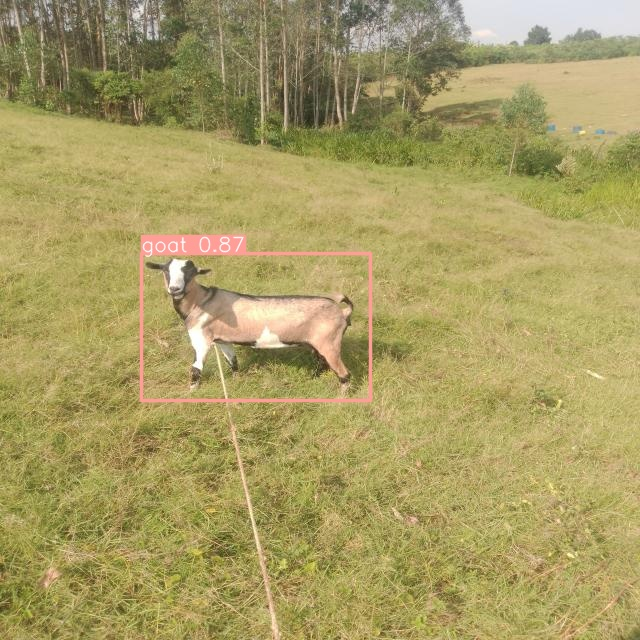

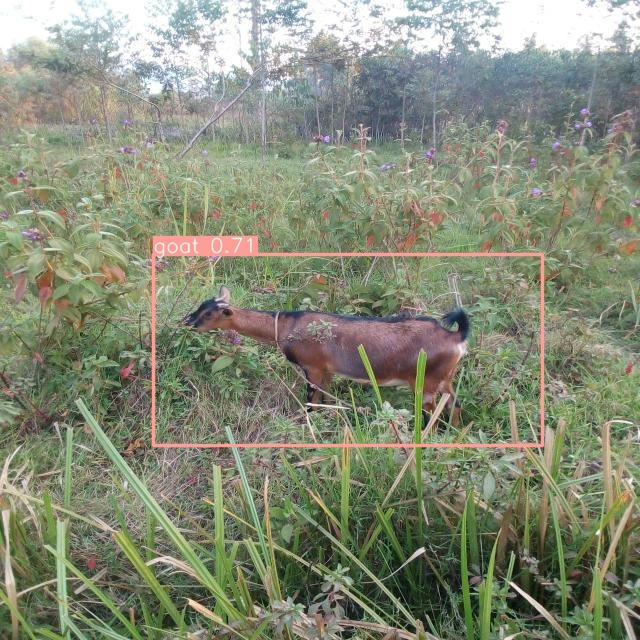

In [27]:
#display predictions
for image_path in glob('runs/detect/predict/*.jpg')[:2]:
    display(Image(filename=image_path, width=1000,height=1000))
    print("\n")

In [28]:
#create submission file
data = []
for result in results:
    image_name = os.path.basename(result.path)
    class_names =result.names
    for box, cls, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
        class_name = class_names[int(cls)]
        bbox = box.cpu().tolist()
        record = [image_name, class_name, conf.item()]+bbox
        data.append(record)

with open(f'submission{int(datetime.now().timestamp())}.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    header = ['filename', 'class', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax']
    writer.writerow(header)
    writer.writerows(data)